In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path so we can import from scripts
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.eda_functions import *

In [2]:
listings_data_path = Path.cwd().parent / "data" / "processed" / "listings_regular_license.parquet"
calendar_data_path = Path.cwd().parent / "data" / "processed" / "calendar_cleaned.parquet"
df = pd.read_parquet(listings_data_path, engine="pyarrow")

In [4]:
df.neighbourhood_cleansed.unique()

['Thessaloniki', 'Neapolis – Sykeon', 'Pilea – Chortiatis', 'Pavlou Mela', 'Kalamaria', 'Ampelokipon – Menemeni', 'Kordelio – Evosmos']
Categories (7, object): ['Ampelokipon – Menemeni', 'Kalamaria', 'Kordelio – Evosmos', 'Neapolis – Sykeon', 'Pavlou Mela', 'Pilea – Chortiatis', 'Thessaloniki']

In [71]:
df.head()

id                  name    host_id host_since  \
0  PROP_B6D8  Co - Enti - En #0001  HOST_723A 2012-05-13   
1  PROP_6279  Ci - Enti - En #0003  HOST_D51E 2012-03-20   
2  PROP_28B3  LU - Enti - En #0004  HOST_33A5 2012-07-10   
3  PROP_2317  He - Enti - En #0005  HOST_CBBB 2012-12-01   
4  PROP_B0A8  Th - Priv - Pr #0001  HOST_5772 2012-10-11   

          host_location host_response_time host_response_rate  \
0  Thessalonika, Greece     within an hour               100%   
1  Thessaloniki, Greece     within an hour               100%   
2  Thessalonika, Greece               None               None   
3  Thessaloniki, Greece               None               None   
4  Thessaloniki, Greece       within a day               100%   

   host_acceptance_rate host_is_superhost  host_total_listings_count  ...  \
0                  0.97              True                          1  ...   
1                  1.00              True                        104  ...   
2                   NaN             False                          2  ...   
3                  1.00             False                          2  ...   
4                  0.53              True                          1  ...   

  review_scores_accuracy review_scores_cleanliness review_scores_checkin  \
0                   4.84                      4.79                  4.95   
1                   4.87                      4.89                  4.85   
2                   5.00                      5.00                  5.00   
3                   4.73                      4.79                  4.83   
4                   4.94                      4.98                  4.94   

   review_scores_communication  review_scores_location review_scores_value  \
0                         4.95                    4.74                4.75   
1                         4.85                    4.45                4.83   
2                         5.00                    4.86                4.29   
3                         4.90                    4.71                4.63   
4                         4.93                    4.65                4.93   

      license  instant_bookable  reviews_per_month      Host_Category  
0  LIC_FB61FA             False               2.62     Individual (1)  
1  LIC_6BC2B7              True               0.32   Large Multi (4+)  
2  LIC_0000CC             False               0.08  Small Multi (2-3)  
3  LIC_B18A7E             False               1.37  Small Multi (2-3)  
4  LIC_F9CE57             False               1.08     Individual (1)  

[5 rows x 49 columns]

In [72]:
df.shape

(4379, 49)

### Create distance variables using the midpoint between the white tower and aristotelous square as a landmark

In [73]:
from geopy.distance import geodesic

landmark_coords = (40.62962, 22.94473) 

df['distance_to_center_km'] = df.apply(
    lambda row: geodesic(
        (row['latitude'], row['longitude']), 
        landmark_coords
    ).km,
    axis=1
)

In [74]:
df.distance_to_center_km.describe()

count    4379.000000
mean        1.719920
std         1.418981
min         0.036680
25%         0.882260
50%         1.274085
75%         2.022193
max         9.628258
Name: distance_to_center_km, dtype: float64

# Add this comment in your code:
"""
Distance Calculation Note:
- Coordinates rounded to 4 decimal places for privacy (~11m precision)
- Maximum distance error: ~14 meters
- For 1-10km distances, this represents <0.3% error
- Acceptable for neighborhood-level geographic analysis
"""

### create distance categories

In [75]:
# Simple, interpretable
df['distance_cat'] = pd.cut(
    df['distance_to_center_km'],
    bins=[0, 1, 3, 6, 100],
    labels=['Downtown (<1km)', 'Inner City (1-3km)', 
            'Neighborhoods (3-6km)', 'Suburban (>6km)']
)

df["price_cat"] = pd.cut(
    df['price'],
    bins=[0, 40, 60, 80, 120, np.inf],
    labels=['Very Low (<40€)', 'Low (40-60€)', 'Medium (60-80€)', 'High (80-120€)', 'Very High (>120€)']
)

# 1. Data Preparation (10 min)
df['first_review_date'] = pd.to_datetime(df['first_review'])
df['last_review_date'] = pd.to_datetime(df['last_review'])
reference_date = df["last_review_date"].max()

df['listing_age_years'] = (reference_date - df['first_review_date']).dt.days / 365.25

# Create maturity categories
df['market_maturity'] = pd.cut(
    df['listing_age_years'],
    bins=[-1, 2, 4, 8, 100],
    labels=['New (<2yr)', 'Growing (2-4yr)', 'Mature (4-8yr)', 'Established (>8yr)']
)

df.to_parquet(Path.cwd().parent / "data" / "processed" / "listings_geographic_temporal.parquet", engine="pyarrow")

### Univariate analysis

### Categorical

0 - distance categories

CATEGORICAL VARIABLE ANALYSIS: distance_cat

Cardinality: 4 unique categories
Missing values: 0 (0.00%)
Total observations: 4379

Most Common Category: 'Inner City (1-3km)' (2358 occurrences, 53.85%)

Rare Categories (<5%): 1
  - 'Suburban (>6km)': 91 (2.08%)

----------------------------------------------------------------------
FREQUENCY TABLE:
----------------------------------------------------------------------
                       Count  Percentage
distance_cat                            
Inner City (1-3km)      2358    53.84791
Downtown (<1km)         1408    32.15346
Neighborhoods (3-6km)    522    11.92053
Suburban (>6km)           91     2.07810


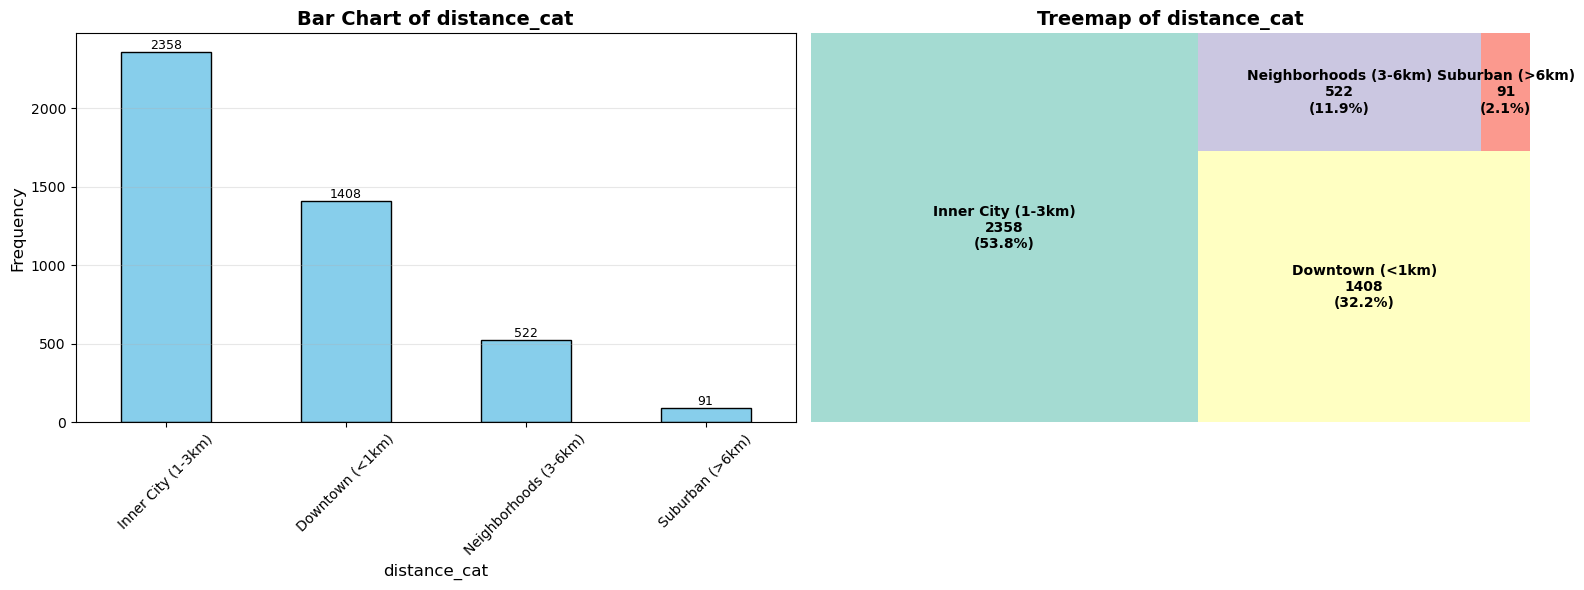

In [8]:
analyze_categorical_variable(df["distance_cat"])

1 - neighbourhood_cleansed

CATEGORICAL VARIABLE ANALYSIS: neighbourhood_cleansed

Cardinality: 7 unique categories
Missing values: 0 (0.00%)
Total observations: 4379

Most Common Category: 'Thessaloniki' (3867 occurrences, 88.31%)

Rare Categories (<5%): 6
  - 'Kalamaria': 151 (3.45%)
  - 'Neapolis – Sykeon': 121 (2.76%)
  - 'Pilea – Chortiatis': 74 (1.69%)
  - 'Ampelokipon – Menemeni': 60 (1.37%)
  - 'Pavlou Mela': 60 (1.37%)
  - 'Kordelio – Evosmos': 46 (1.05%)

----------------------------------------------------------------------
FREQUENCY TABLE:
----------------------------------------------------------------------
                        Count  Percentage
neighbourhood_cleansed                   
Thessaloniki             3867   88.307833
Kalamaria                 151    3.448276
Neapolis – Sykeon         121    2.763188
Pilea – Chortiatis         74    1.689884
Ampelokipon – Menemeni     60    1.370176
Pavlou Mela                60    1.370176
Kordelio – Evosmos         46    1.050468


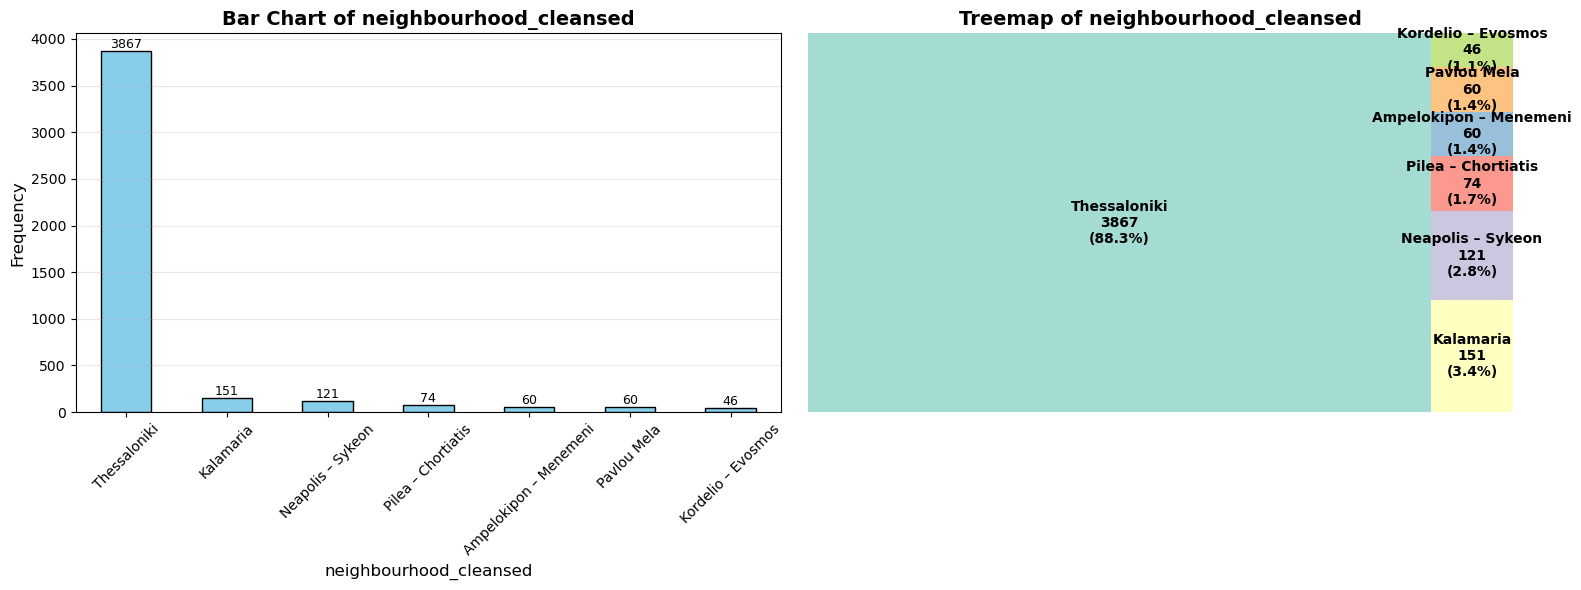

In [9]:
analyze_categorical_variable(df["neighbourhood_cleansed"])

2 - host category

3 - is superhost

4 - instant bookable

### Numerical

0 - distance to center km

DESCRIPTIVE STATISTICS: distance_to_center_km

Central Tendency:
  Mean:           1.72
  Median:         1.27
  Mode:           1.2135298516369977

Dispersion:
  Std Dev:        1.42
  Variance:       2.01
  Range:          9.59
  IQR:            1.14

Quartiles:
  Min (0%):       0.04
  Q1 (25%):       0.88
  Q2 (50%):       1.27
  Q3 (75%):       2.02
  Max (100%):     9.63

Shape:
  Skewness:       1.996
  Kurtosis:       4.614

Sample Size:
  Valid:          4379
  Missing:        0
  Total:          4379


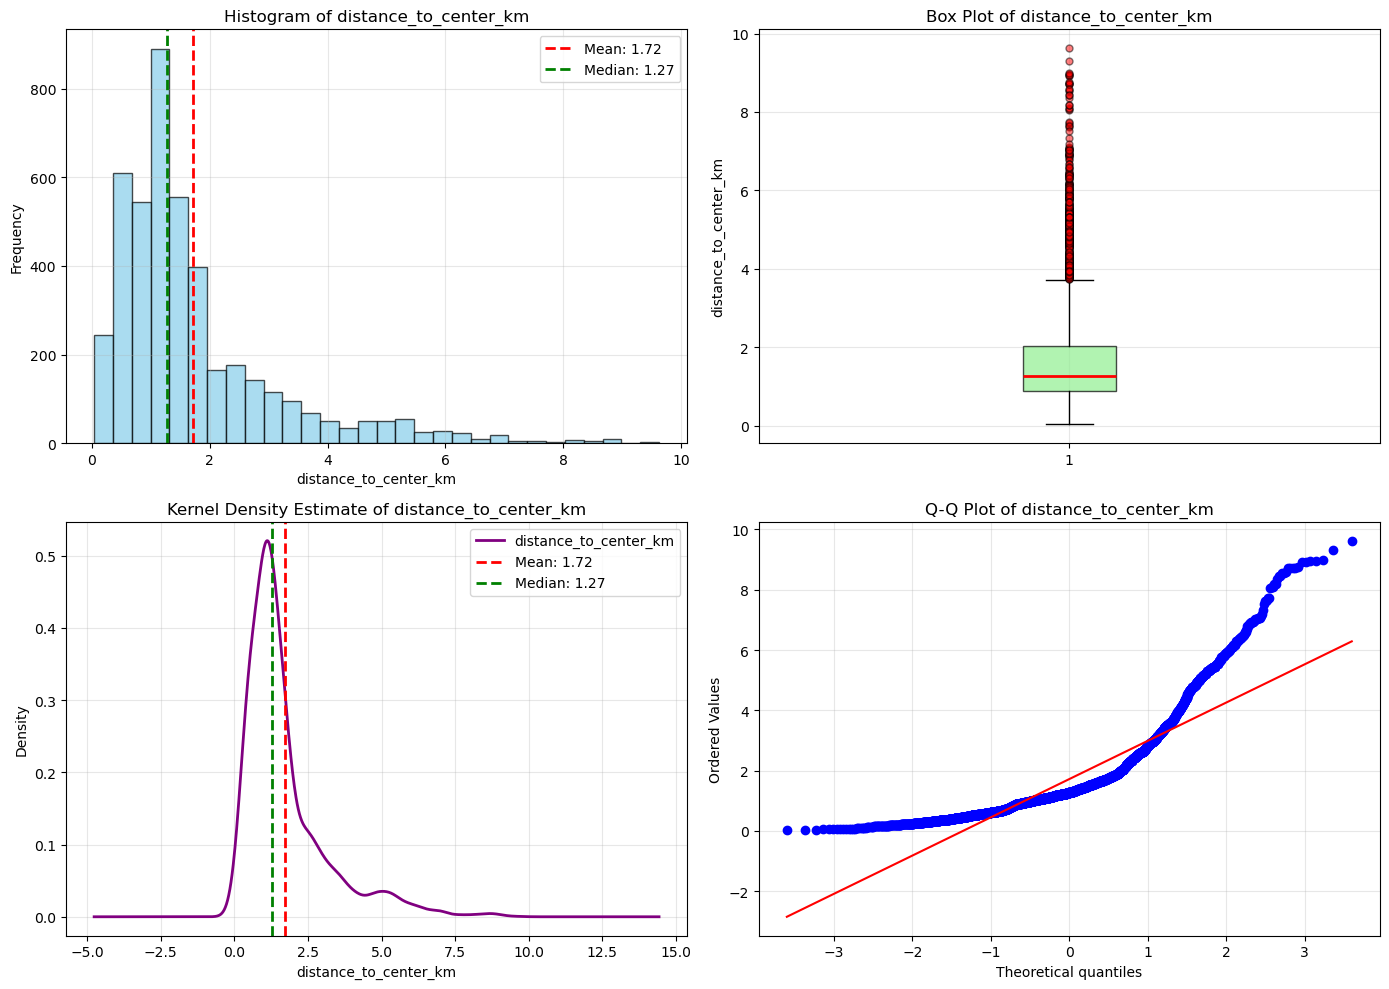

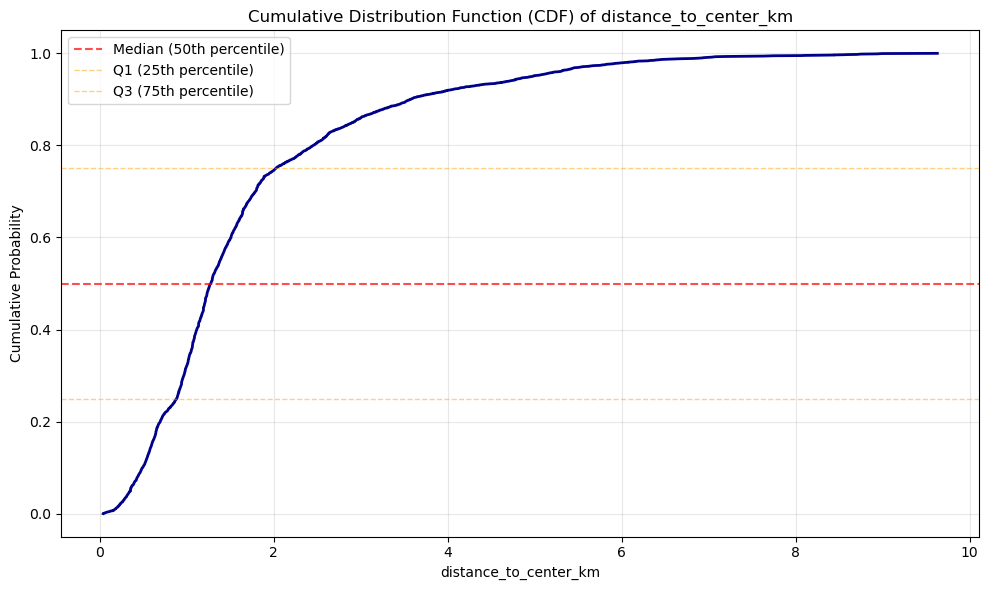

In [13]:
analyze_numeric_variable(df["distance_to_center_km"])

1 - price

In [14]:
df["price"].sort_values(ascending=False).head()

583     1000.0
2509     964.0
1825     964.0
2510     964.0
742      950.0
Name: price, dtype: float64

2 - estimated revenue

DESCRIPTIVE STATISTICS: estimated_revenue_l365d

Central Tendency:
  Mean:           4002.38
  Median:         1980.00
  Mode:           0.0

Dispersion:
  Std Dev:        5747.88
  Variance:       33038118.24
  Range:          109896.00
  IQR:            5242.50

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       469.50
  Q2 (50%):       1980.00
  Q3 (75%):       5712.00
  Max (100%):     109896.00

Shape:
  Skewness:       5.164
  Kurtosis:       61.287

Sample Size:
  Valid:          4170
  Missing:        209
  Total:          4379


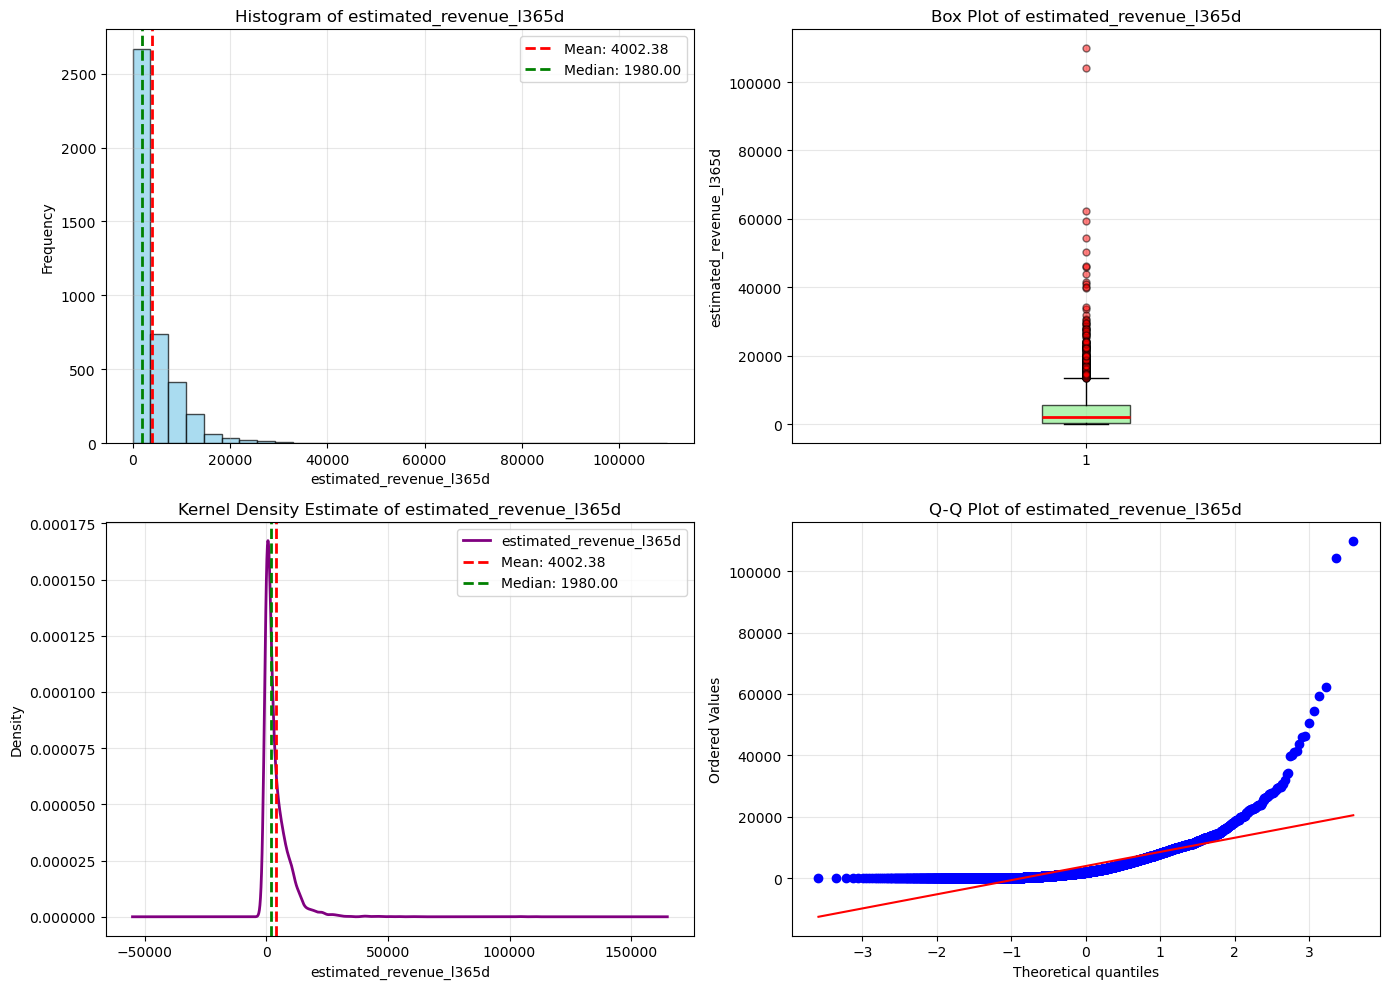

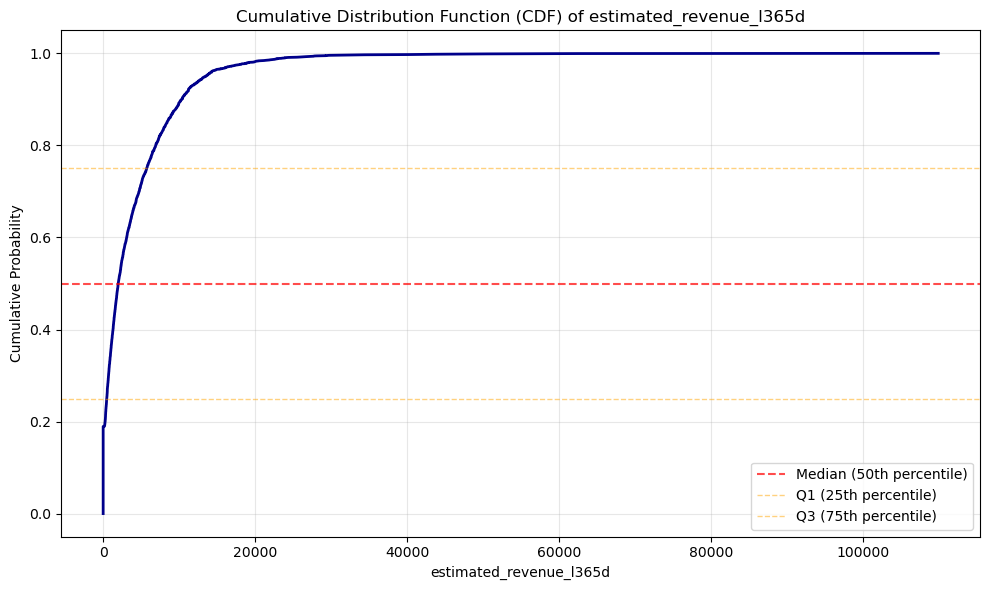

In [16]:
analyze_numeric_variable(df["estimated_revenue_l365d"])

3 - estimated occupnacy

DESCRIPTIVE STATISTICS: estimated_occupancy_l365d

Central Tendency:
  Mean:           66.87
  Median:         36.00
  Mode:           0

Dispersion:
  Std Dev:        75.67
  Variance:       5725.20
  Range:          255.00
  IQR:            102.00

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       6.00
  Q2 (50%):       36.00
  Q3 (75%):       108.00
  Max (100%):     255.00

Shape:
  Skewness:       1.202
  Kurtosis:       0.328

Sample Size:
  Valid:          4379
  Missing:        0
  Total:          4379


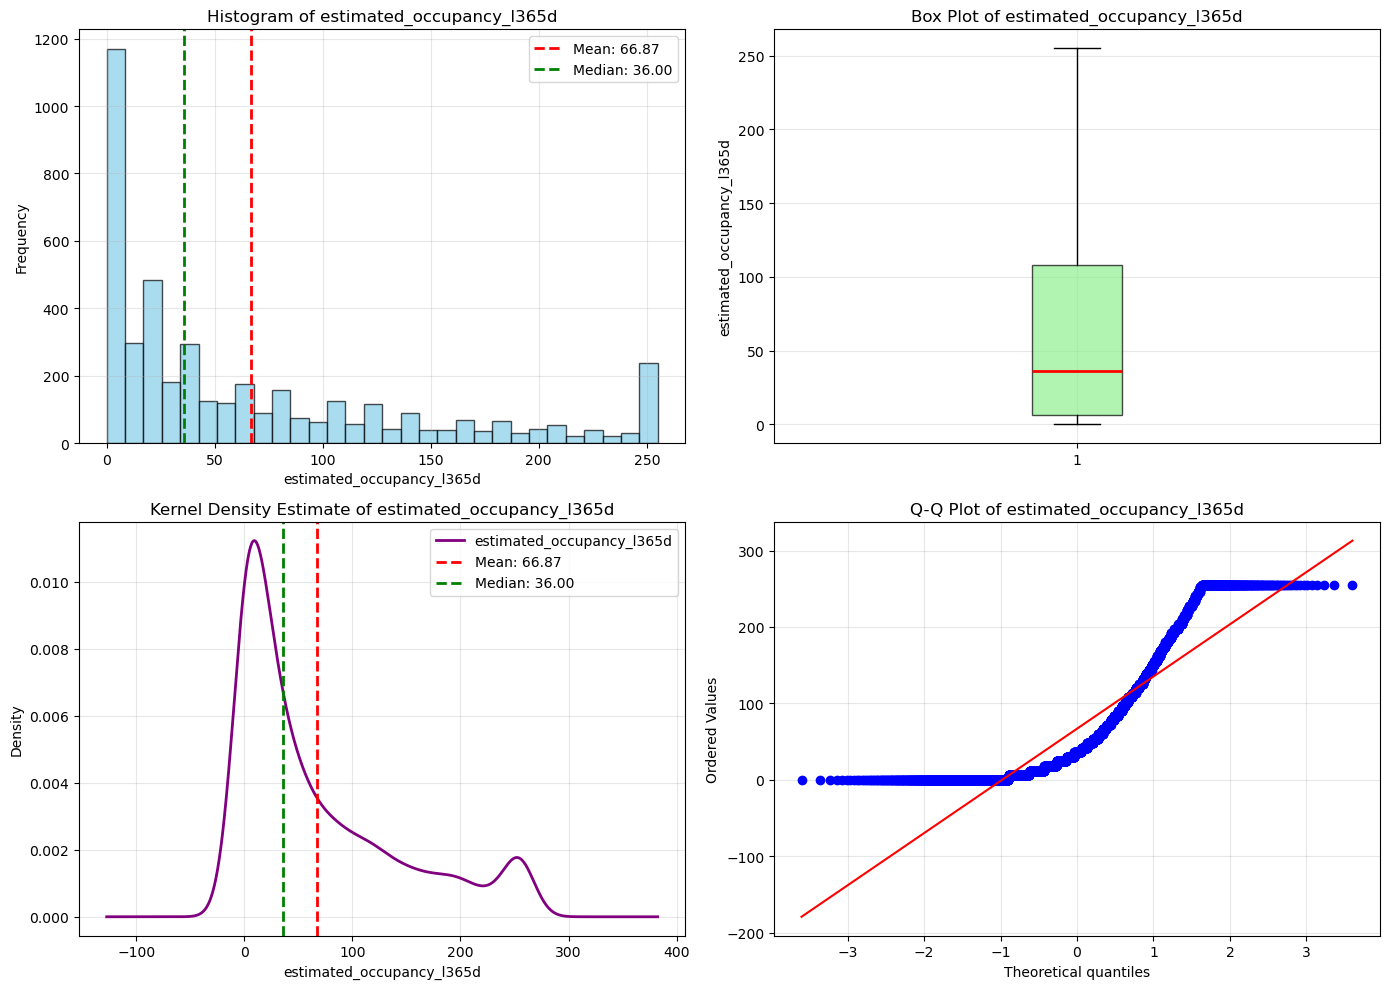

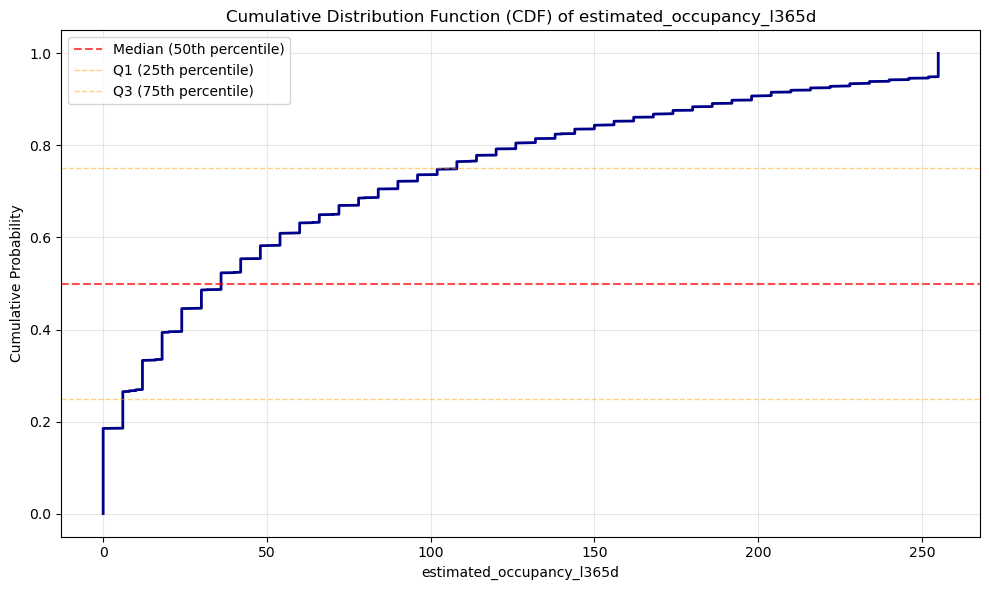

In [17]:
analyze_numeric_variable(df["estimated_occupancy_l365d"])

4 - reviews ltm

DESCRIPTIVE STATISTICS: number_of_reviews_ltm

Central Tendency:
  Mean:           11.65
  Median:         6.00
  Mode:           0

Dispersion:
  Std Dev:        15.26
  Variance:       232.85
  Range:          129.00
  IQR:            16.00

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       1.00
  Q2 (50%):       6.00
  Q3 (75%):       17.00
  Max (100%):     129.00

Shape:
  Skewness:       2.310
  Kurtosis:       7.396

Sample Size:
  Valid:          4379
  Missing:        0
  Total:          4379


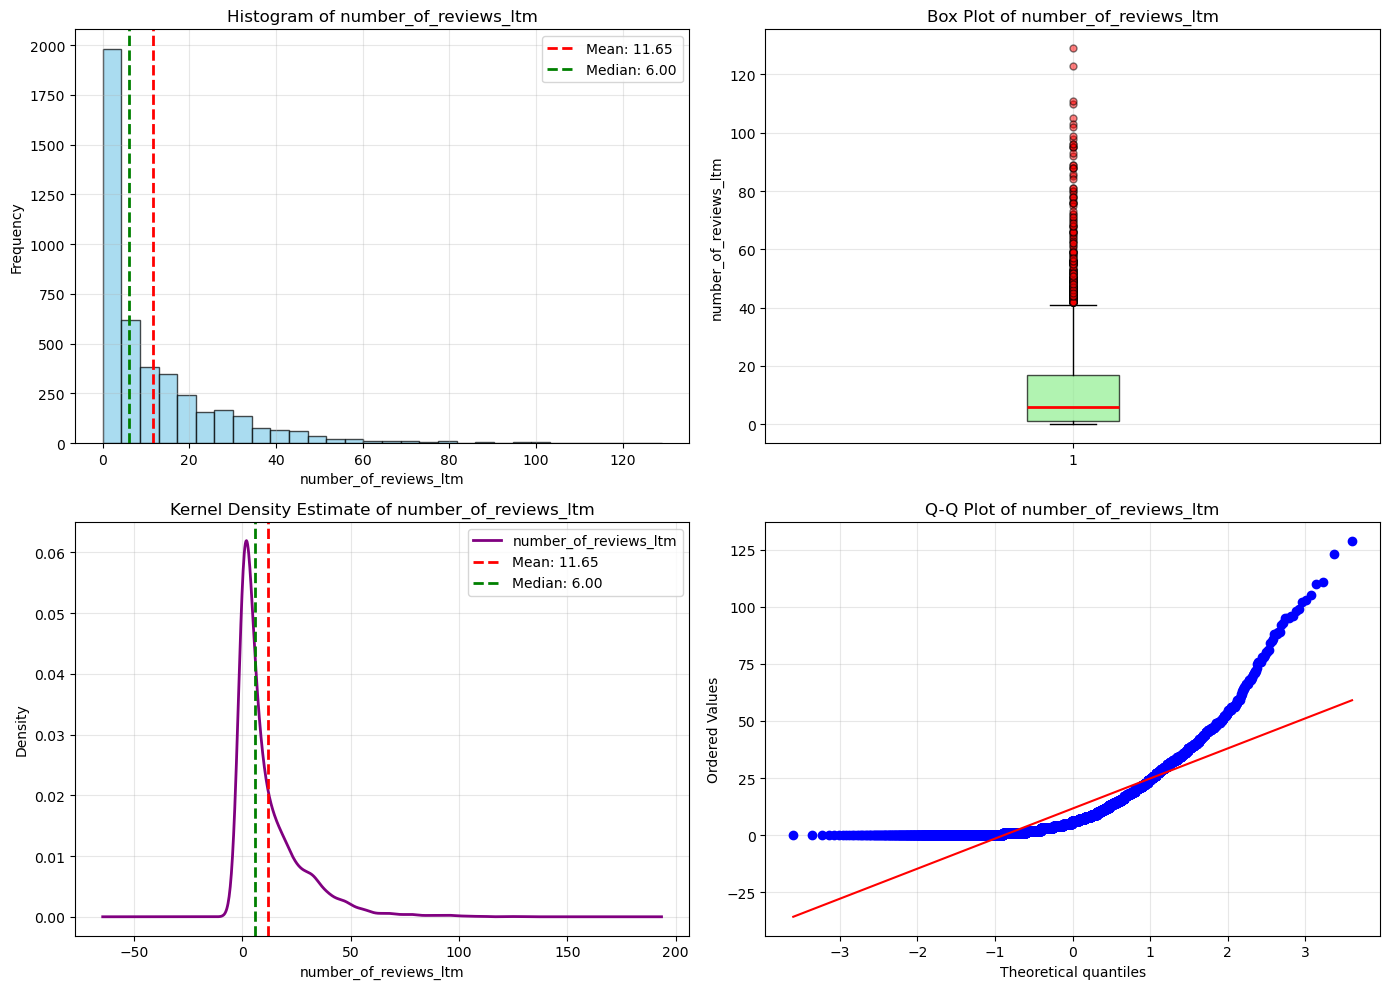

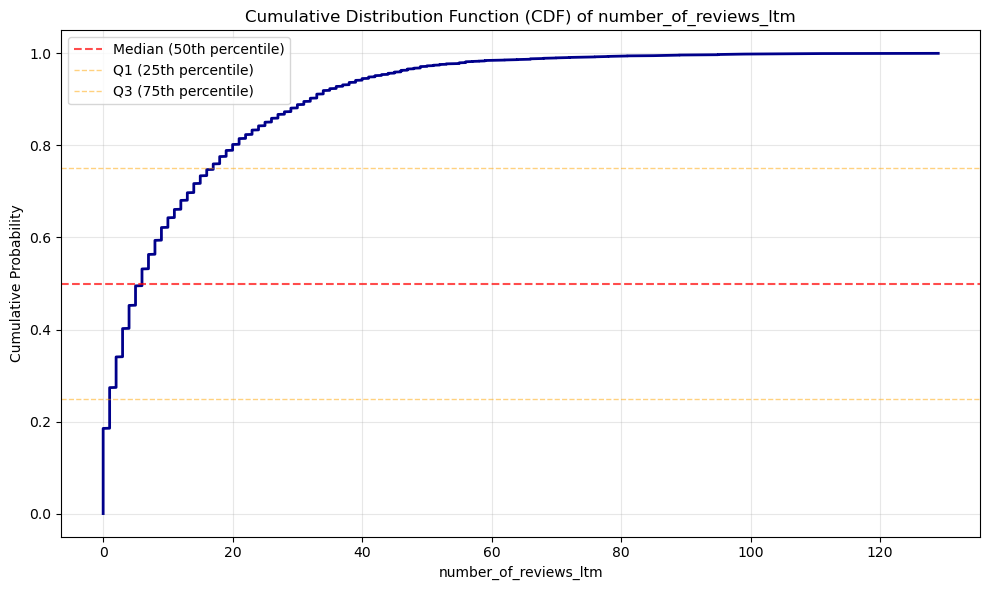

In [18]:
analyze_numeric_variable(df["number_of_reviews_ltm"])

5 - review rating

DESCRIPTIVE STATISTICS: review_scores_rating

Central Tendency:
  Mean:           4.73
  Median:         4.85
  Mode:           5.0

Dispersion:
  Std Dev:        0.40
  Variance:       0.16
  Range:          4.00
  IQR:            0.30

Quartiles:
  Min (0%):       1.00
  Q1 (25%):       4.67
  Q2 (50%):       4.85
  Q3 (75%):       4.97
  Max (100%):     5.00

Shape:
  Skewness:       -3.913
  Kurtosis:       23.943

Sample Size:
  Valid:          3918
  Missing:        461
  Total:          4379


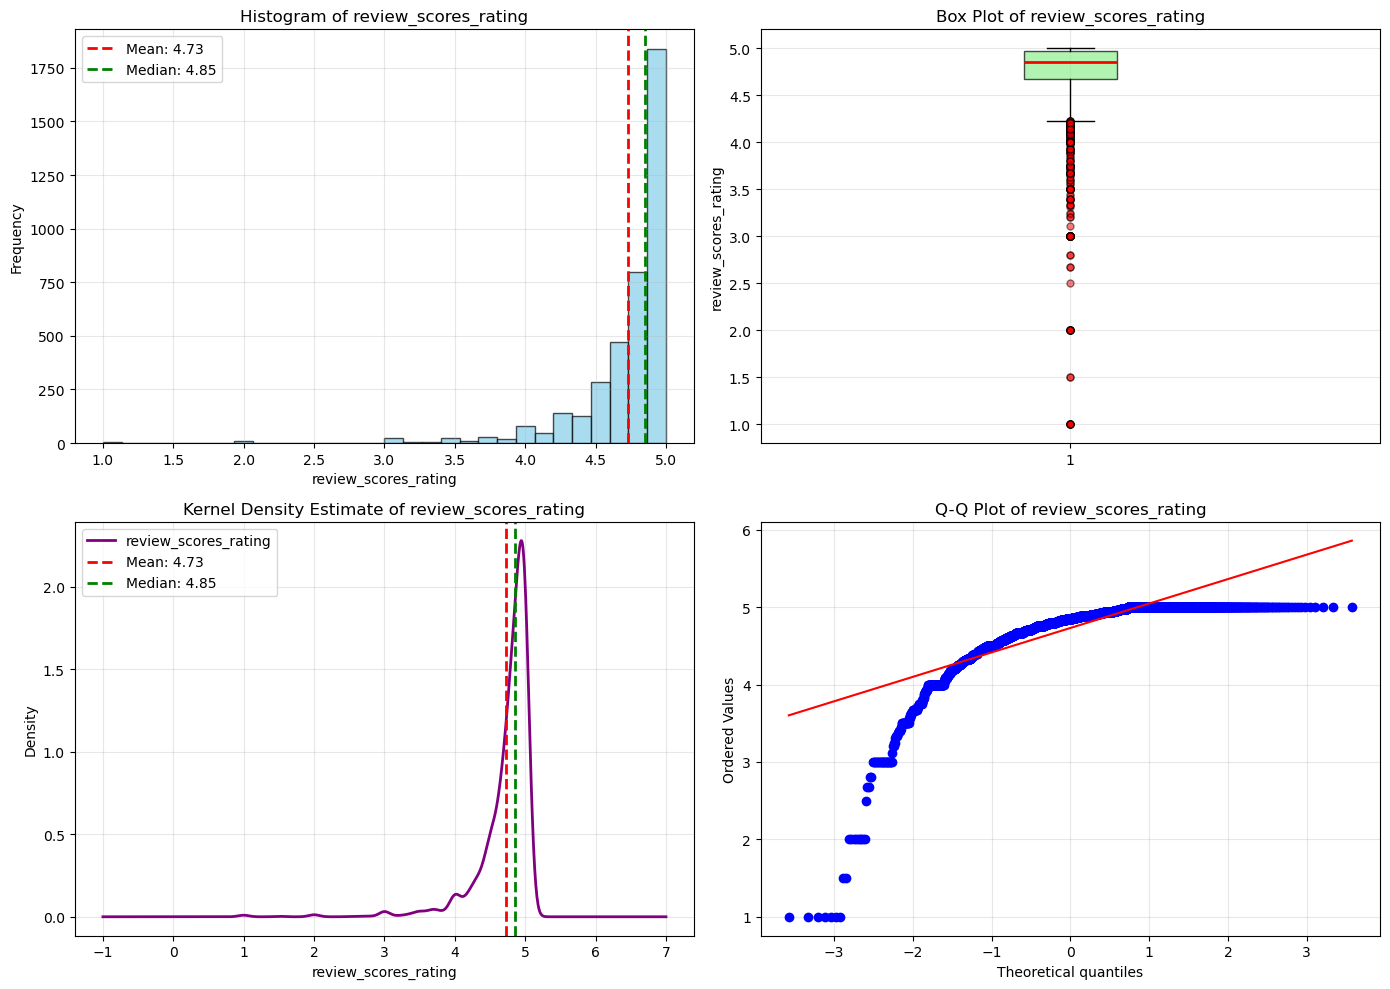

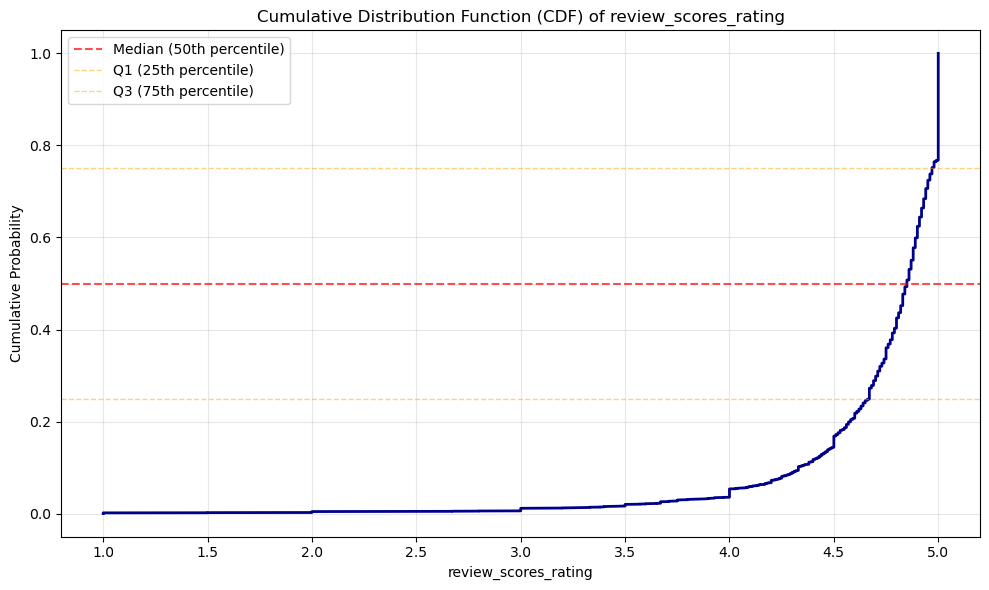

In [19]:
analyze_numeric_variable(df["review_scores_rating"])

6 - value rating

DESCRIPTIVE STATISTICS: review_scores_value

Central Tendency:
  Mean:           4.68
  Median:         4.78
  Mode:           5.0

Dispersion:
  Std Dev:        0.40
  Variance:       0.16
  Range:          4.00
  IQR:            0.32

Quartiles:
  Min (0%):       1.00
  Q1 (25%):       4.59
  Q2 (50%):       4.78
  Q3 (75%):       4.91
  Max (100%):     5.00

Shape:
  Skewness:       -3.835
  Kurtosis:       23.733

Sample Size:
  Valid:          3918
  Missing:        461
  Total:          4379


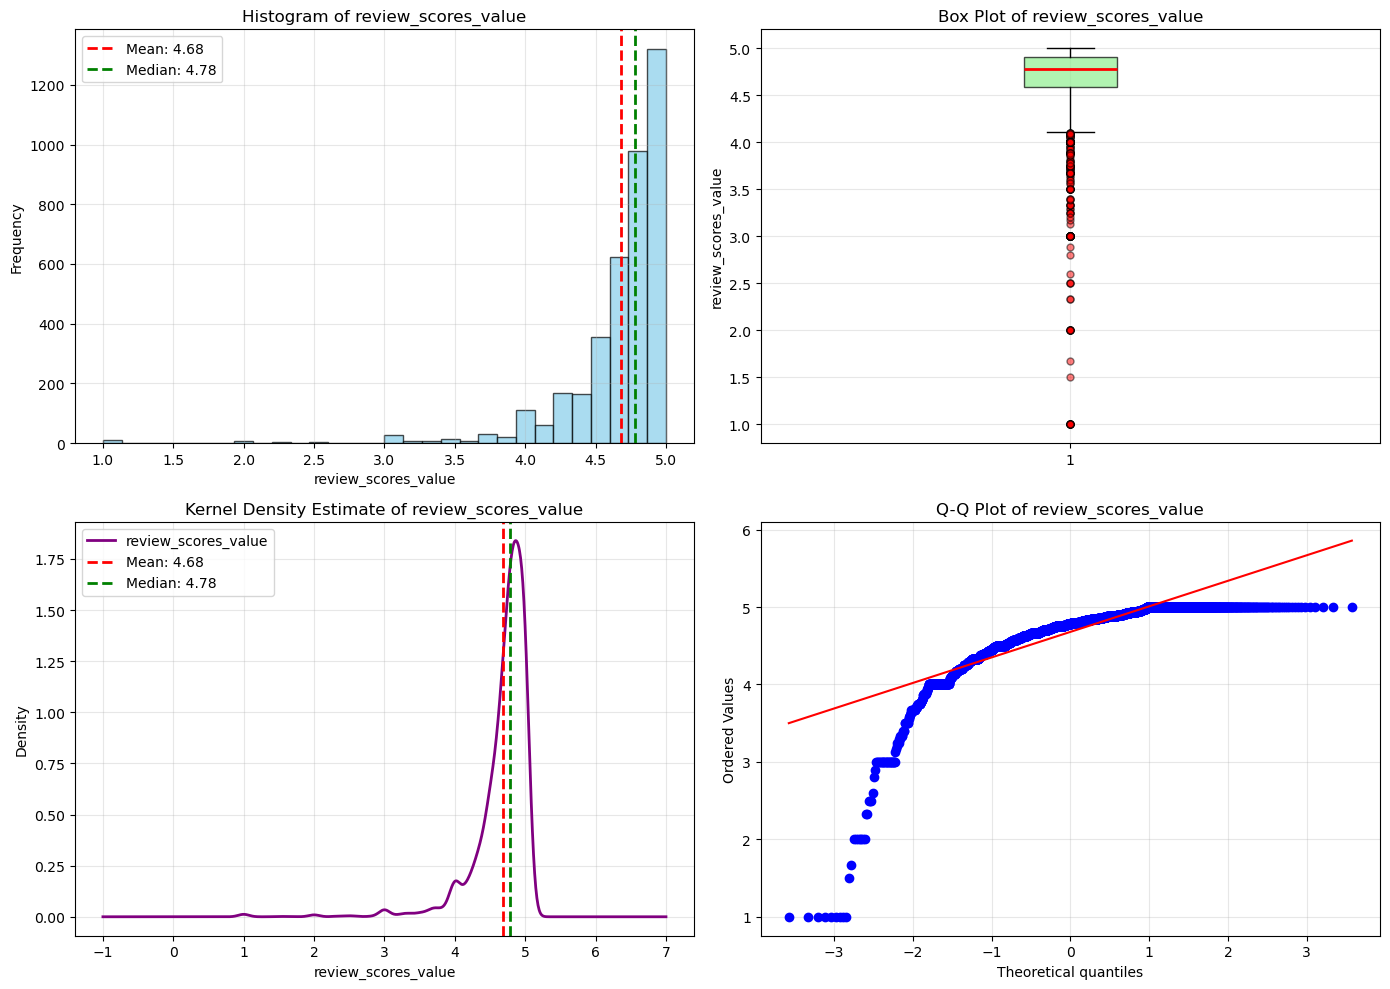

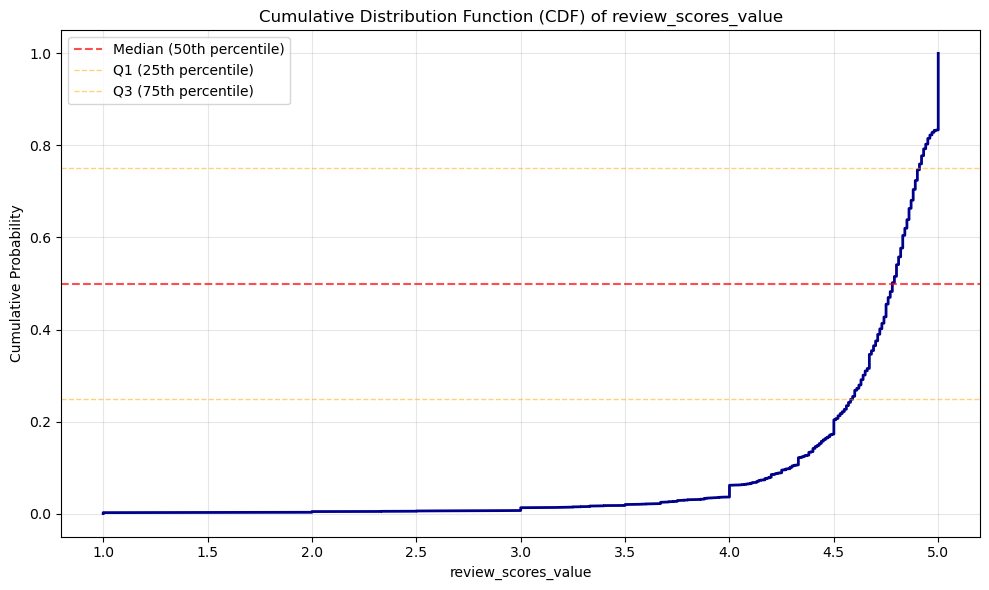

In [20]:
analyze_numeric_variable(df["review_scores_value"])

7 - host total listings

accomodates, bedrooms, bathrooms, beds

8 - accomodates

DESCRIPTIVE STATISTICS: accommodates

Central Tendency:
  Mean:           3.63
  Median:         4.00
  Mode:           4

Dispersion:
  Std Dev:        1.58
  Variance:       2.50
  Range:          15.00
  IQR:            2.00

Quartiles:
  Min (0%):       1.00
  Q1 (25%):       2.00
  Q2 (50%):       4.00
  Q3 (75%):       4.00
  Max (100%):     16.00

Shape:
  Skewness:       1.777
  Kurtosis:       6.959

Sample Size:
  Valid:          4379
  Missing:        0
  Total:          4379


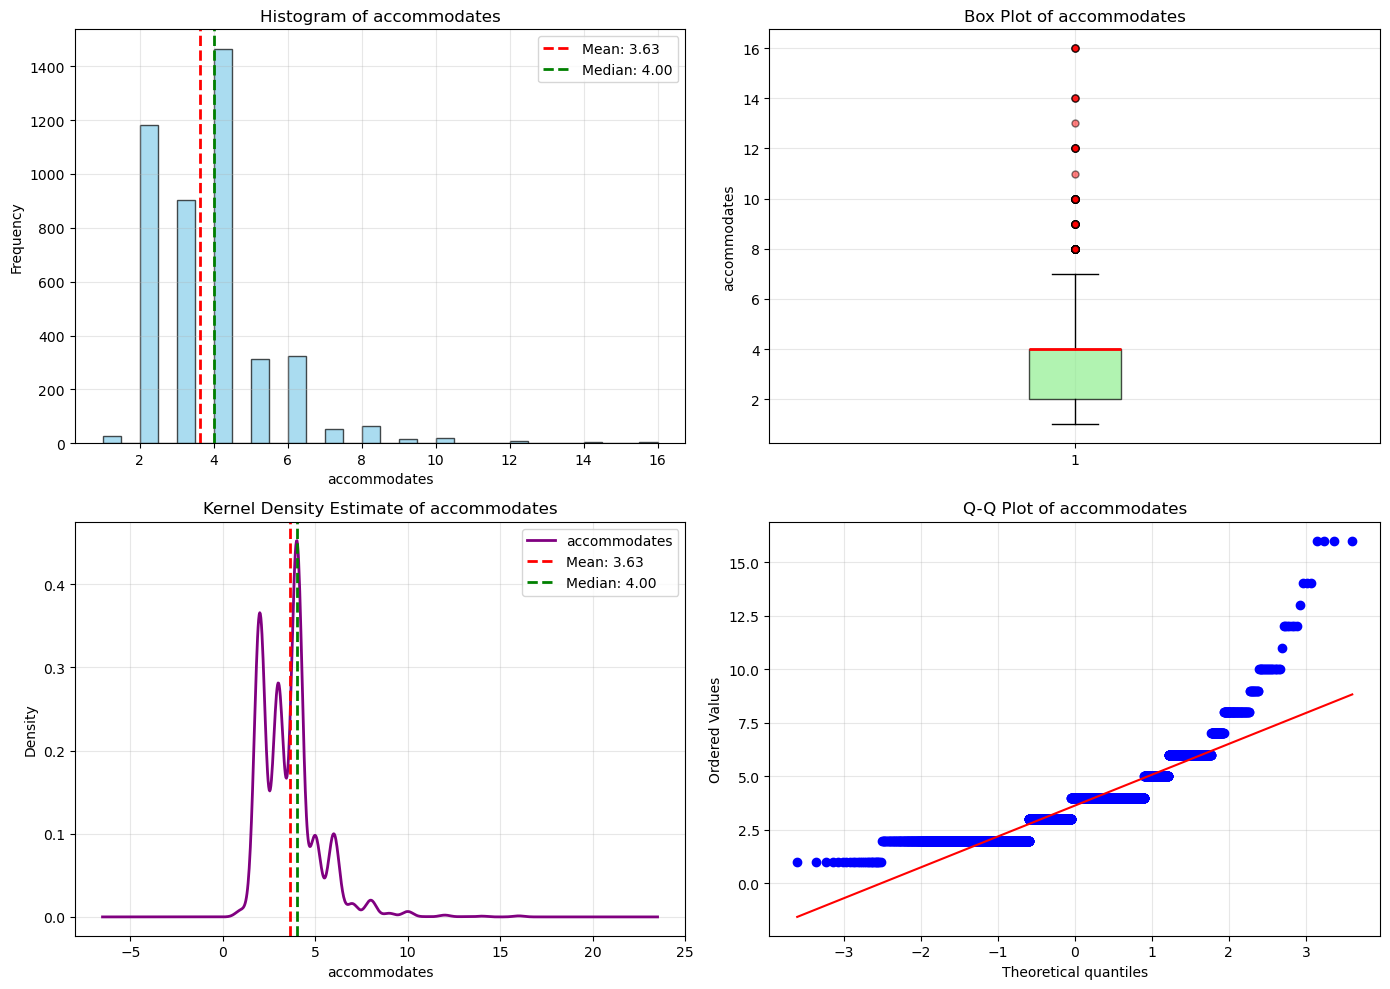

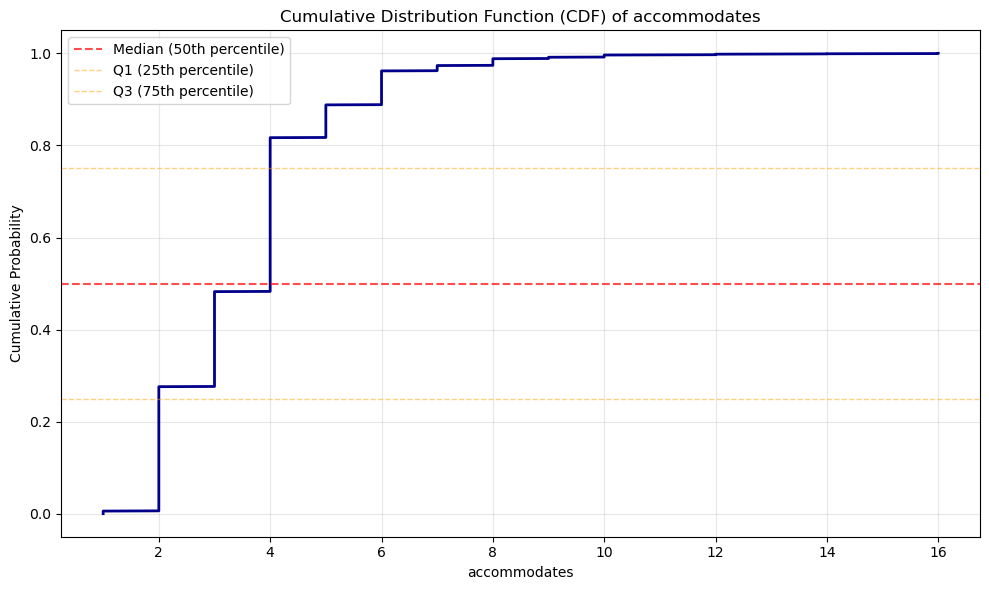

In [22]:
analyze_numeric_variable(df["accommodates"])

<hr>

### distance cat & neighbourhood level statistics

In [25]:
df_5.groupby("distance_cat")[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
     'review_scores_location', 'review_scores_value', 'reviews_per_month', 'distance_to_center_km'
    ]].agg(['mean', 'median']).round(2)

/tmp/ipykernel_1898/1261497617.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_5.groupby("distance_cat")[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',


accommodates         price        number_of_reviews_ltm  \
                              mean median   mean median                  mean   
distance_cat                                                                    
Downtown (<1km)               3.74    4.0  75.96   66.0                 13.78   
Inner City (1-3km)             3.5    3.0  59.18   50.0                 11.06   
Neighborhoods (3-6km)         3.81    4.0  69.03   60.0                  9.24   
Suburban (>6km)               4.27    4.0  91.56   73.0                  7.69   

                             estimated_occupancy_l365d         \
                      median                      mean median   
distance_cat                                                    
Downtown (<1km)          6.0                     74.19   36.0   
Inner City (1-3km)       6.0                     65.11   36.0   
Neighborhoods (3-6km)    5.0                     58.53   30.0   
Suburban (>6km)          4.0                     46.73   24.0   

                      estimated_revenue_l365d         review_scores_rating  \
                                         mean  median                 mean   
distance_cat                                                                 
Downtown (<1km)                       5031.82  2604.0                 4.76   
Inner City (1-3km)                    3534.93  1787.0                 4.69   
Neighborhoods (3-6km)                 3620.26  1944.0                 4.81   
Suburban (>6km)                       3095.98  2112.0                 4.76   

                             review_scores_location         \
                      median                   mean median   
distance_cat                                                 
Downtown (<1km)         4.87                   4.88   4.95   
Inner City (1-3km)      4.81                   4.63   4.70   
Neighborhoods (3-6km)   4.90                   4.73   4.80   
Suburban (>6km)         4.92                   4.75   4.86   

                      review_scores_value        reviews_per_month         \
                                     mean median              mean median   
distance_cat                                                                
Downtown (<1km)                      4.71   4.81              1.57   1.10   
Inner City (1-3km)                   4.65   4.75              1.49   1.13   
Neighborhoods (3-6km)                4.73   4.81              1.20   0.90   
Suburban (>6km)                      4.64   4.78              0.98   0.72   

                      distance_to_center_km         
                                       mean median  
distance_cat                                        
Downtown (<1km)                        0.62   0.62  
Inner City (1-3km)                     1.62   1.48  
Neighborhoods (3-6km)                  4.20   4.00  
Suburban (>6km)                        7.15   6.90

In [26]:
df_5.groupby("neighbourhood_cleansed")[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
     'review_scores_location', 'review_scores_value', 'reviews_per_month', 'distance_to_center_km'
    ]].agg(['mean', 'median']).round(2)

/tmp/ipykernel_1898/1236332551.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_5.groupby("neighbourhood_cleansed")[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',


accommodates         price         \
                               mean median   mean median   
neighbourhood_cleansed                                     
Ampelokipon – Menemeni         3.53    3.0  56.13   51.0   
Kalamaria                      4.02    4.0  74.79   70.5   
Kordelio – Evosmos             4.41    4.0  67.84   56.5   
Neapolis – Sykeon              3.79    4.0  61.15   53.0   
Pavlou Mela                    3.85    4.0  53.08   49.0   
Pilea – Chortiatis             4.14    4.0  94.12   69.0   
Thessaloniki                   3.59    4.0  65.90   54.0   

                       number_of_reviews_ltm        estimated_occupancy_l365d  \
                                        mean median                      mean   
neighbourhood_cleansed                                                          
Ampelokipon – Menemeni                  9.78    4.0                     61.25   
Kalamaria                               8.83    6.0                     56.87   
Kordelio – Evosmos                     11.61    5.0                     69.59   
Neapolis – Sykeon                       9.58    5.0                     56.93   
Pavlou Mela                            14.28    8.0                     84.33   
Pilea – Chortiatis                      6.72    4.0                     40.32   
Thessaloniki                           11.91    6.0                     67.86   

                              estimated_revenue_l365d          \
                       median                    mean  median   
neighbourhood_cleansed                                          
Ampelokipon – Menemeni   24.0                 3954.94  1458.0   
Kalamaria                36.0                 3942.75  2400.0   
Kordelio – Evosmos       30.0                 3605.66  3036.0   
Neapolis – Sykeon        30.0                 2991.91  1776.0   
Pavlou Mela              48.0                 3988.02  2760.0   
Pilea – Chortiatis       24.0                 2759.11  1464.0   
Thessaloniki             36.0                 4066.88  1998.0   

                       review_scores_rating        review_scores_location  \
                                       mean median                   mean   
neighbourhood_cleansed                                                      
Ampelokipon – Menemeni                 4.76   4.82                   4.45   
Kalamaria                              4.82   4.90                   4.79   
Kordelio – Evosmos                     4.90   4.94                   4.76   
Neapolis – Sykeon                      4.73   4.90                   4.63   
Pavlou Mela                            4.80   4.89                   4.63   
Pilea – Chortiatis                     4.77   4.92                   4.79   
Thessaloniki                           4.72   4.84                   4.73   

                              review_scores_value        reviews_per_month  \
                       median                mean median              mean   
neighbourhood_cleansed                                                       
Ampelokipon – Menemeni   4.56                4.68   4.76              1.20   
Kalamaria                4.88                4.74   4.81              1.08   
Kordelio – Evosmos       4.82                4.81   4.86              1.27   
Neapolis – Sykeon        4.73                4.70   4.85              1.29   
Pavlou Mela              4.66                4.72   4.82              1.70   
Pilea – Chortiatis       4.86                4.69   4.84              0.95   
Thessaloniki             4.82                4.67   4.78              1.51   

                              distance_to_center_km         
                       median                  mean median  
neighbourhood_cleansed                                      
Ampelokipon – Menemeni   0.69                  3.07   2.75  
Kalamaria                0.90                  5.59   5.50  
Kordelio – Evosmos       1.13                  5.28   5.20  
Neapolis – Sykeon        0.84             

In [27]:
df_5["neighbourhood_cleansed"].value_counts()

neighbourhood_cleansed
Thessaloniki              3867
Kalamaria                  151
Neapolis – Sykeon          121
Pilea – Chortiatis          74
Ampelokipon – Menemeni      60
Pavlou Mela                 60
Kordelio – Evosmos          46
Name: count, dtype: int64

In [28]:
df_5["distance_cat"].value_counts()

distance_cat
Inner City (1-3km)       2358
Downtown (<1km)          1408
Neighborhoods (3-6km)     522
Suburban (>6km)            91
Name: count, dtype: int64

In [29]:
df_5.loc[df_5['neighbourhood_cleansed'] == 'Pavlou Mela'].sort_values(by='estimated_revenue_l365d', ascending=False).head(10)

id    host_id host_is_superhost  host_total_listings_count  \
1271  PROP_5812  HOST_F999              True                          1   
2049  PROP_E594  HOST_8200              None                         36   
1898  PROP_D988  HOST_8200              None                         36   
1166  PROP_3E7D  HOST_9B08              True                          2   
1358  PROP_83C7  HOST_3E06              True                          1   
2042  PROP_222D  HOST_8200              None                         36   
2259  PROP_196E  HOST_9DFE              True                          1   
1896  PROP_CA49  HOST_8200              None                         36   
2238  PROP_1575  HOST_8200              None                         36   
2306  PROP_A815  HOST_8200              None                         36   

     neighbourhood_cleansed  latitude  longitude       property_type  \
1271            Pavlou Mela   40.6799    22.9366        Entire condo   
2049            Pavlou Mela   40.6775    22.9349  Entire rental unit   
1898            Pavlou Mela   40.6768    22.9355  Entire rental unit   
1166            Pavlou Mela   40.6664    22.9288         Entire home   
1358            Pavlou Mela   40.6550    22.9533        Entire condo   
2042            Pavlou Mela   40.6778    22.9351  Entire rental unit   
2259            Pavlou Mela   40.6789    22.9365  Entire rental unit   
1896            Pavlou Mela   40.6775    22.9348  Entire rental unit   
2238            Pavlou Mela   40.6853    22.9301  Entire rental unit   
2306            Pavlou Mela   40.6852    22.9303  Entire rental unit   

            room_type  accommodates  ...  first_review  last_review  \
1271  Entire home/apt             6  ...    2024-08-05   2025-06-13   
2049  Entire home/apt             6  ...    2023-06-23   2025-06-22   
1898  Entire home/apt             4  ...    2023-05-08   2025-06-16   
1166  Entire home/apt             4  ...    2021-07-31   2025-05-19   
1358  Entire home/apt             5  ...    2022-03-13   2025-06-16   
2042  Entire home/apt             4  ...    2023-06-05   2025-06-18   
2259  Entire home/apt             6  ...    2023-12-02   2025-06-17   
1896  Entire home/apt             5  ...    2023-04-02   2025-06-06   
2238  Entire home/apt             5  ...    2023-09-10   2025-05-25   
2306  Entire home/apt             5  ...    2023-10-15   2025-06-21   

      review_scores_rating  review_scores_location  review_scores_value  \
1271                  4.91                    4.53                 4.88   
2049                  4.88                    4.65                 4.75   
1898                  4.85                    4.57                 4.82   
1166                  4.91                    4.75                 4.75   
1358                  4.80                    4.35                 4.78   
2042                  4.92                    4.52                 4.87   
2259                  4.94                    4.55                 4.74   
1896                  4.86                    4.43                 4.87   
2238                  4.90                    4.59                 4.70   
2306                  4.98                    4.61                 4.84   

      instant_bookable  reviews_per_month      Host_Category  \
1271              True               5.28     Individual (1)   
2049              True               1.64   Large Multi (4+)   
1898              True               3.93   Large Multi (4+)   
1166              True               2.91  Small Multi (2-3)   
1358             False               3.13     Individual (1)   
2042              True               2.44   Large Multi (4+)   
2259              True               1.63     Individual (1)   
1896              True               2.83   Large Multi (4+)   
2238              True               2.89   Large Multi (4+)   
2306              True               2.47   Large Multi (4+)   

      distance_to_center_km           distance_cat  
1271               5.625632 

In [30]:
df_5.groupby(["neighbourhood_cleansed", "distance_cat"])[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'review_scores_rating',
     'review_scores_location', 'review_scores_value', 'reviews_per_month']].agg(['mean', 'median', 'std', 'count']).round(2)

/tmp/ipykernel_1898/165554306.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_5.groupby(["neighbourhood_cleansed", "distance_cat"])[['accommodates','price', 'number_of_reviews_ltm', 'estimated_occupancy_l365d',


accommodates                     \
                                                     mean median   std count   
neighbourhood_cleansed distance_cat                                            
Ampelokipon – Menemeni Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)             3.5    3.0  1.75    34   
                       Neighborhoods (3-6km)         3.58    4.0   1.1    26   
                       Suburban (>6km)               <NA>   <NA>  <NA>     0   
Kalamaria              Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)            <NA>   <NA>  <NA>     0   
                       Neighborhoods (3-6km)         3.92    4.0  1.42   111   
                       Suburban (>6km)                4.3    4.0   1.7    40   
Kordelio – Evosmos     Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)            <NA>   <NA>  <NA>     0   
                       Neighborhoods (3-6km)         4.69    4.0  2.57    36   
                       Suburban (>6km)                3.4    3.5  0.97    10   
Neapolis – Sykeon      Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)            3.74    4.0  1.64   113   
                       Neighborhoods (3-6km)         4.38    3.5  2.67     8   
                       Suburban (>6km)               <NA>   <NA>  <NA>     0   
Pavlou Mela            Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)             5.0    5.0  <NA>     1   
                       Neighborhoods (3-6km)         3.79    4.0  1.43    53   
                       Suburban (>6km)               4.17    4.0  0.75     6   
Pilea – Chortiatis     Downtown (<1km)               <NA>   <NA>  <NA>     0   
                       Inner City (1-3km)            <NA>   <NA>  <NA>     0   
                       Neighborhoods (3-6km)         3.79    4.0   1.4    39   
                       Suburban (>6km)               4.51    4.0  3.01    35   
Thessaloniki           Downtown (<1km)               3.74    4.0   1.7  1408   
                       Inner City (1-3km)            3.48    3.0  1.45  2210   
                       Neighborhoods (3-6km)         3.64    4.0   1.4   249   
                       Suburban (>6km)               <NA>   <NA>  <NA>     0   

                                               price                       \
                                                mean median     std count   
neighbourhood_cleansed distance_cat                                         
Ampelokipon – Menemeni Downtown (<1km)           NaN    NaN     NaN     0   
                       Inner City (1-3km)      51.90   45.0   32.69    31   
                       Neighborhoods (3-6km)   62.09   58.5   21.79    22   
                       Suburban (>6km)           NaN    NaN     NaN     0   
Kalamaria              Downtown (<1km)           NaN    NaN     NaN     0   
                       Inner City (1-3km)        NaN    NaN     NaN     0   
                       Neighborhoods (3-6km)   73.37   69.0   31.39   106   
                       Suburban (>6km)         78.58   74.0   25.65    40   
Kordelio – Evosmos     Downtown (<1km)           NaN    NaN     NaN     0   
                       Inner City (1-3km)        NaN    NaN     NaN     0   
                       Neighborhoods (3-6km)   68.83   57.0   41.63    35   
                       Suburban (>6km)         64.00   51.0   32.99     9   
Neapolis – Sykeon      Downtown (<1km)           NaN    NaN     NaN     0   
                       Inner City (1-3km)      61.63   53.0   39.08   109   
                       Neighborhoods (3-6km)   54.62   54.5   14.85     8   
                       Suburban (>6km)           NaN    NaN     NaN     0   
Pavlou Mela            Downtown (<1km)           NaN    NaN     NaN     0   
                       I

### Bivariate analysis with distance to center

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


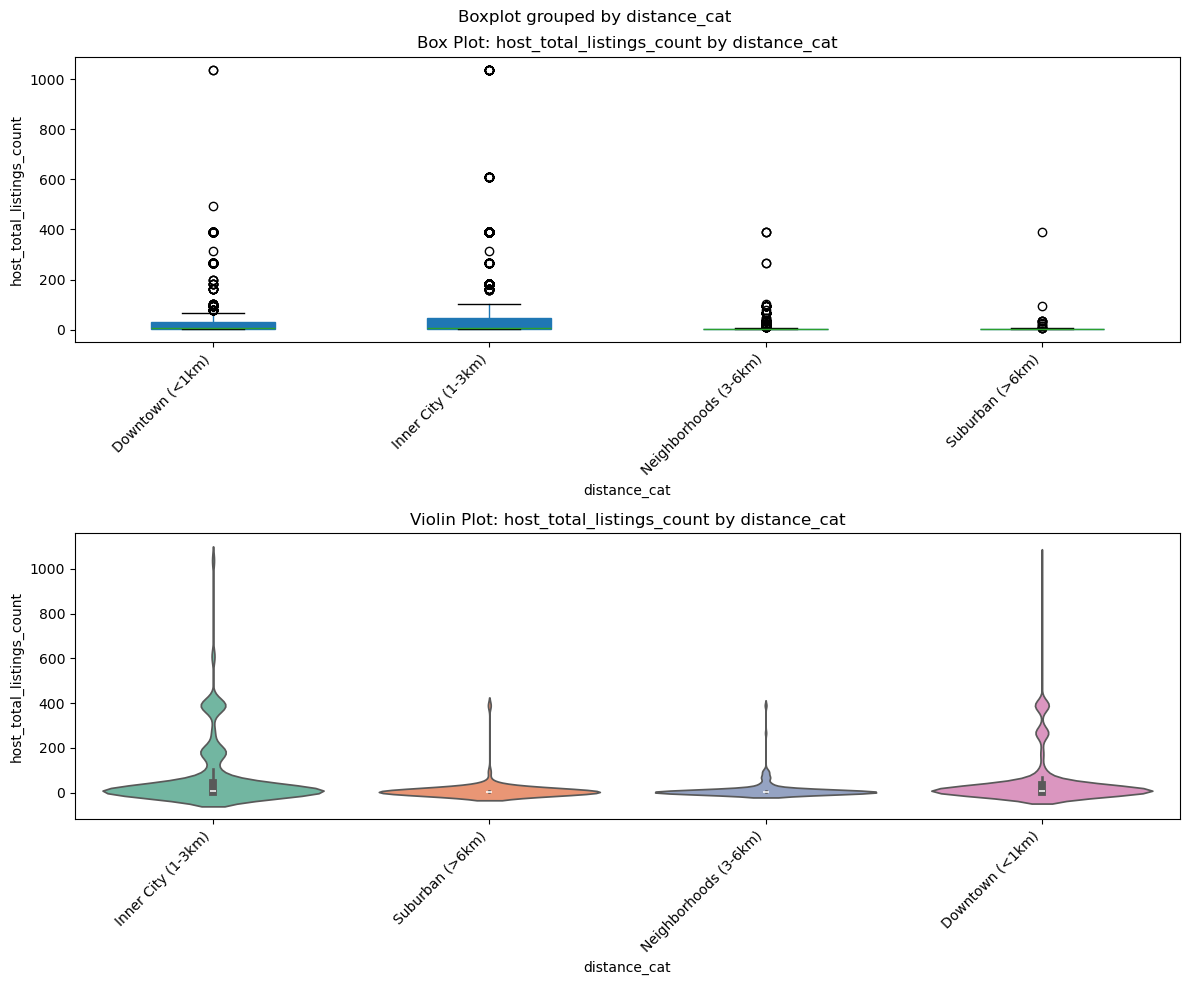

ONE-WAY ANOVA: host_total_listings_count by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2246
    Mean:   72.3255
    Median: 7.0000
    Std:    145.9601
    Min:    1.0000
    Max:    1038.0000

  distance_cat = Suburban (>6km):
    N:      87
    Mean:   10.1379
    Median: 2.0000
    Std:    43.0268
    Min:    1.0000
    Max:    390.0000

  distance_cat = Neighborhoods (3-6km):
    N:      494
    Mean:   12.1680
    Median: 2.0000
    Std:    38.8658
    Min:    1.0000
    Max:    390.0000

  distance_cat = Downtown (<1km):
    N:      1328
    Mean:   47.2545
    Median: 7.0000
    Std:    105.0030
    Min:    1.0000
    Max:    1038.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      40.0094
  P-value:             0.000000
  Eta-squared (η²):    0.028
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


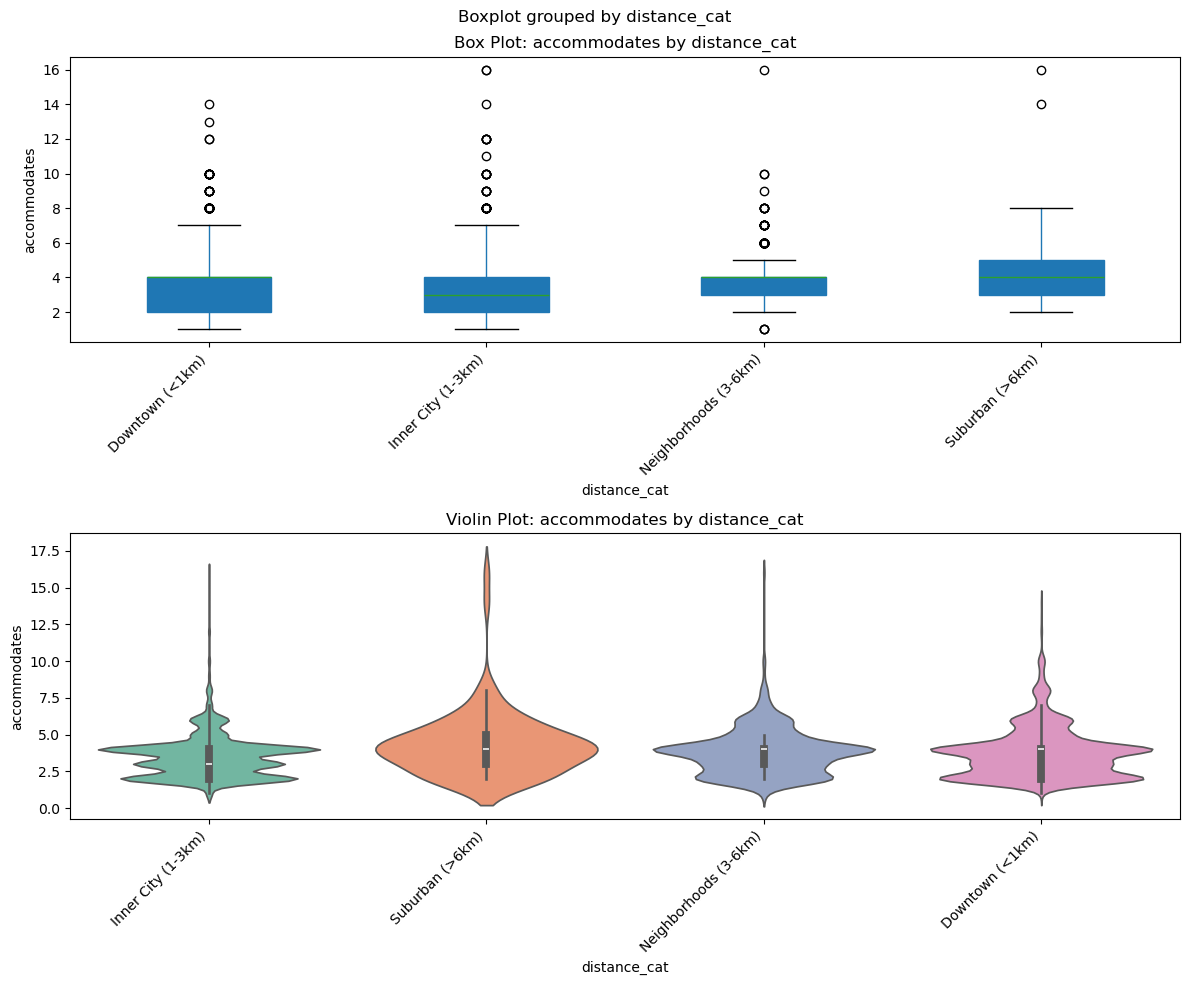

ONE-WAY ANOVA: accommodates by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   3.4970
    Median: 3.0000
    Std:    1.4634
    Min:    1.0000
    Max:    16.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   4.2747
    Median: 4.0000
    Std:    2.2164
    Min:    2.0000
    Max:    16.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   3.8065
    Median: 4.0000
    Std:    1.5436
    Min:    1.0000
    Max:    16.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   3.7379
    Median: 4.0000
    Std:    1.7034
    Min:    1.0000
    Max:    14.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      15.1257
  P-value:             0.000000
  Eta-squared (η²):    0.010
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant effect on accomm

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


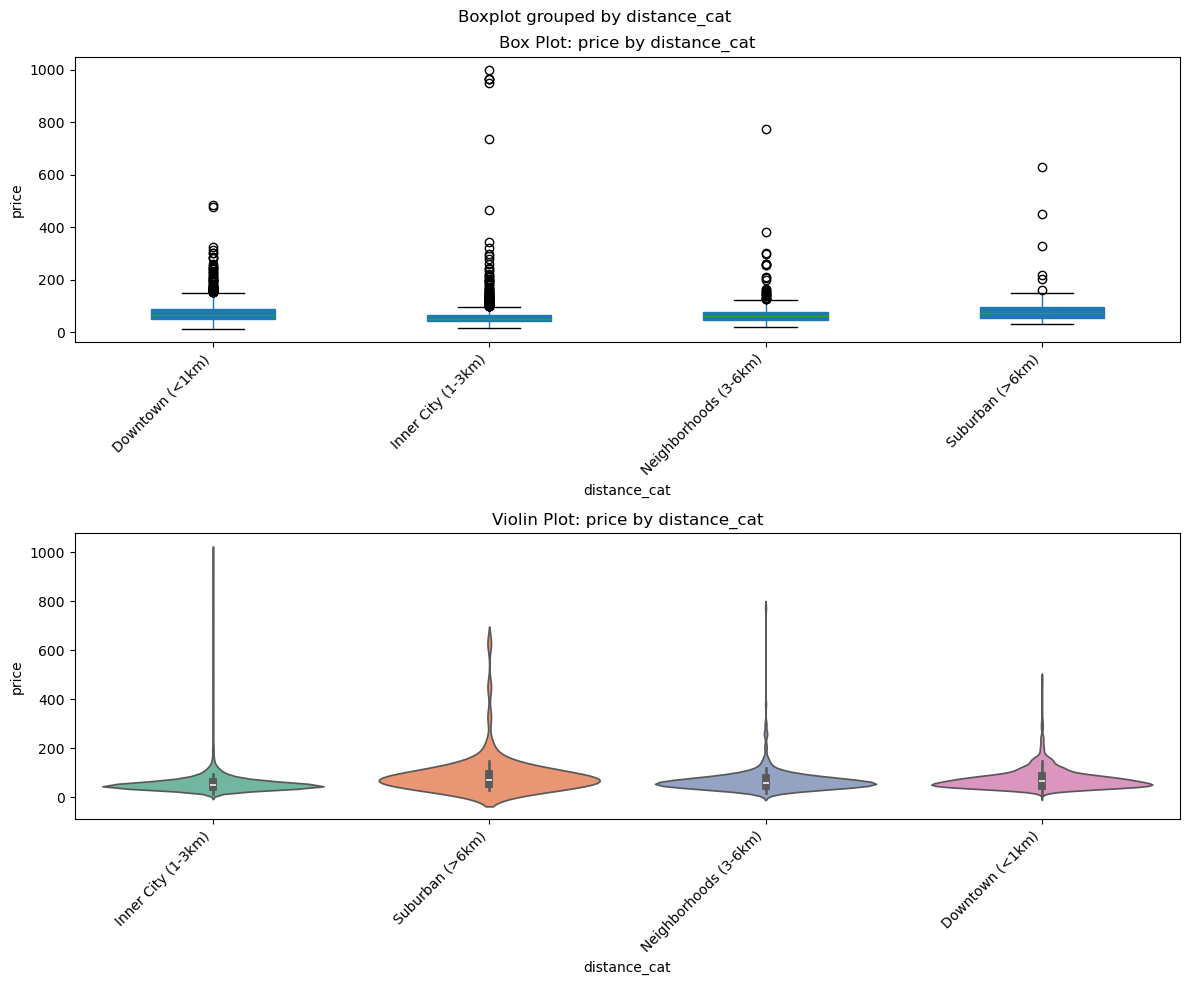

ONE-WAY ANOVA: price by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2284
    Mean:   59.1791
    Median: 50.0000
    Std:    53.4434
    Min:    16.0000
    Max:    1000.0000

  distance_cat = Suburban (>6km):
    N:      89
    Mean:   91.5618
    Median: 73.0000
    Std:    82.6885
    Min:    31.0000
    Max:    628.0000

  distance_cat = Neighborhoods (3-6km):
    N:      497
    Mean:   69.0302
    Median: 60.0000
    Std:    49.0409
    Min:    18.0000
    Max:    772.0000

  distance_cat = Downtown (<1km):
    N:      1300
    Mean:   75.9646
    Median: 66.0000
    Std:    42.3341
    Min:    10.0000
    Max:    484.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      38.8472
  P-value:             0.000000
  Eta-squared (η²):    0.027
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant ef

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


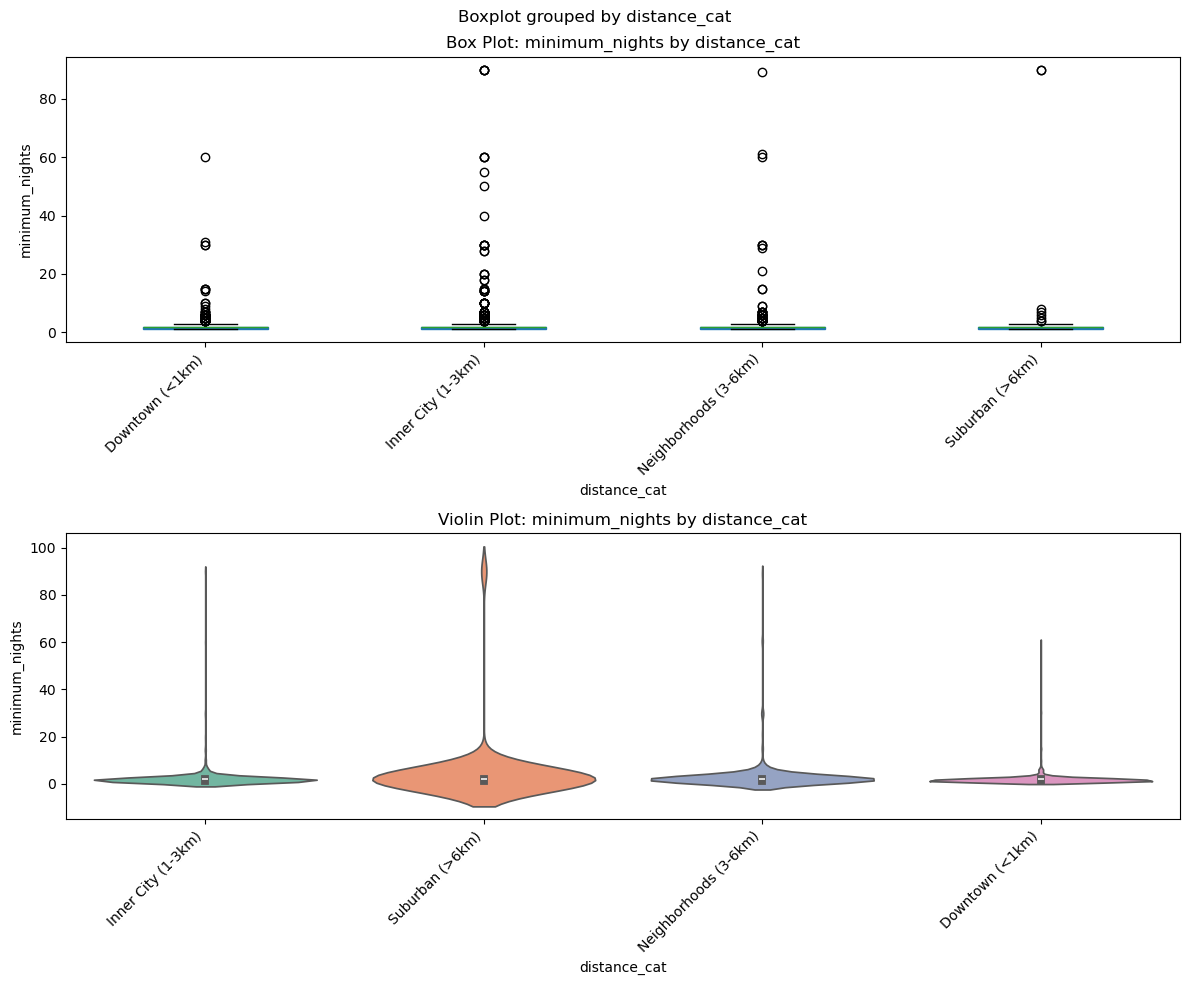

ONE-WAY ANOVA: minimum_nights by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   2.2328
    Median: 2.0000
    Std:    4.9787
    Min:    1.0000
    Max:    90.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   3.9670
    Median: 2.0000
    Std:    13.0277
    Min:    1.0000
    Max:    90.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   2.8180
    Median: 2.0000
    Std:    5.9817
    Min:    1.0000
    Max:    89.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   1.8523
    Median: 2.0000
    Std:    2.3685
    Min:    1.0000
    Max:    60.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      9.5317
  P-value:             0.000003
  Eta-squared (η²):    0.006
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000003). distance_cat has a significant effect on

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


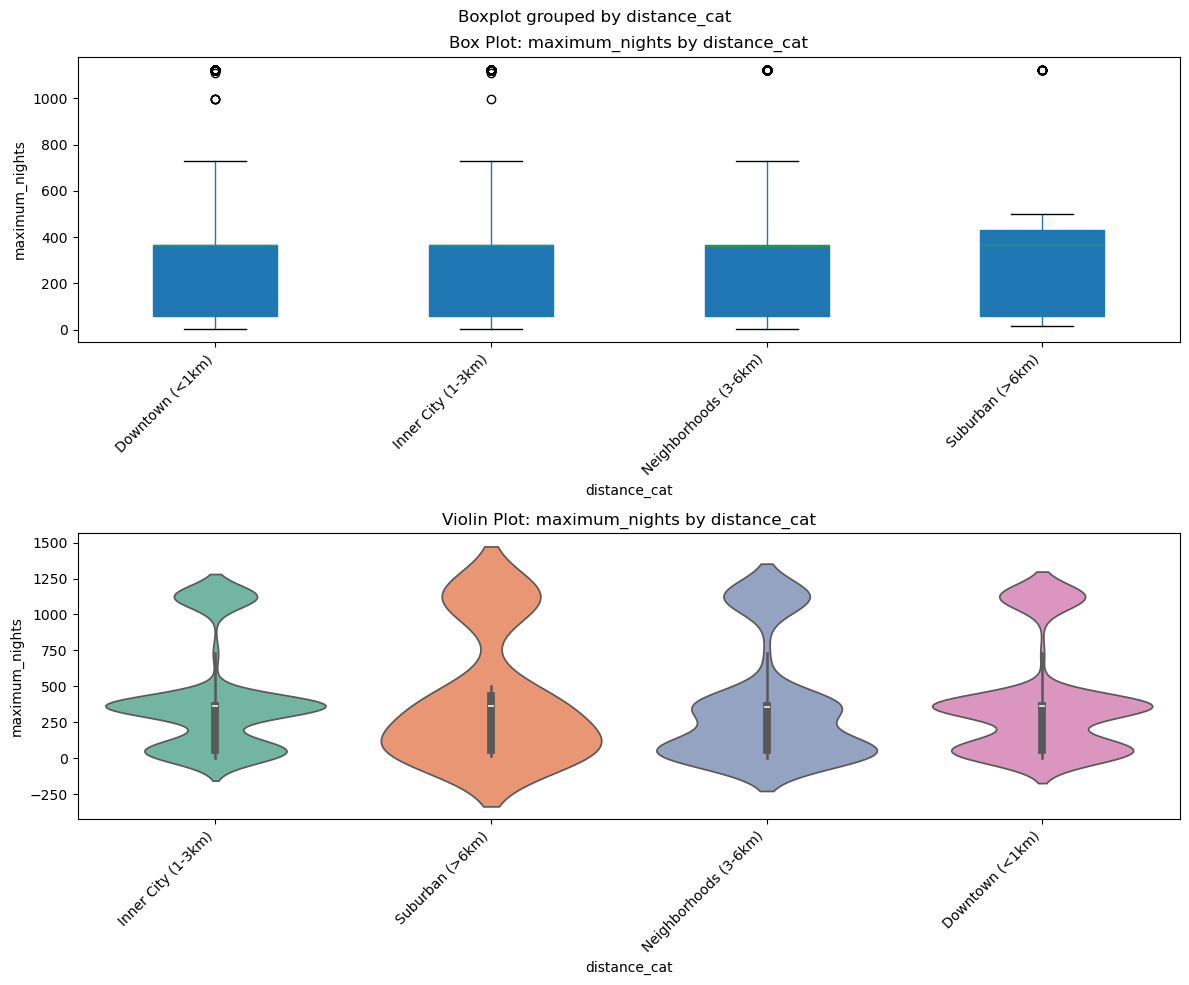

ONE-WAY ANOVA: maximum_nights by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   403.8766
    Median: 365.0000
    Std:    369.6522
    Min:    1.0000
    Max:    1125.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   406.7253
    Median: 365.0000
    Std:    429.3495
    Min:    14.0000
    Max:    1125.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   358.1073
    Median: 360.0000
    Std:    398.9093
    Min:    1.0000
    Max:    1125.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   379.0767
    Median: 365.0000
    Std:    369.7551
    Min:    1.0000
    Max:    1125.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      2.7967
  P-value:             0.038726
  Eta-squared (η²):    0.002
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.038726). distance

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


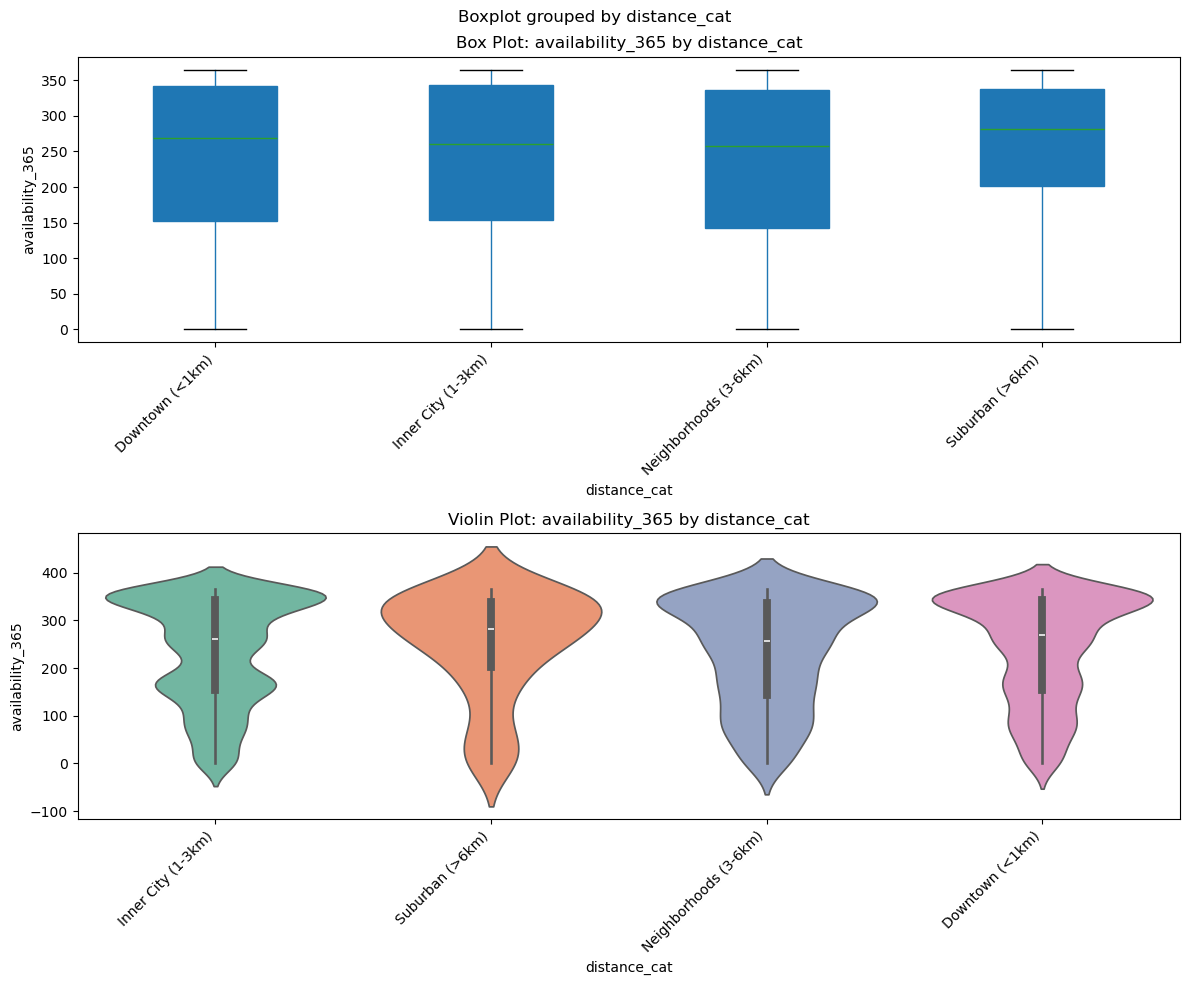

ONE-WAY ANOVA: availability_365 by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   235.4618
    Median: 260.5000
    Std:    111.9793
    Min:    0.0000
    Max:    365.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   250.2198
    Median: 281.0000
    Std:    110.7121
    Min:    0.0000
    Max:    365.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   231.6092
    Median: 257.0000
    Std:    112.8185
    Min:    0.0000
    Max:    365.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   240.9688
    Median: 269.0000
    Std:    112.3565
    Min:    0.0000
    Max:    365.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      1.5577
  P-value:             0.197532
  Eta-squared (η²):    0.001
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.197532). distance_cat does 

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


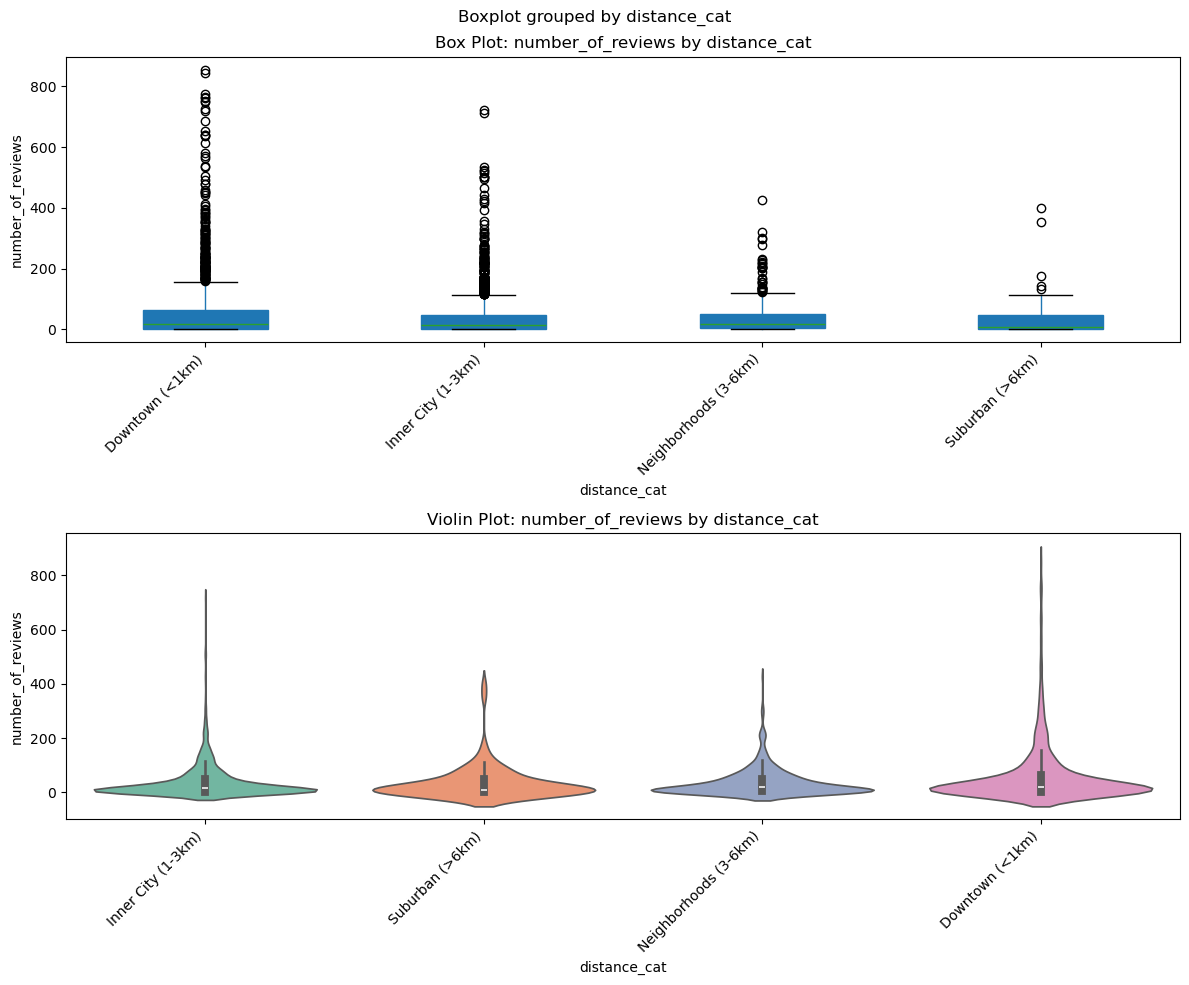

ONE-WAY ANOVA: number_of_reviews by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   39.9377
    Median: 15.0000
    Std:    65.7625
    Min:    0.0000
    Max:    721.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   35.4505
    Median: 9.0000
    Std:    63.6808
    Min:    0.0000
    Max:    398.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   37.3812
    Median: 18.0000
    Std:    52.1787
    Min:    0.0000
    Max:    427.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   60.6442
    Median: 19.0000
    Std:    110.0433
    Min:    0.0000
    Max:    855.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      21.9815
  P-value:             0.000000
  Eta-squared (η²):    0.015
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a signifi

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


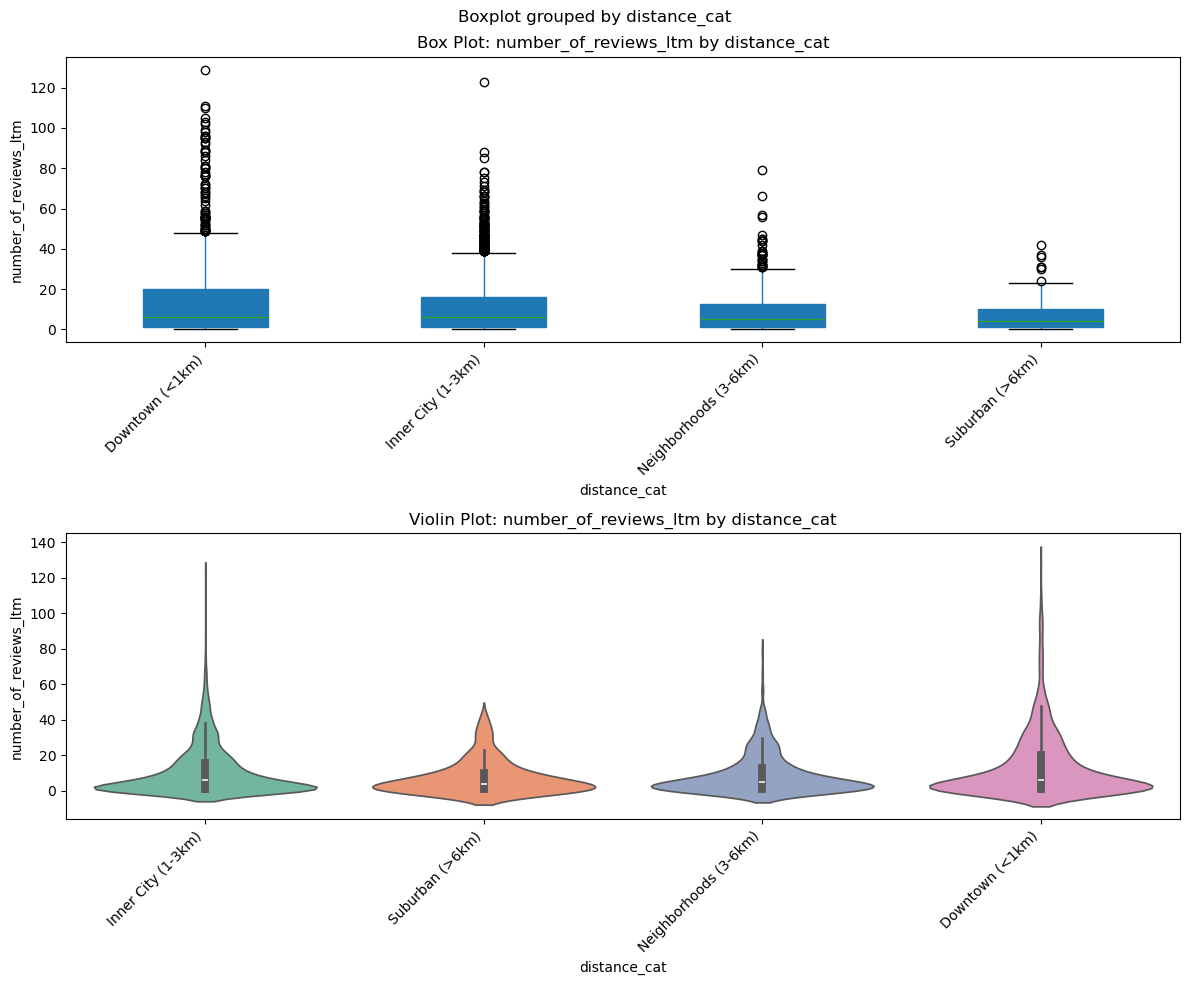

ONE-WAY ANOVA: number_of_reviews_ltm by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   11.0606
    Median: 6.0000
    Std:    13.8056
    Min:    0.0000
    Max:    123.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   7.6923
    Median: 4.0000
    Std:    9.5355
    Min:    0.0000
    Max:    42.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   9.2433
    Median: 5.0000
    Std:    11.2940
    Min:    0.0000
    Max:    79.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   13.7770
    Median: 6.0000
    Std:    18.5454
    Min:    0.0000
    Max:    129.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      16.8408
  P-value:             0.000000
  Eta-squared (η²):    0.011
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant 

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


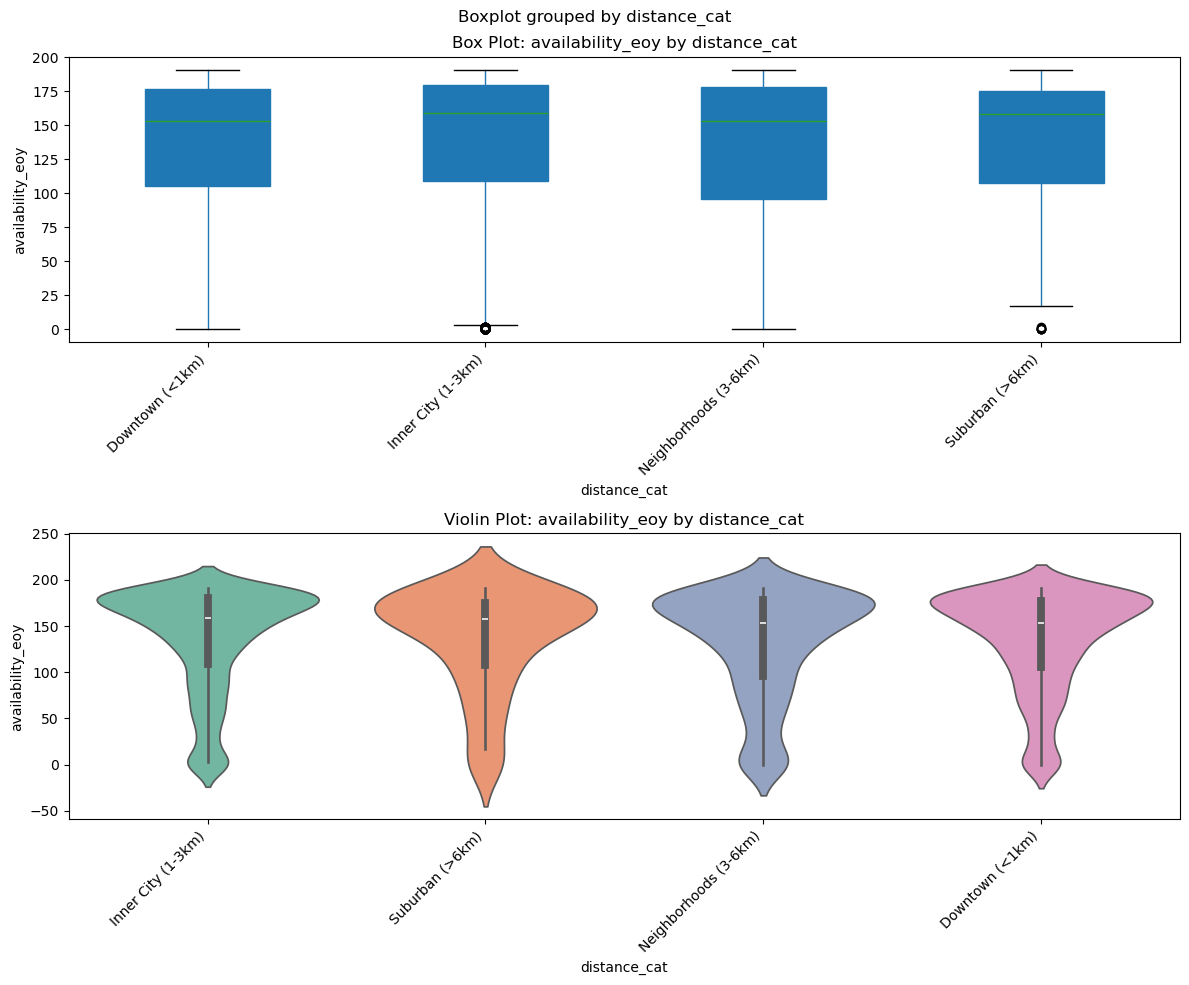

ONE-WAY ANOVA: availability_eoy by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   136.4555
    Median: 159.0000
    Std:    56.5395
    Min:    0.0000
    Max:    191.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   135.9231
    Median: 158.0000
    Std:    55.7385
    Min:    0.0000
    Max:    191.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   130.6130
    Median: 153.0000
    Std:    58.1438
    Min:    0.0000
    Max:    191.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   134.1747
    Median: 153.5000
    Std:    54.4978
    Min:    0.0000
    Max:    191.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      1.7046
  P-value:             0.163824
  Eta-squared (η²):    0.001
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.163824). distance_cat does not 

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


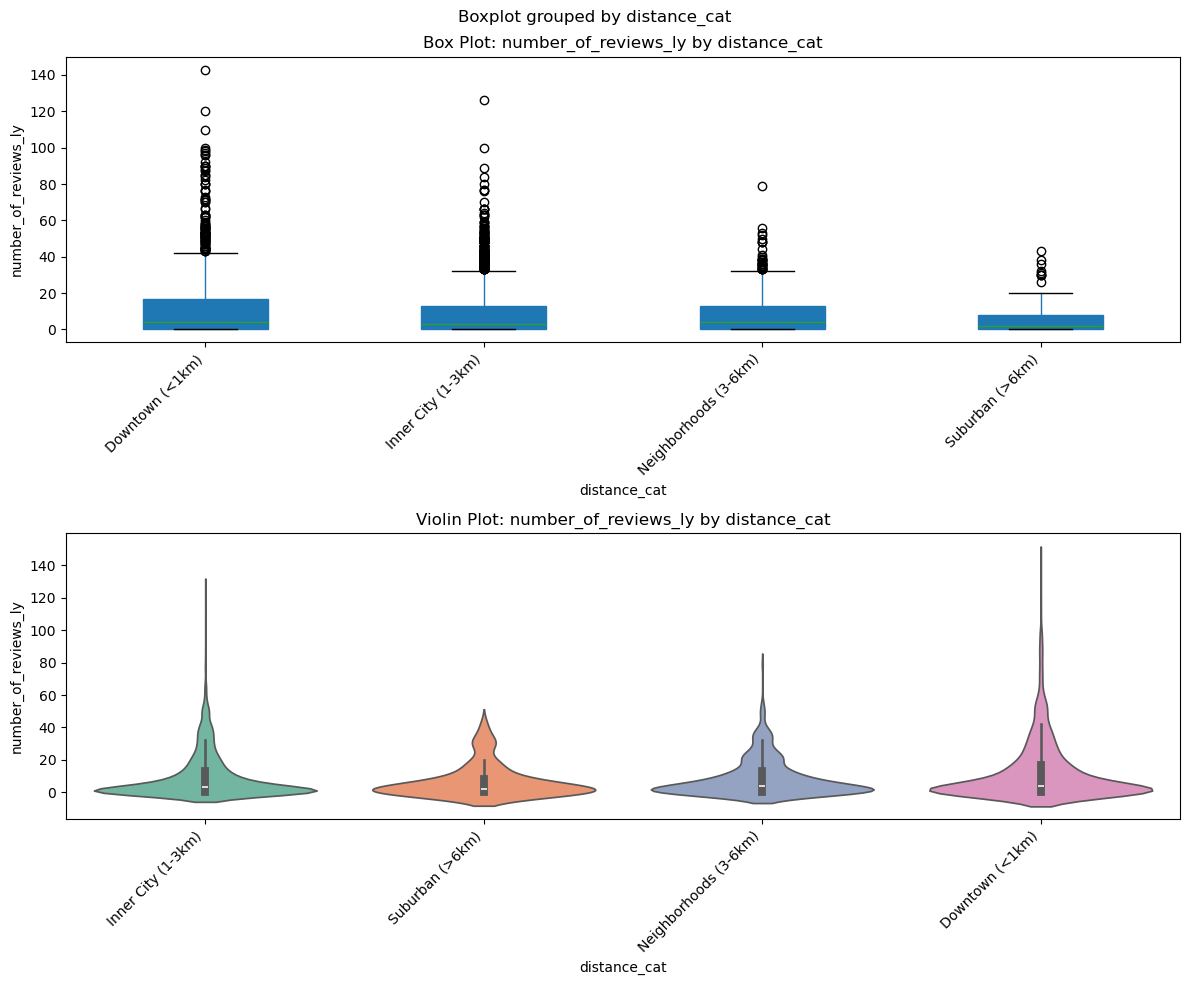

ONE-WAY ANOVA: number_of_reviews_ly by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   9.6166
    Median: 3.0000
    Std:    13.9156
    Min:    0.0000
    Max:    126.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   7.0440
    Median: 2.0000
    Std:    10.2132
    Min:    0.0000
    Max:    43.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   8.9981
    Median: 4.0000
    Std:    11.5970
    Min:    0.0000
    Max:    79.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   12.6129
    Median: 4.0000
    Std:    18.5181
    Min:    0.0000
    Max:    143.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      14.8655
  P-value:             0.000000
  Eta-squared (η²):    0.010
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant e

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


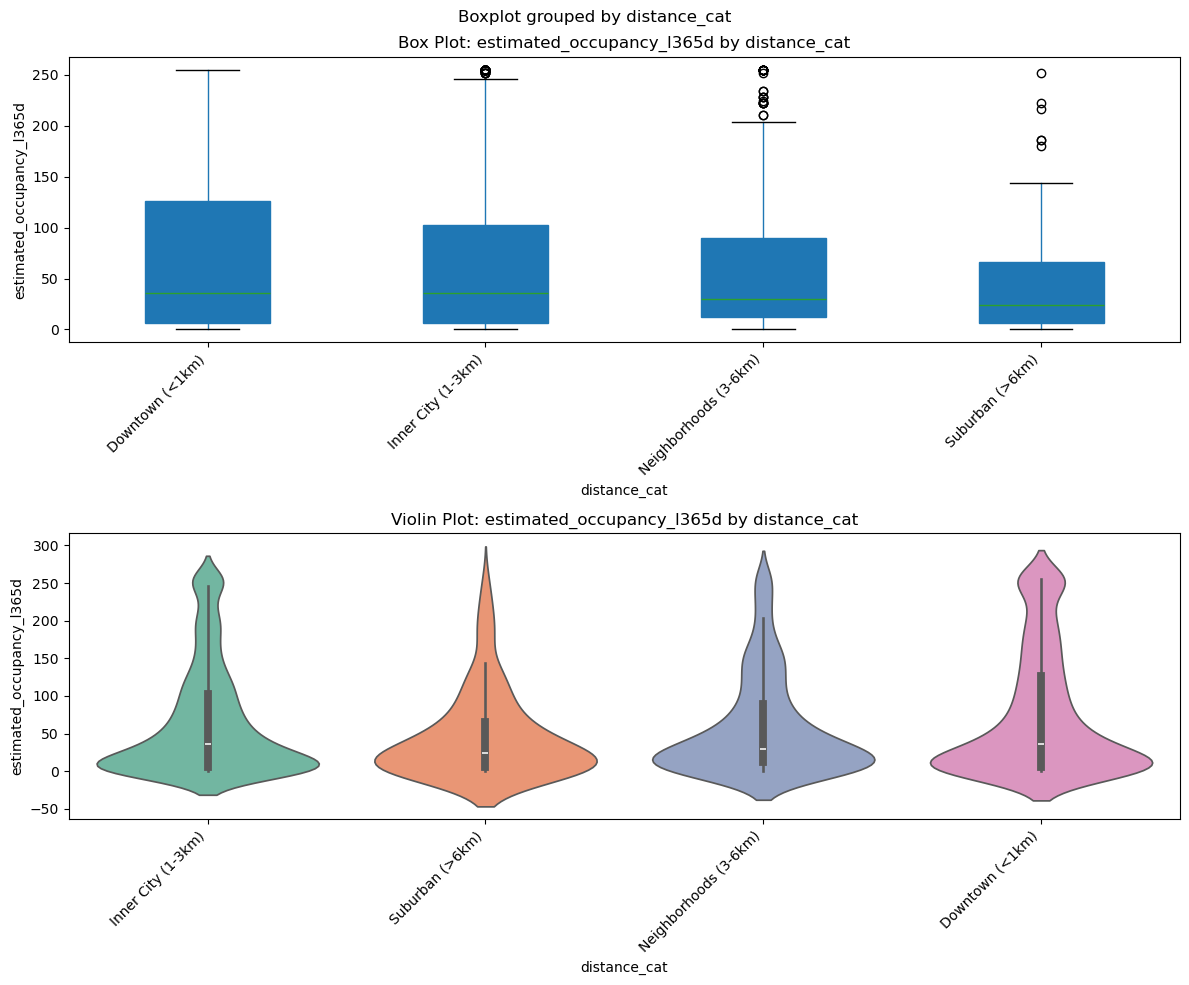

ONE-WAY ANOVA: estimated_occupancy_l365d by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   65.1137
    Median: 36.0000
    Std:    73.6602
    Min:    0.0000
    Max:    255.0000

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   46.7253
    Median: 24.0000
    Std:    57.4205
    Min:    0.0000
    Max:    252.0000

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   58.5307
    Median: 30.0000
    Std:    66.0528
    Min:    0.0000
    Max:    255.0000

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   74.1939
    Median: 36.0000
    Std:    82.3878
    Min:    0.0000
    Max:    255.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      9.1350
  P-value:             0.000005
  Eta-squared (η²):    0.006
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000005). distance_cat h

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


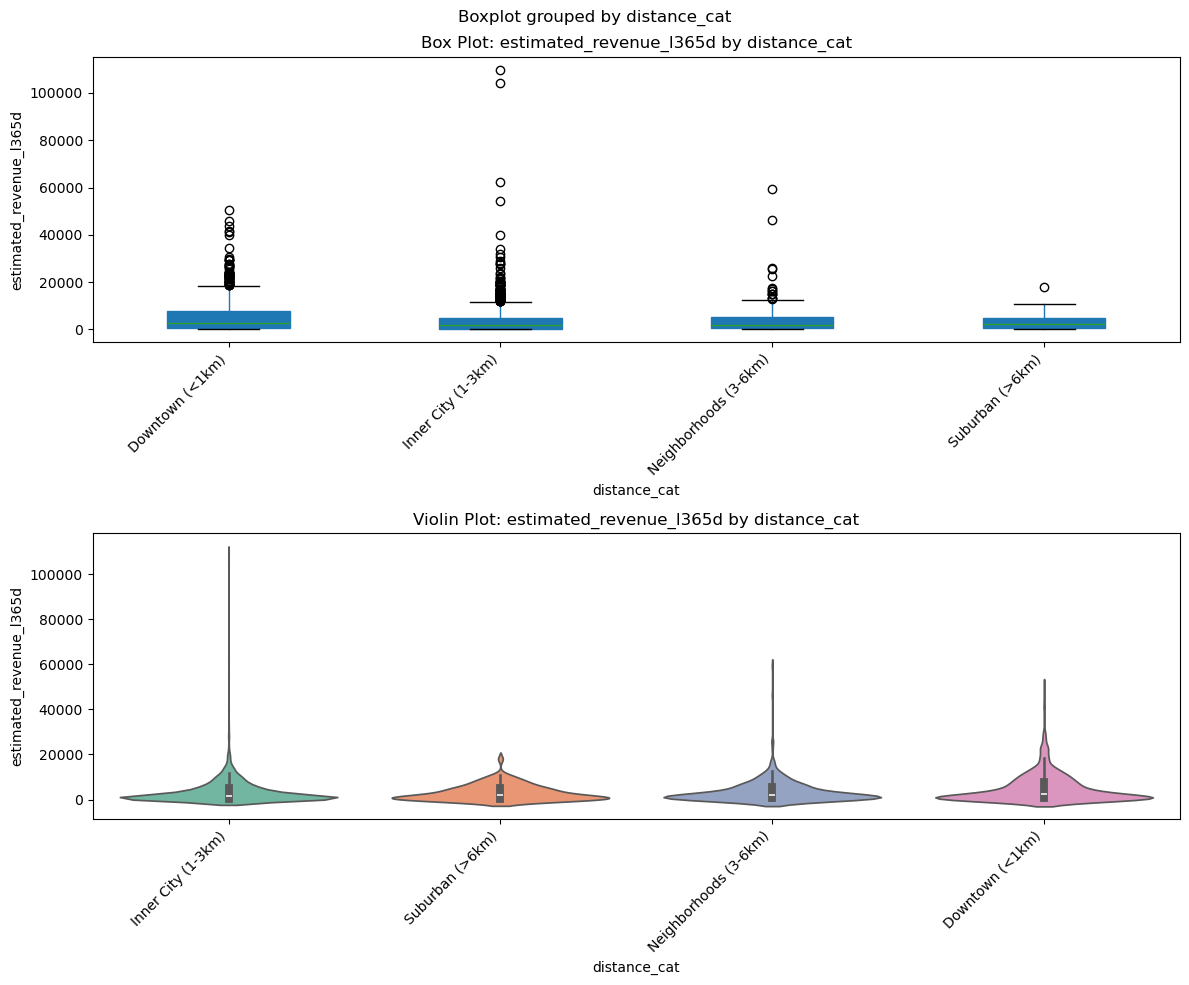

ONE-WAY ANOVA: estimated_revenue_l365d by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2284
    Mean:   3534.9264
    Median: 1787.0000
    Std:    5532.7739
    Min:    0.0000
    Max:    109896.0000

  distance_cat = Suburban (>6km):
    N:      89
    Mean:   3095.9775
    Median: 2112.0000
    Std:    3411.5257
    Min:    0.0000
    Max:    18018.0000

  distance_cat = Neighborhoods (3-6km):
    N:      497
    Mean:   3620.2555
    Median: 1944.0000
    Std:    5021.0289
    Min:    0.0000
    Max:    59280.0000

  distance_cat = Downtown (<1km):
    N:      1300
    Mean:   5031.8177
    Median: 2604.0000
    Std:    6345.1236
    Min:    0.0000
    Max:    50430.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      20.6943
  P-value:             0.000000
  Eta-squared (η²):    0.015
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


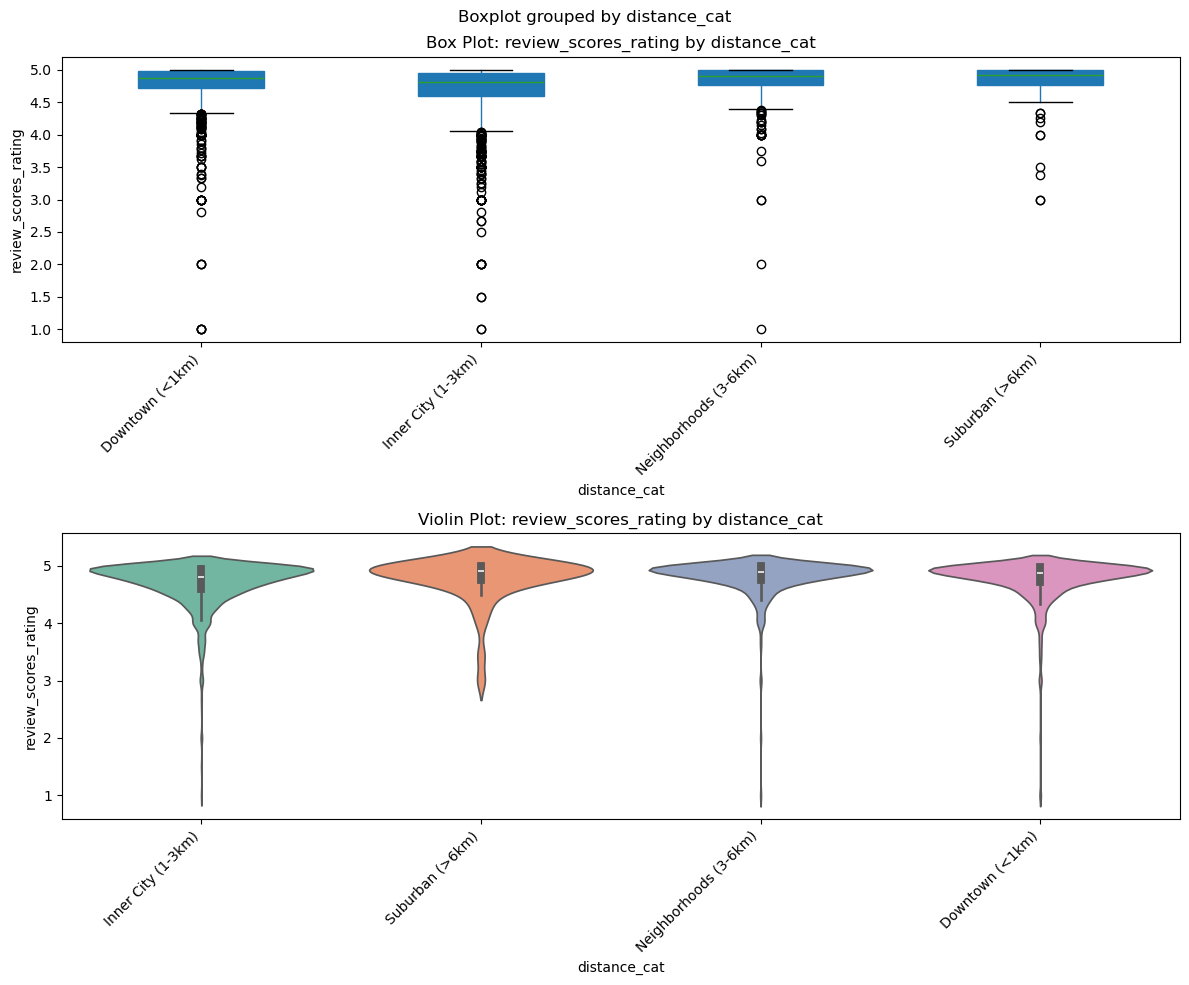

ONE-WAY ANOVA: review_scores_rating by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2069
    Mean:   4.6918
    Median: 4.8100
    Std:    0.4046
    Min:    1.0000
    Max:    5.0000

  distance_cat = Suburban (>6km):
    N:      86
    Mean:   4.7605
    Median: 4.9150
    Std:    0.4123
    Min:    3.0000
    Max:    5.0000

  distance_cat = Neighborhoods (3-6km):
    N:      476
    Mean:   4.8100
    Median: 4.9000
    Std:    0.3291
    Min:    1.0000
    Max:    5.0000

  distance_cat = Downtown (<1km):
    N:      1287
    Mean:   4.7594
    Median: 4.8700
    Std:    0.3946
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      15.6428
  P-value:             0.000000
  Eta-squared (η²):    0.012
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant effect on re

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


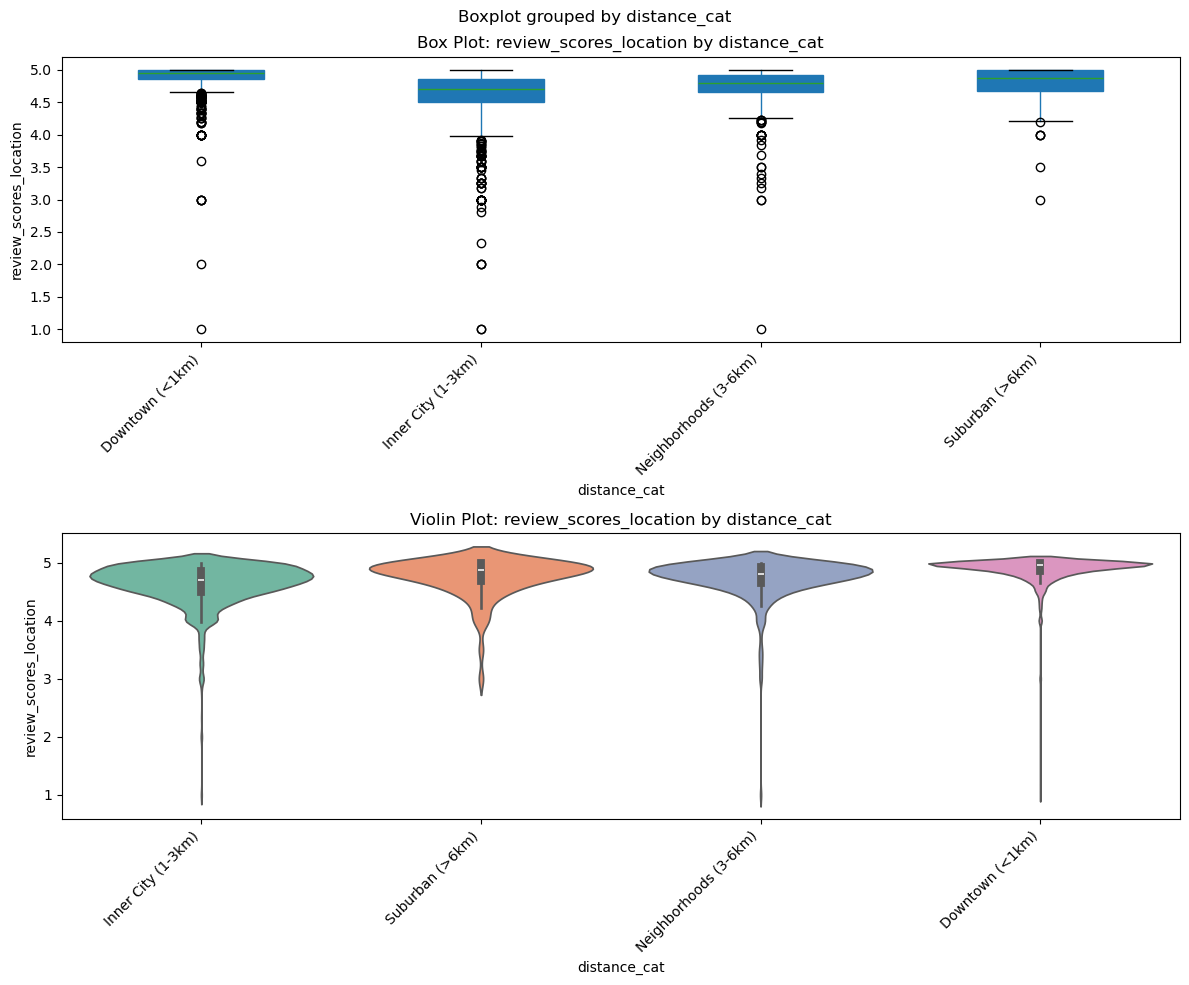

ONE-WAY ANOVA: review_scores_location by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2069
    Mean:   4.6268
    Median: 4.7000
    Std:    0.3679
    Min:    1.0000
    Max:    5.0000

  distance_cat = Suburban (>6km):
    N:      86
    Mean:   4.7463
    Median: 4.8650
    Std:    0.3382
    Min:    3.0000
    Max:    5.0000

  distance_cat = Neighborhoods (3-6km):
    N:      476
    Mean:   4.7311
    Median: 4.8000
    Std:    0.3392
    Min:    1.0000
    Max:    5.0000

  distance_cat = Downtown (<1km):
    N:      1287
    Mean:   4.8809
    Median: 4.9500
    Std:    0.2359
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      160.8896
  P-value:             0.000000
  Eta-squared (η²):    0.110
  Effect size:         Medium effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant effect o

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


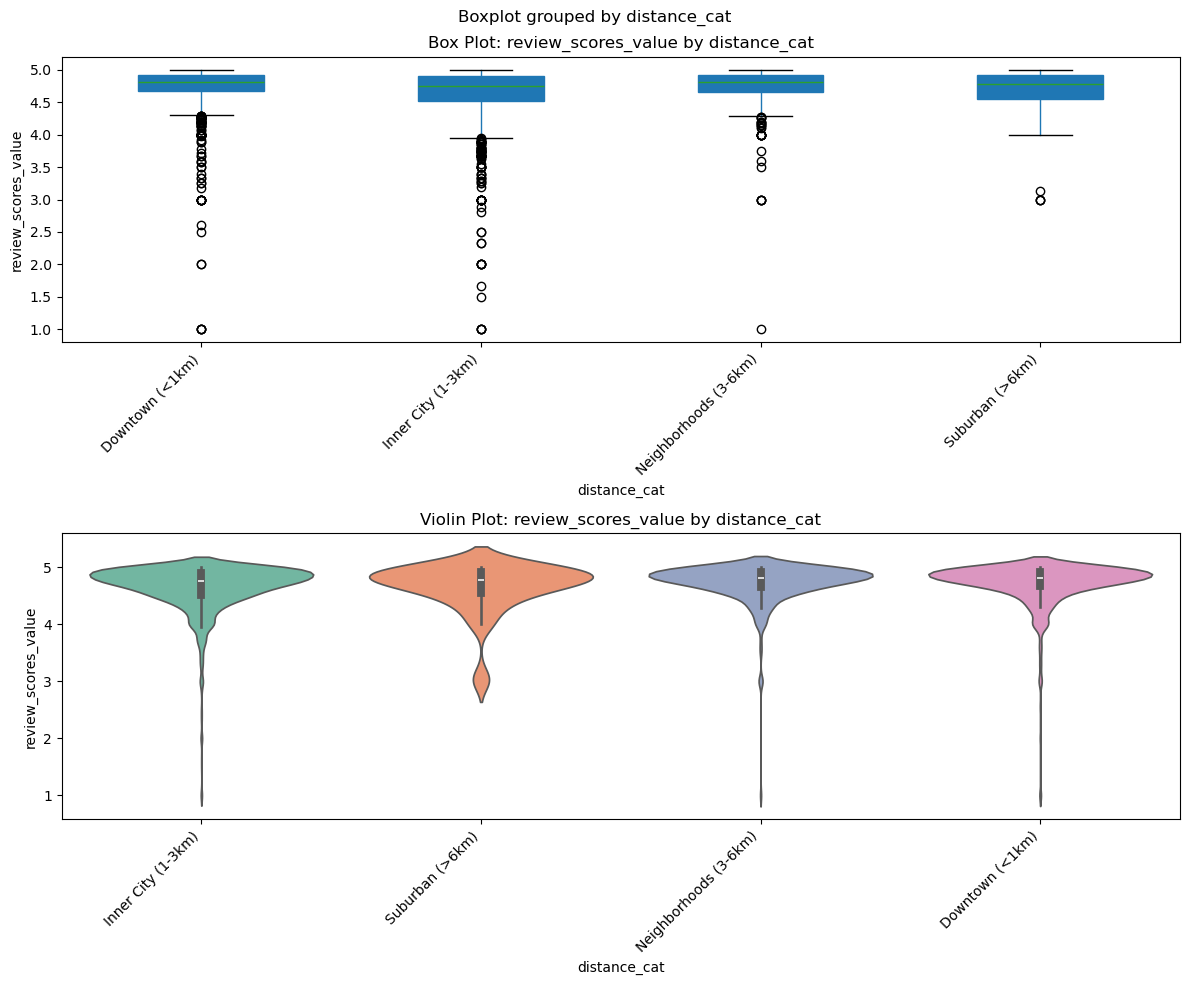

ONE-WAY ANOVA: review_scores_value by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2069
    Mean:   4.6474
    Median: 4.7500
    Std:    0.4175
    Min:    1.0000
    Max:    5.0000

  distance_cat = Suburban (>6km):
    N:      86
    Mean:   4.6445
    Median: 4.7750
    Std:    0.4421
    Min:    3.0000
    Max:    5.0000

  distance_cat = Neighborhoods (3-6km):
    N:      476
    Mean:   4.7318
    Median: 4.8100
    Std:    0.3336
    Min:    1.0000
    Max:    5.0000

  distance_cat = Downtown (<1km):
    N:      1287
    Mean:   4.7129
    Median: 4.8100
    Std:    0.3931
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      10.3093
  P-value:             0.000001
  Eta-squared (η²):    0.008
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000001). distance_cat has a significant effect o

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


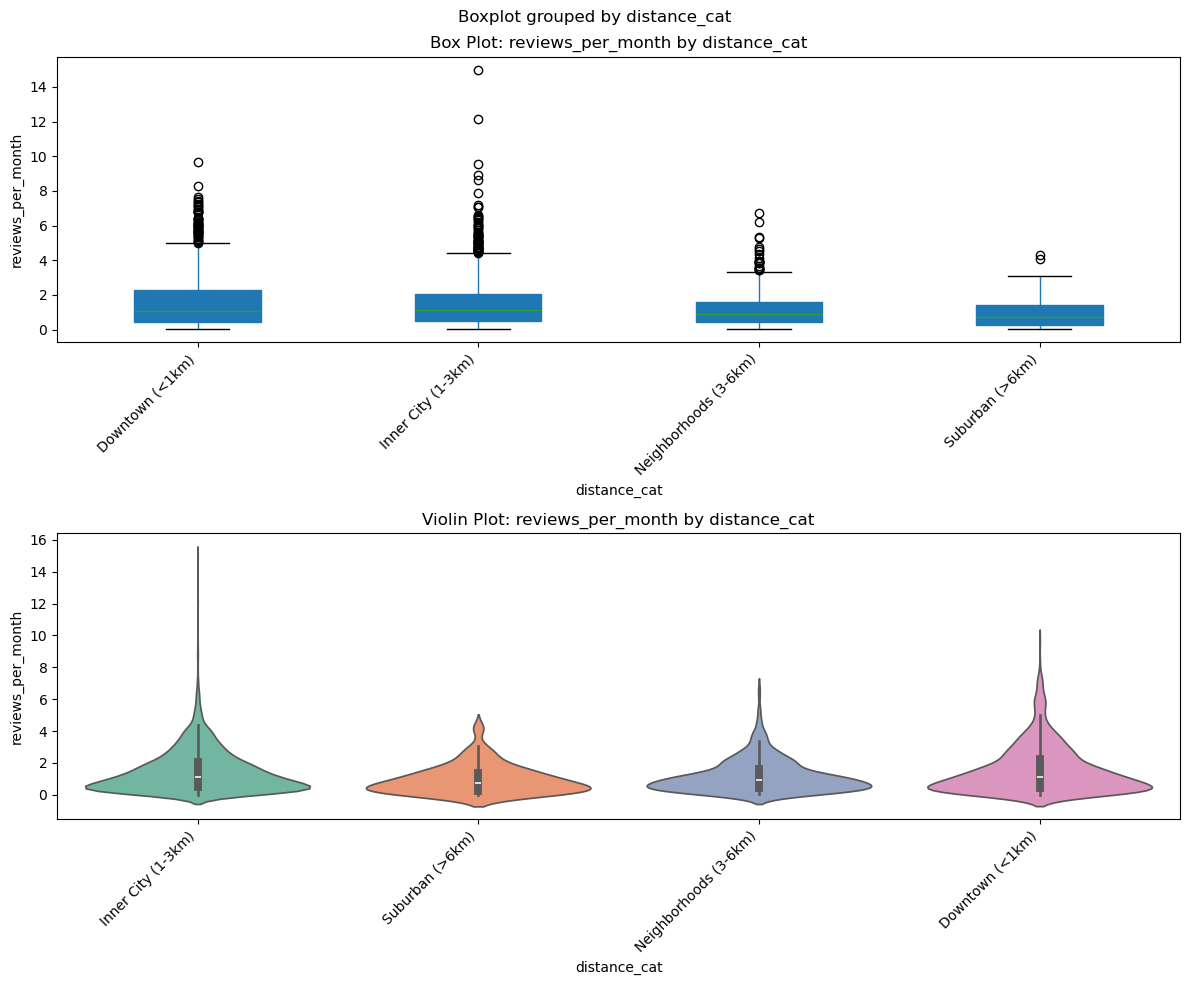

ONE-WAY ANOVA: reviews_per_month by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2069
    Mean:   1.4896
    Median: 1.1300
    Std:    1.3383
    Min:    0.0100
    Max:    15.0000

  distance_cat = Suburban (>6km):
    N:      86
    Mean:   0.9791
    Median: 0.7150
    Std:    0.9024
    Min:    0.0200
    Max:    4.3100

  distance_cat = Neighborhoods (3-6km):
    N:      476
    Mean:   1.1957
    Median: 0.9050
    Std:    1.0326
    Min:    0.0300
    Max:    6.7100

  distance_cat = Downtown (<1km):
    N:      1287
    Mean:   1.5726
    Median: 1.1000
    Std:    1.4978
    Min:    0.0100
    Max:    9.6500

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      12.9086
  P-value:             0.000000
  Eta-squared (η²):    0.010
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant effect on

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


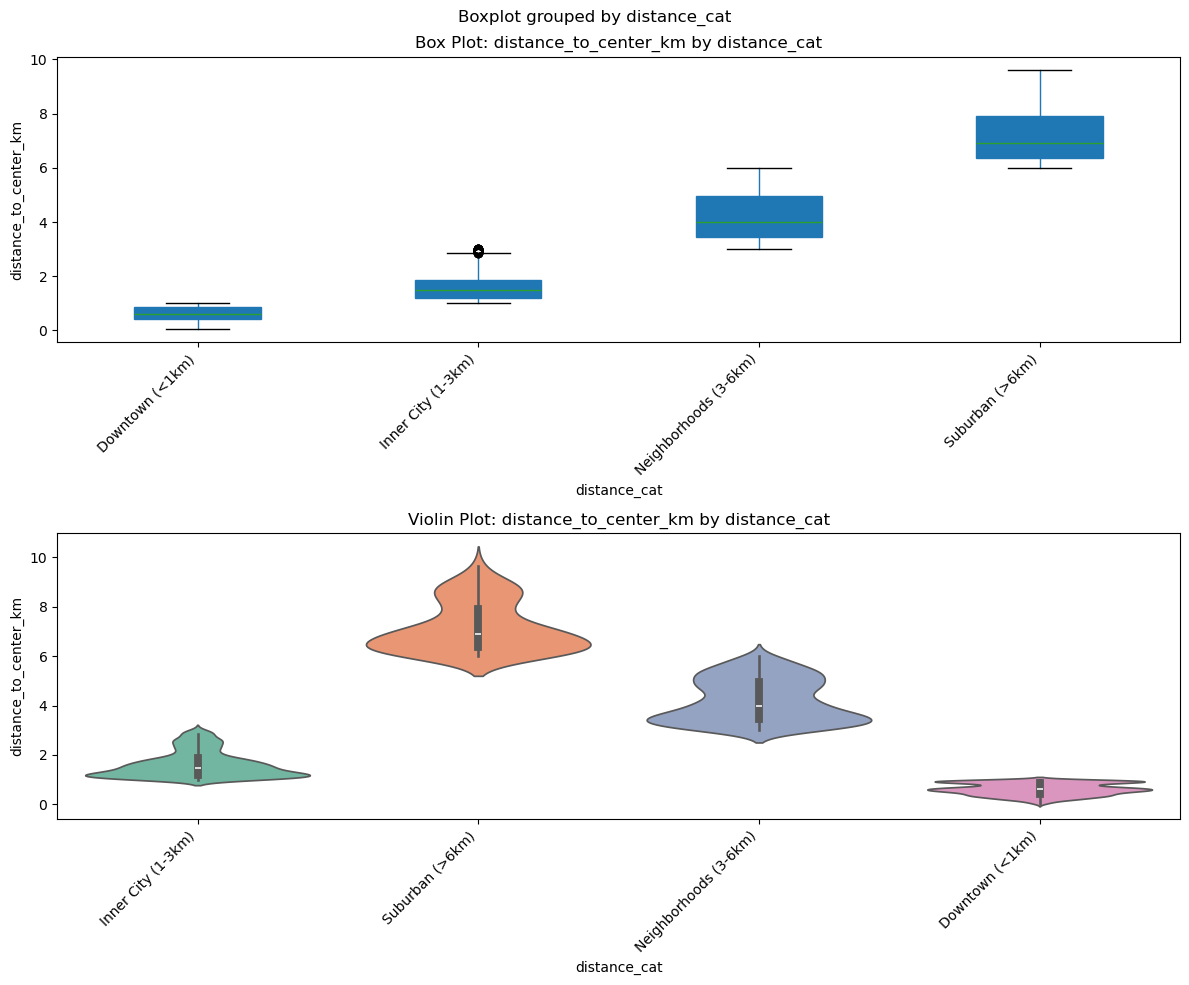

ONE-WAY ANOVA: distance_to_center_km by distance_cat

Descriptive Statistics by Group:

  distance_cat = Inner City (1-3km):
    N:      2358
    Mean:   1.6202
    Median: 1.4784
    Std:    0.5211
    Min:    1.0000
    Max:    2.9978

  distance_cat = Suburban (>6km):
    N:      91
    Mean:   7.1452
    Median: 6.9031
    Std:    0.9901
    Min:    6.0033
    Max:    9.6283

  distance_cat = Neighborhoods (3-6km):
    N:      522
    Mean:   4.1965
    Median: 3.9986
    Std:    0.8666
    Min:    3.0021
    Max:    5.9833

  distance_cat = Downtown (<1km):
    N:      1408
    Mean:   0.6182
    Median: 0.6170
    Std:    0.2430
    Min:    0.0367
    Max:    0.9993

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      9232.5282
  P-value:             0.000000
  Eta-squared (η²):    0.864
  Effect size:         Large effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). distance_cat has a significant effect on

In [31]:
for col in df_5.drop(columns=['id', 'host_id', 'latitude', 'longitude']).select_dtypes(include=np.number).columns:
    analyze_categorical_numerical(df_5['distance_cat'], df_5[col])

ana

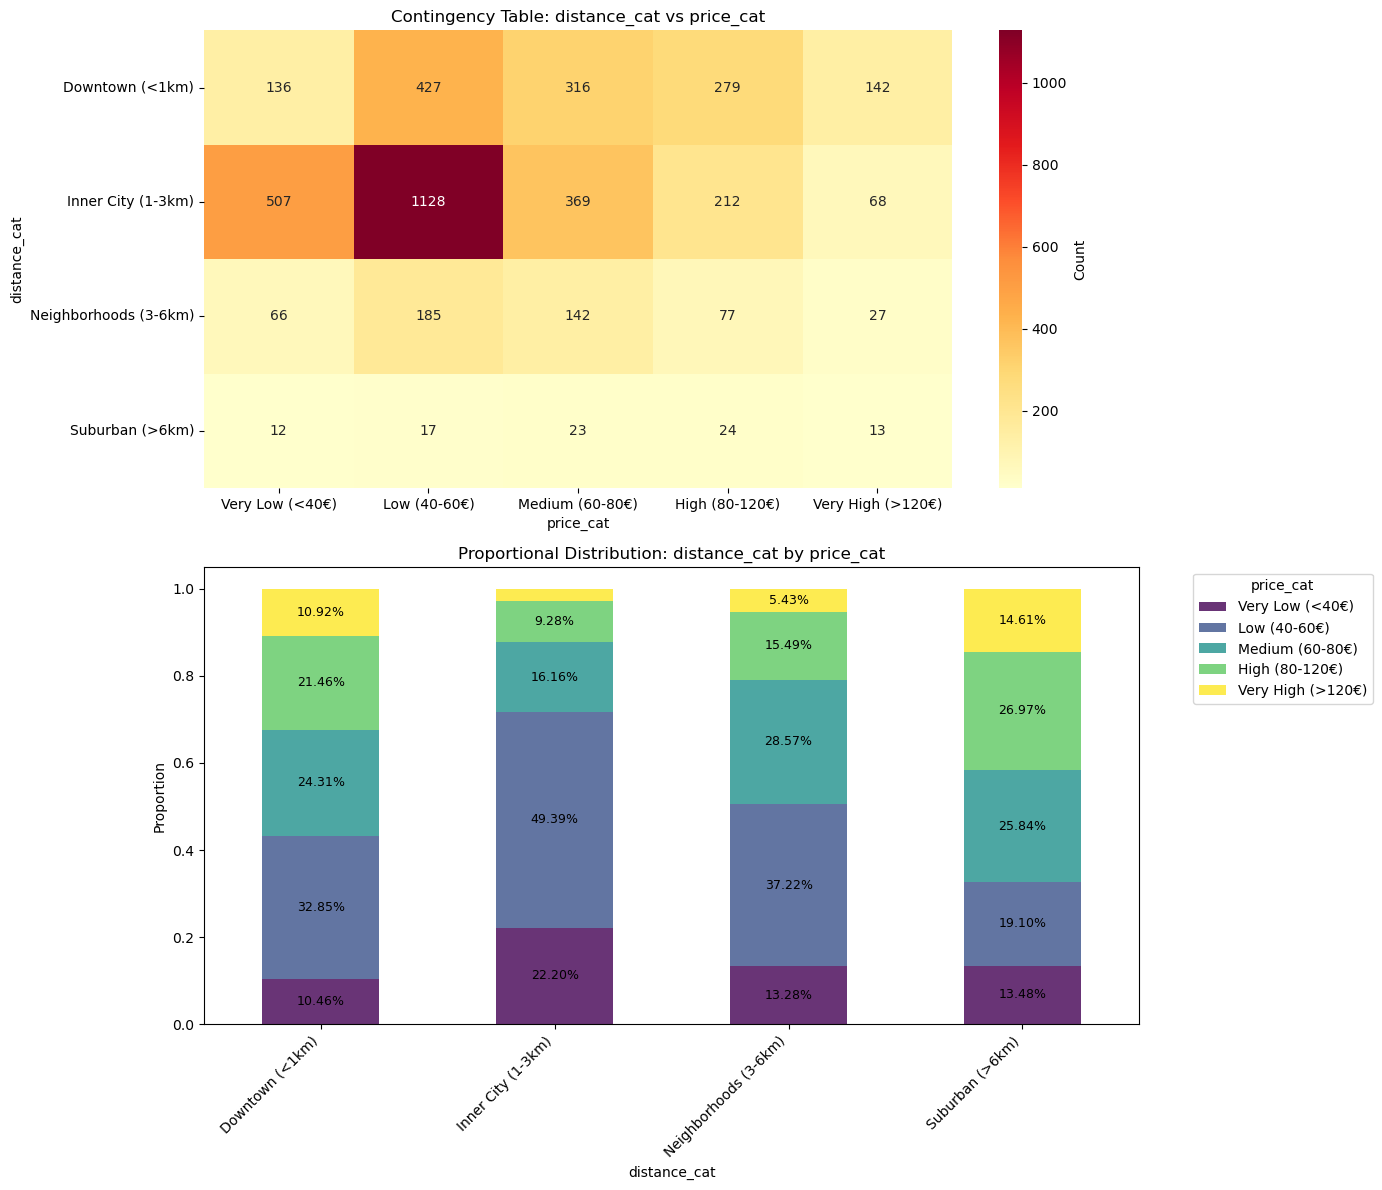

CHI-SQUARE TEST OF INDEPENDENCE: distance_cat vs price_cat

Contingency Table:
price_cat              Very Low (<40€)  Low (40-60€)  Medium (60-80€)  \
distance_cat                                                            
Downtown (<1km)                    136           427              316   
Inner City (1-3km)                 507          1128              369   
Neighborhoods (3-6km)               66           185              142   
Suburban (>6km)                     12            17               23   

price_cat              High (80-120€)  Very High (>120€)  
distance_cat                                              
Downtown (<1km)                   279                142  
Inner City (1-3km)                212                 68  
Neighborhoods (3-6km)              77                 27  
Suburban (>6km)                    24                 13  

Test Statistics:
  Chi-square statistic: 385.5534
  Degrees of freedom:   12
  P-value:              0.000000
  Cramér's V:    

In [33]:
analyze_categorical_categorical(df_5['distance_cat'], df_5['price_cat'])

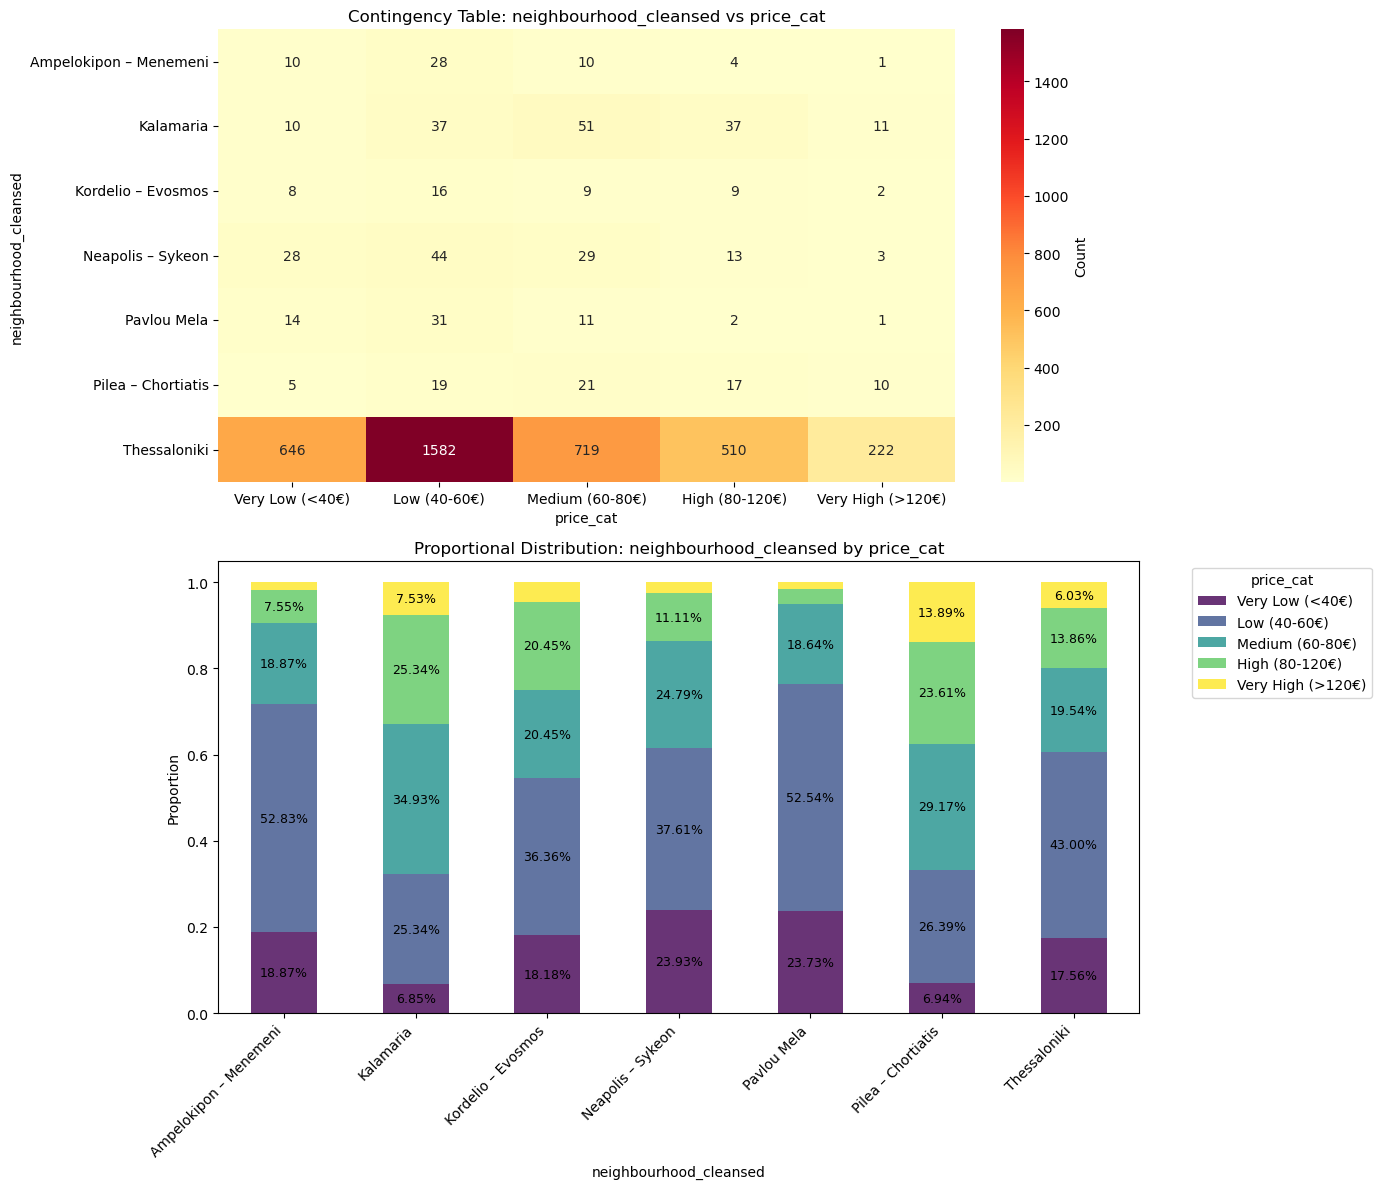

CHI-SQUARE TEST OF INDEPENDENCE: neighbourhood_cleansed vs price_cat

Contingency Table:
price_cat               Very Low (<40€)  Low (40-60€)  Medium (60-80€)  \
neighbourhood_cleansed                                                   
Ampelokipon – Menemeni               10            28               10   
Kalamaria                            10            37               51   
Kordelio – Evosmos                    8            16                9   
Neapolis – Sykeon                    28            44               29   
Pavlou Mela                          14            31               11   
Pilea – Chortiatis                    5            19               21   
Thessaloniki                        646          1582              719   

price_cat               High (80-120€)  Very High (>120€)  
neighbourhood_cleansed                                     
Ampelokipon – Menemeni               4                  1  
Kalamaria                           37                 11  
Kord

In [34]:
analyze_categorical_categorical(df_5['neighbourhood_cleansed'], df_5['price_cat'])

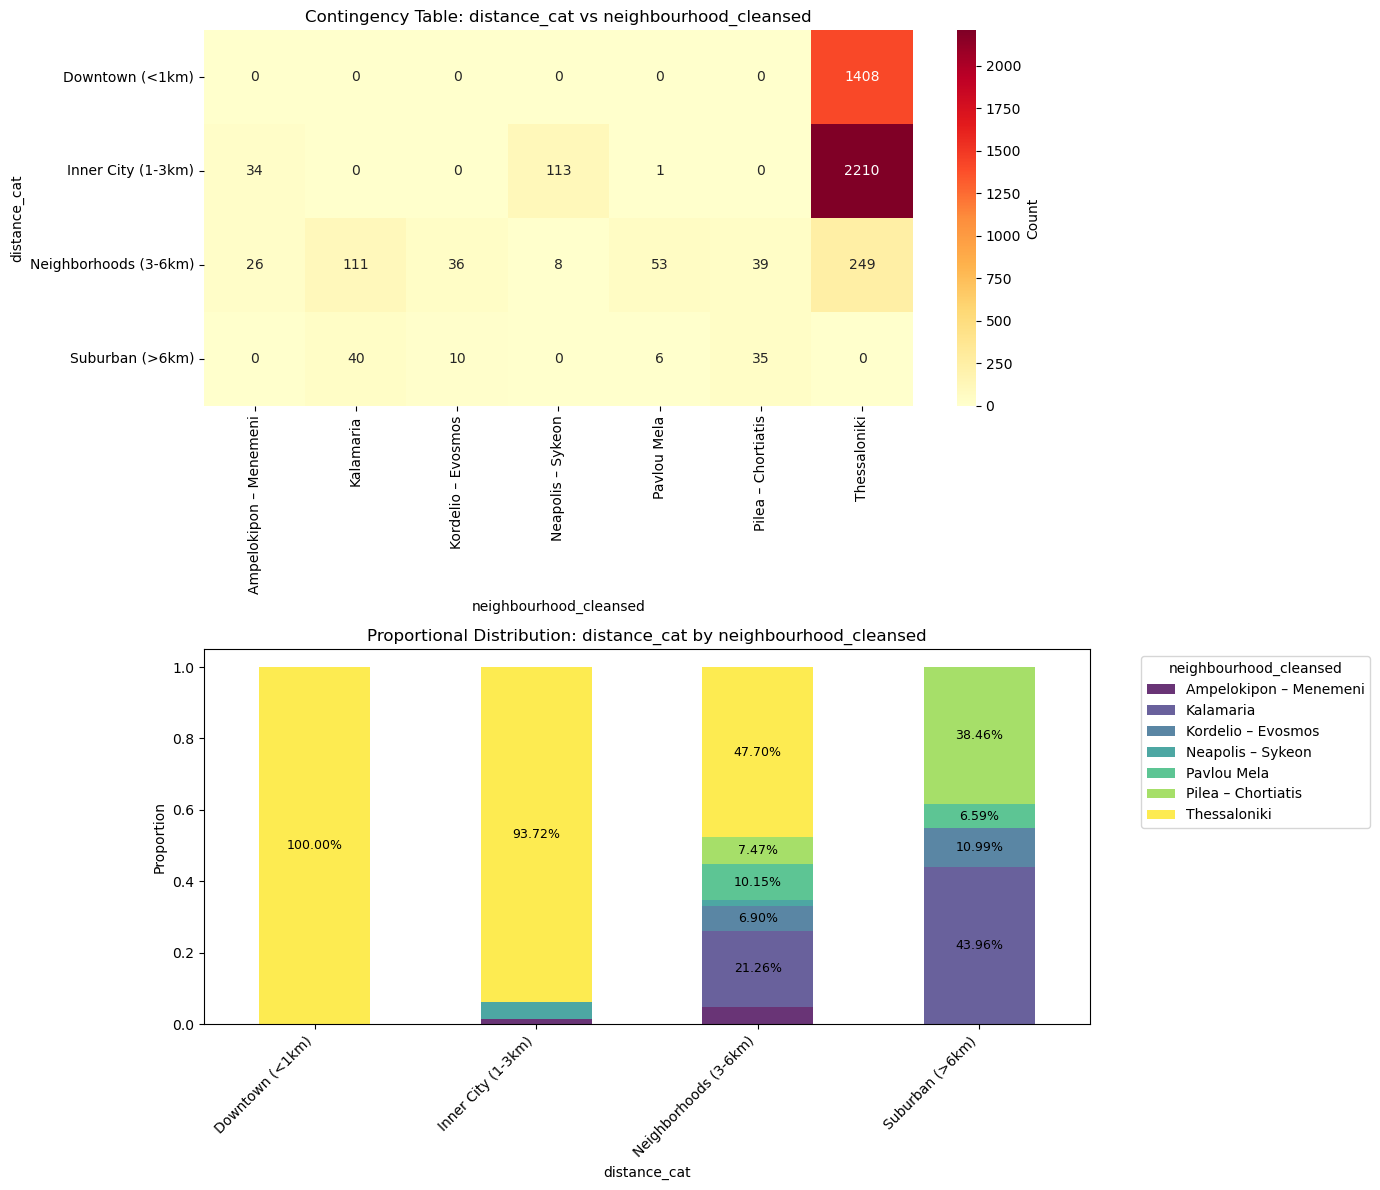

CHI-SQUARE TEST OF INDEPENDENCE: distance_cat vs neighbourhood_cleansed

Contingency Table:
neighbourhood_cleansed  Ampelokipon – Menemeni  Kalamaria  Kordelio – Evosmos  \
distance_cat                                                                    
Downtown (<1km)                              0          0                   0   
Inner City (1-3km)                          34          0                   0   
Neighborhoods (3-6km)                       26        111                  36   
Suburban (>6km)                              0         40                  10   

neighbourhood_cleansed  Neapolis – Sykeon  Pavlou Mela  Pilea – Chortiatis  \
distance_cat                                                                 
Downtown (<1km)                         0            0                   0   
Inner City (1-3km)                    113            1                   0   
Neighborhoods (3-6km)                   8           53                  39   
Suburban (>6km)                

In [35]:
analyze_categorical_categorical(df_5['distance_cat'], df_5['neighbourhood_cleansed'])

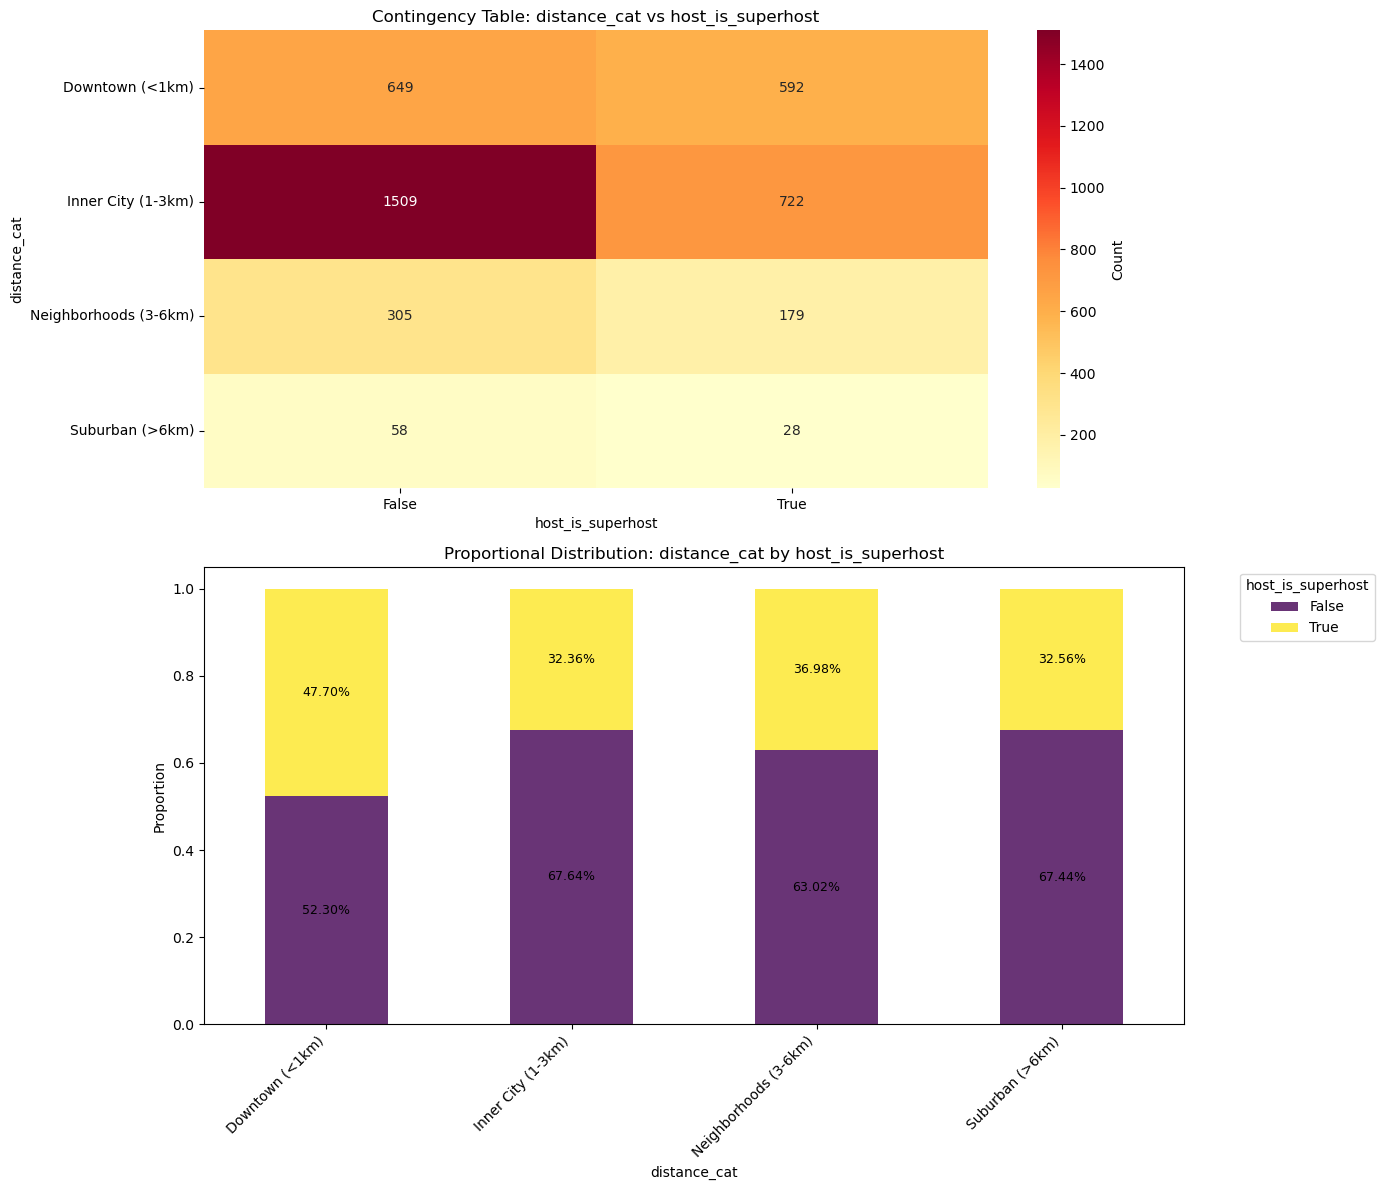

CHI-SQUARE TEST OF INDEPENDENCE: distance_cat vs host_is_superhost

Contingency Table:
host_is_superhost      False  True 
distance_cat                       
Downtown (<1km)          649    592
Inner City (1-3km)      1509    722
Neighborhoods (3-6km)    305    179
Suburban (>6km)           58     28

Test Statistics:
  Chi-square statistic: 81.0637
  Degrees of freedom:   3
  P-value:              0.000000
  Cramér's V:           0.142
  Effect size:          Weak association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000000). distance_cat and host_is_superhost are related. Weak association (Cramér's V = 0.142).


In [36]:
analyze_categorical_categorical(df_5['distance_cat'], df_5['host_is_superhost'])

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


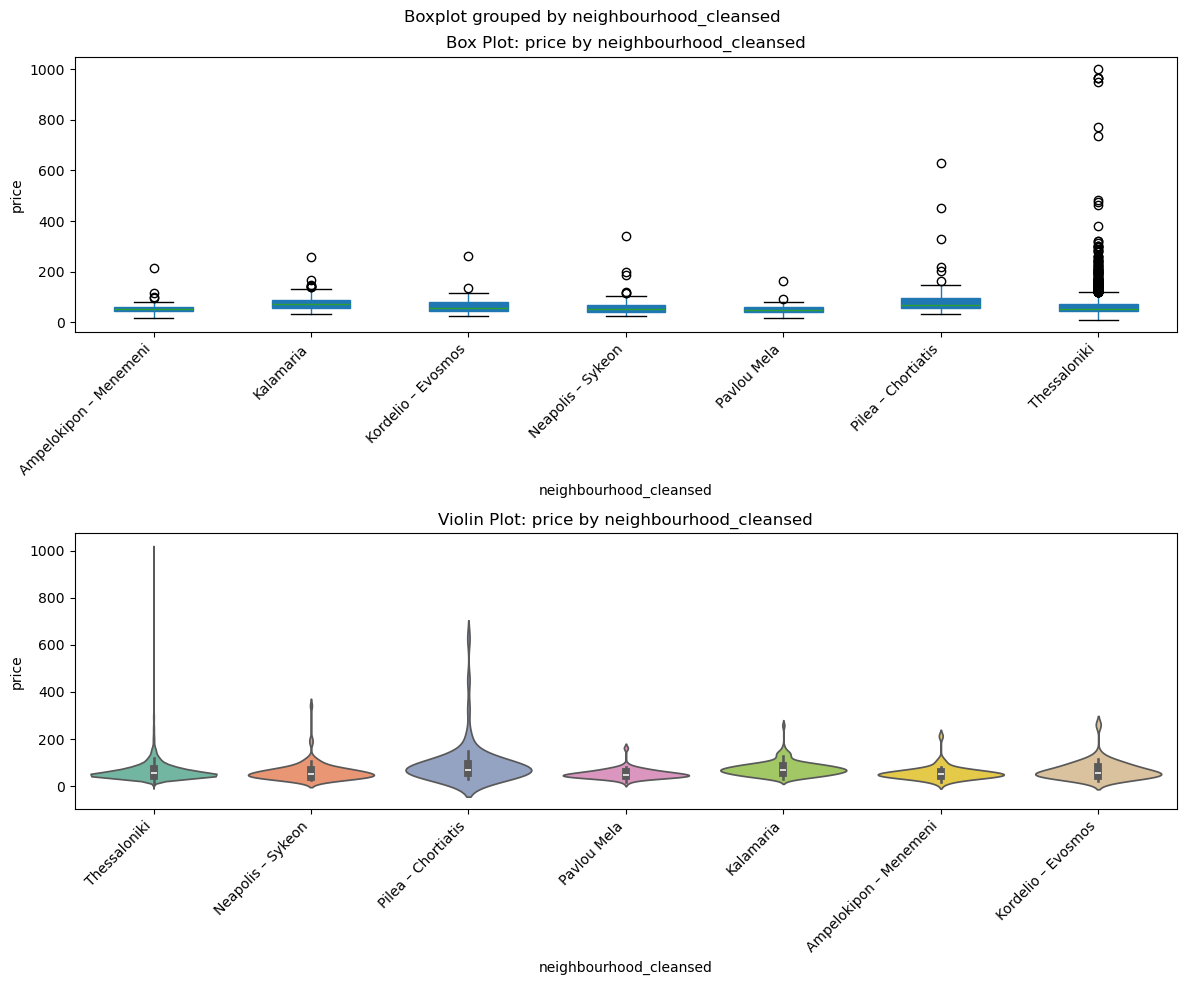

ONE-WAY ANOVA: price by neighbourhood_cleansed

Descriptive Statistics by Group:

  neighbourhood_cleansed = Thessaloniki:
    N:      3679
    Mean:   65.8962
    Median: 54.0000
    Std:    51.7443
    Min:    10.0000
    Max:    1000.0000

  neighbourhood_cleansed = Neapolis – Sykeon:
    N:      117
    Mean:   61.1538
    Median: 53.0000
    Std:    37.9227
    Min:    25.0000
    Max:    342.0000

  neighbourhood_cleansed = Pilea – Chortiatis:
    N:      72
    Mean:   94.1250
    Median: 69.0000
    Std:    90.0152
    Min:    32.0000
    Max:    628.0000

  neighbourhood_cleansed = Pavlou Mela:
    N:      59
    Mean:   53.0847
    Median: 49.0000
    Std:    20.4638
    Min:    18.0000
    Max:    162.0000

  neighbourhood_cleansed = Kalamaria:
    N:      146
    Mean:   74.7945
    Median: 70.5000
    Std:    29.9296
    Min:    32.0000
    Max:    258.0000

  neighbourhood_cleansed = Ampelokipon – Menemeni:
    N:      53
    Mean:   56.1321
    Median: 51.0000
    Std:  

{'test_name': 'One-Way ANOVA',
 'test_statistic': np.float64(5.488170563449089),
 'p_value': np.float64(1.1380073976067889e-05),
 'effect_size': np.float64(0.007847850427689628),
 'effect_measure': 'Eta-squared (η²)',
 'effect_interpretation': 'Negligible effect',
 'is_significant': np.True_,
 'n_groups': 7,
 'groups': array(['Thessaloniki', 'Neapolis – Sykeon', 'Pilea – Chortiatis',
        'Pavlou Mela', 'Kalamaria', 'Ampelokipon – Menemeni',
        'Kordelio – Evosmos'], dtype=object),
 'interpretation': 'SIGNIFICANT difference detected (p=0.000011). neighbourhood_cleansed has a significant effect on price. Negligible effect (Eta-squared (η²) = 0.008).',
 'categorical_variable': 'neighbourhood_cleansed',
 'numerical_variable': 'price'}

In [37]:
analyze_categorical_numerical(df_5['neighbourhood_cleansed'], df_5['price'])

In [38]:
df_5.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean()

/tmp/ipykernel_1898/3362350920.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_5.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean()


latitude  longitude
neighbourhood_cleansed                      
Ampelokipon – Menemeni  40.651775  22.923662
Kalamaria               40.580362  22.956179
Kordelio – Evosmos      40.668378  22.909385
Neapolis – Sykeon       40.647592  22.951070
Pavlou Mela             40.669892  22.937703
Pilea – Chortiatis      40.600408  23.004977
Thessaloniki            40.631846  22.946211

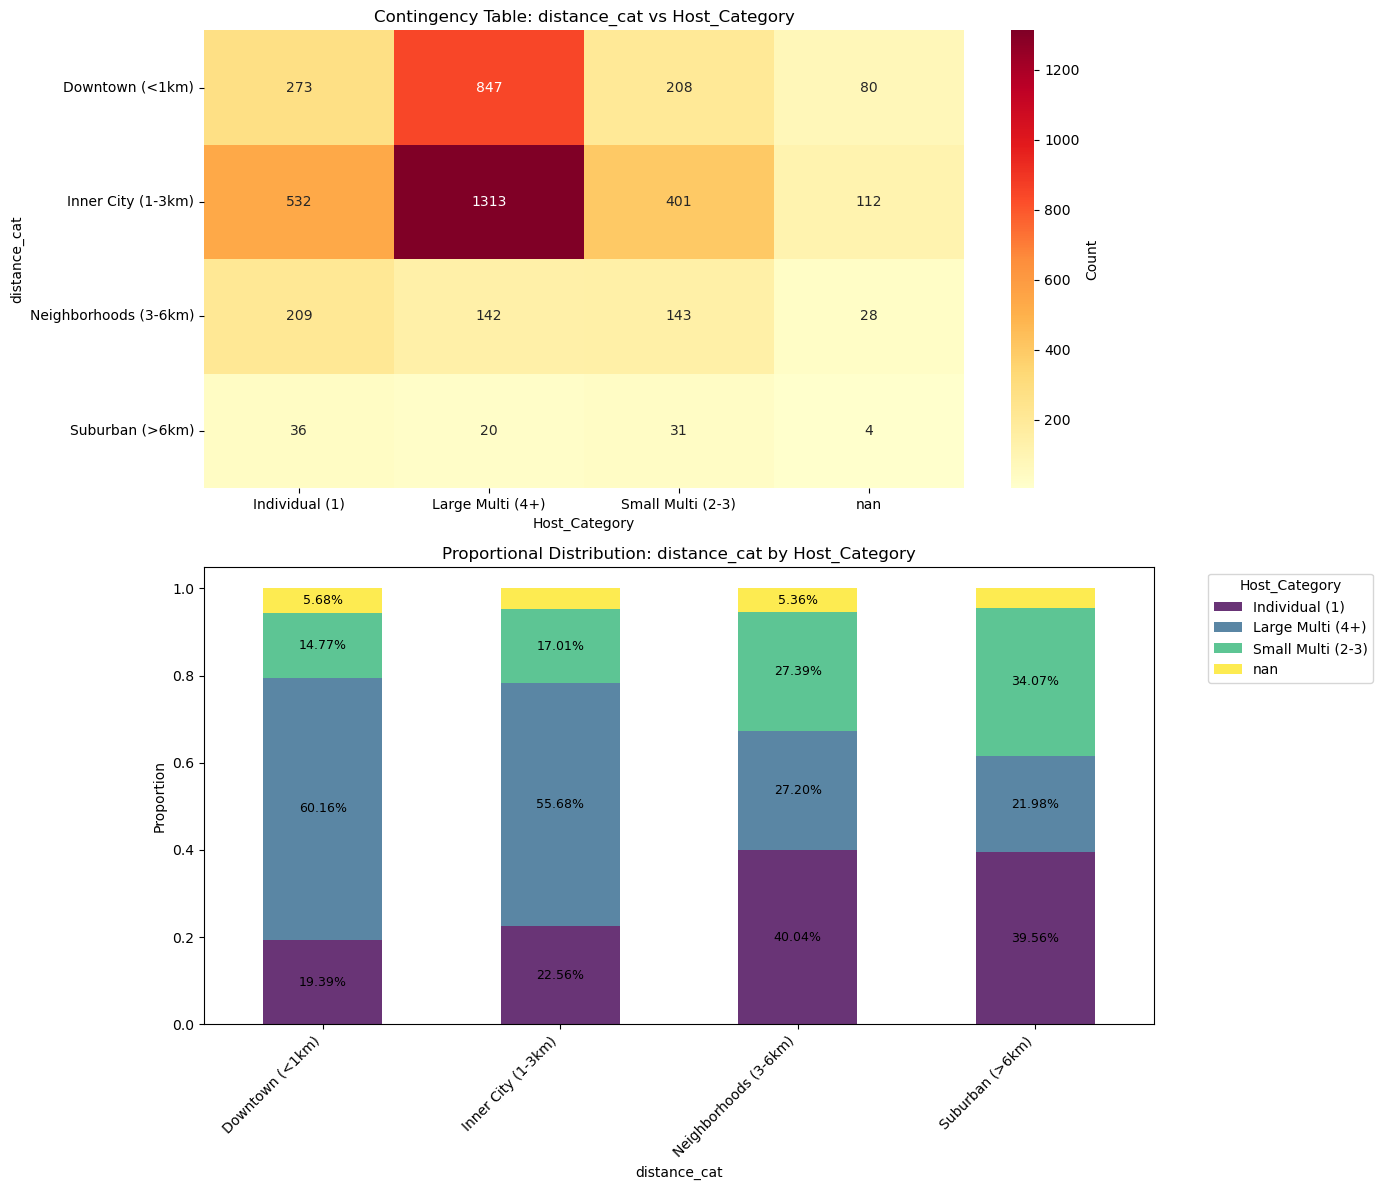

CHI-SQUARE TEST OF INDEPENDENCE: distance_cat vs Host_Category

Contingency Table:
Host_Category          Individual (1)  Large Multi (4+)  Small Multi (2-3)  \
distance_cat                                                                 
Downtown (<1km)                   273               847                208   
Inner City (1-3km)                532              1313                401   
Neighborhoods (3-6km)             209               142                143   
Suburban (>6km)                    36                20                 31   

Host_Category          nan  
distance_cat                
Downtown (<1km)         80  
Inner City (1-3km)     112  
Neighborhoods (3-6km)   28  
Suburban (>6km)          4  

Test Statistics:
  Chi-square statistic: 228.5567
  Degrees of freedom:   9
  P-value:              0.000000
  Cramér's V:           0.132
  Effect size:          Weak association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000000)

In [39]:
analyze_categorical_categorical(df_5['distance_cat'], df_5["Host_Category"])

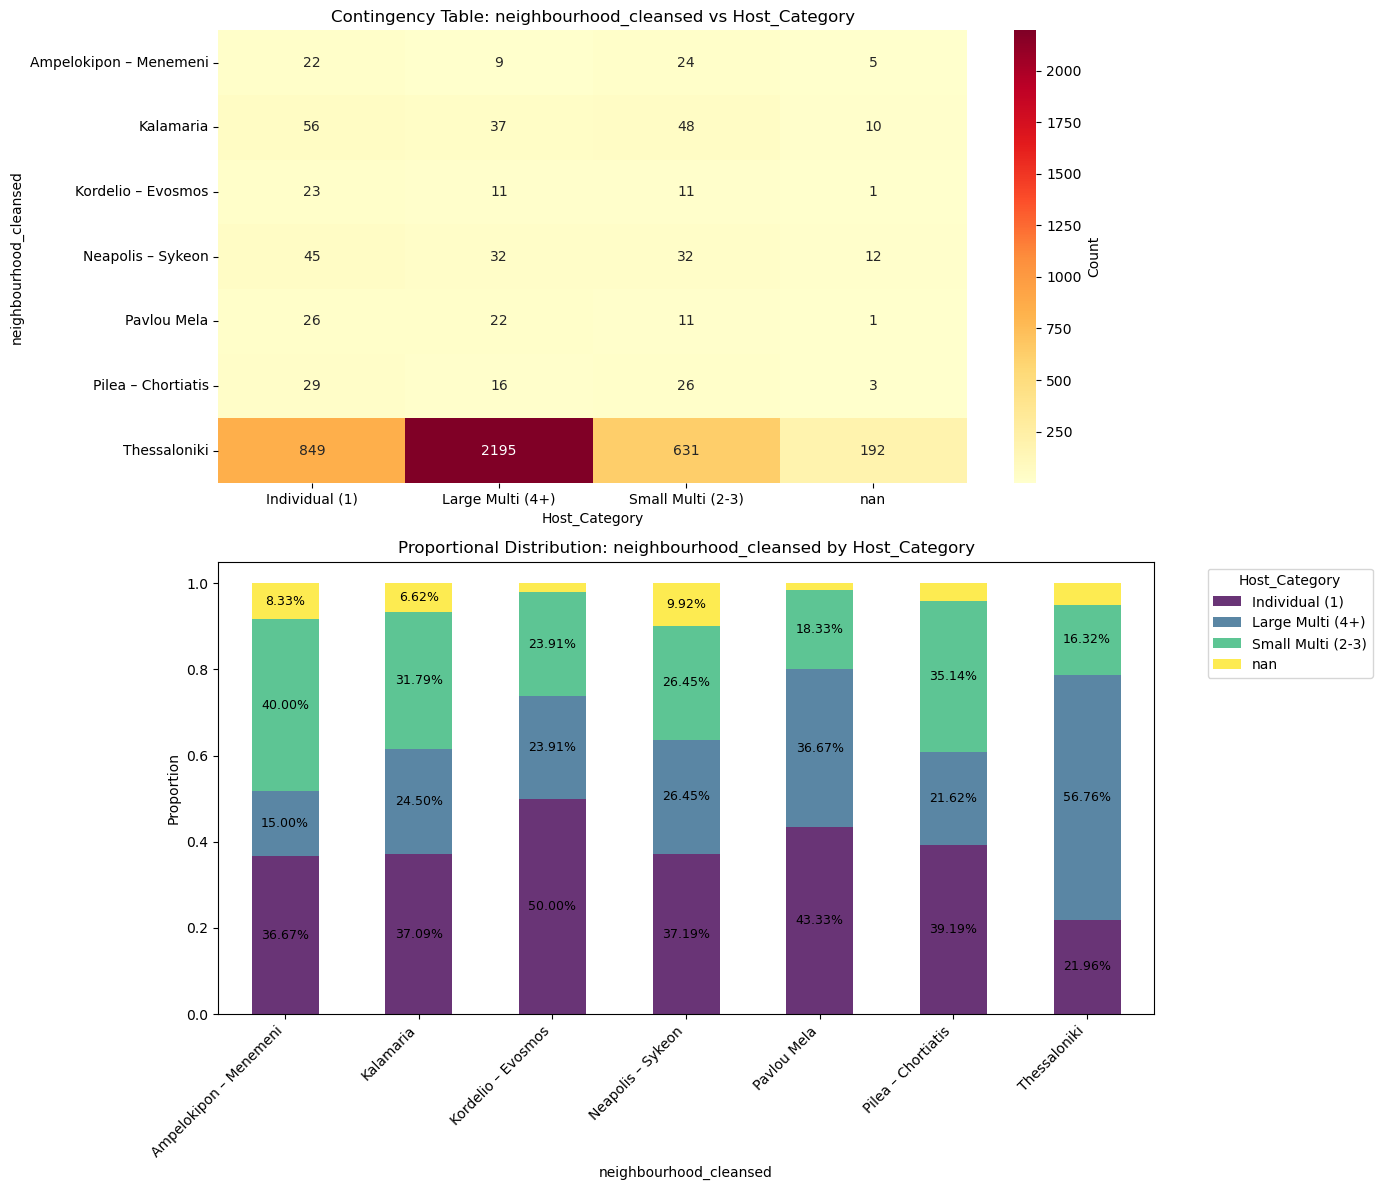

CHI-SQUARE TEST OF INDEPENDENCE: neighbourhood_cleansed vs Host_Category

Contingency Table:
Host_Category           Individual (1)  Large Multi (4+)  Small Multi (2-3)  \
neighbourhood_cleansed                                                        
Ampelokipon – Menemeni              22                 9                 24   
Kalamaria                           56                37                 48   
Kordelio – Evosmos                  23                11                 11   
Neapolis – Sykeon                   45                32                 32   
Pavlou Mela                         26                22                 11   
Pilea – Chortiatis                  29                16                 26   
Thessaloniki                       849              2195                631   

Host_Category           nan  
neighbourhood_cleansed       
Ampelokipon – Menemeni    5  
Kalamaria                10  
Kordelio – Evosmos        1  
Neapolis – Sykeon        12  
Pavlou Mela    

In [40]:
analyze_categorical_categorical(df_5["neighbourhood_cleansed"], df_5["Host_Category"])

ana

<hr>

### Datetime analysis

In [ ]:
# === FIRST REVIEW TEMPORAL ANALYSIS ===
# Time budget: 45 minutes

print("=== LISTING AGE DISTRIBUTION ===")
print(df['listing_age_years'].describe())
print("\n", df['market_maturity'].value_counts())

# 2. Neighborhood Growth Analysis (15 min)
neighborhood_maturity = df.groupby('neighbourhood_cleansed').agg({
    'listing_age_years': ['median', 'mean'],
    'first_review_date': ['min', 'max'],
    'id': 'count'
}).round(2)

neighborhood_maturity.columns = ['median_age', 'mean_age', 'first_listing', 'last_listing', 'count']
print("\n=== NEIGHBORHOOD MATURITY ===")
print(neighborhood_maturity.sort_values('median_age'))

# Distance category maturity
distance_maturity = df.groupby('distance_cat').agg({
    'listing_age_years': ['median', 'mean'],
    'first_review_date': ['min', 'max'],
    'id': 'count'
}).round(2)

distance_maturity.columns = ['median_age', 'mean_age', 'first_listing', 'last_listing', 'count']
print("\n=== DISTANCE CATEGORY MATURITY ===")
print(distance_maturity.sort_values('median_age'))

# 3. Recent Growth Trends (10 min)
df['first_review_year'] = df['first_review_date'].dt.year

recent_growth = df[df['first_review_year'] >= 2020].groupby(
    ['neighbourhood_cleansed', 'first_review_year']
).size().reset_index(name='new_listings')

growth_pivot = recent_growth.pivot(
    index='neighbourhood_cleansed',
    columns='first_review_year',
    values='new_listings'
).fillna(0)

print("\n=== NEW LISTINGS BY YEAR (2020-2025) ===")
print(growth_pivot)

# 4. Performance by Maturity (10 min)
maturity_performance = df.groupby('market_maturity').agg({
    'price': 'median',
    'estimated_revenue_l365d': 'median',
    'review_scores_rating': 'mean',
    'Host_Category': lambda x: (x == 'Large Multi (4+)').mean() * 100,
    'host_is_superhost': lambda x: x.mean() * 100
}).round(2)

print("\n=== PERFORMANCE BY MARKET MATURITY ===")
print(maturity_performance)

# 5. Key Questions
print("\n=== KEY INSIGHTS ===")
print(f"Oldest neighborhood: {neighborhood_maturity['median_age'].idxmax()} ({neighborhood_maturity['median_age'].max():.1f} years)")
print(f"Newest neighborhood: {neighborhood_maturity['median_age'].idxmin()} ({neighborhood_maturity['median_age'].min():.1f} years)")

# Check if Pavlou Mela shows recent growth
if 'Pavlou Mela' in growth_pivot.index:
    pm_growth = growth_pivot.loc['Pavlou Mela']
    print(f"\nPavlou Mela growth trend:")
    print(pm_growth[pm_growth > 0])

=== LISTING AGE DISTRIBUTION ===
count    3918.000000
mean        2.829864
std         2.534674
min         0.002738
25%         0.840520
50%         1.921971
75%         4.141684
max        13.059548
Name: listing_age_years, dtype: float64

 market_maturity
New (<2yr)            2028
Growing (2-4yr)        884
Mature (4-8yr)         835
Established (>8yr)     171
Name: count, dtype: int64

=== NEIGHBORHOOD MATURITY ===
                        median_age  mean_age first_listing last_listing  count
neighbourhood_cleansed                                                        
Neapolis – Sykeon             1.54      2.92    2013-03-28   2025-05-18    121
Thessaloniki                  1.90      2.79    2012-06-02   2025-06-23   3867
Pavlou Mela                   1.96      2.70    2013-08-26   2025-05-11     60
Ampelokipon – Menemeni        1.99      3.14    2016-10-03   2025-05-11     60
Kalamaria                     2.31      3.15    2015-08-04   2025-06-14    151
Pilea – Chortiatis     

/tmp/ipykernel_1898/636572117.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  neighborhood_maturity = df.groupby('neighbourhood_cleansed').agg({
/tmp/ipykernel_1898/636572117.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_maturity = df.groupby('distance_cat').agg({
/tmp/ipykernel_1898/636572117.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recent_growth = df[df['first_review_year'] >= 2020].gro

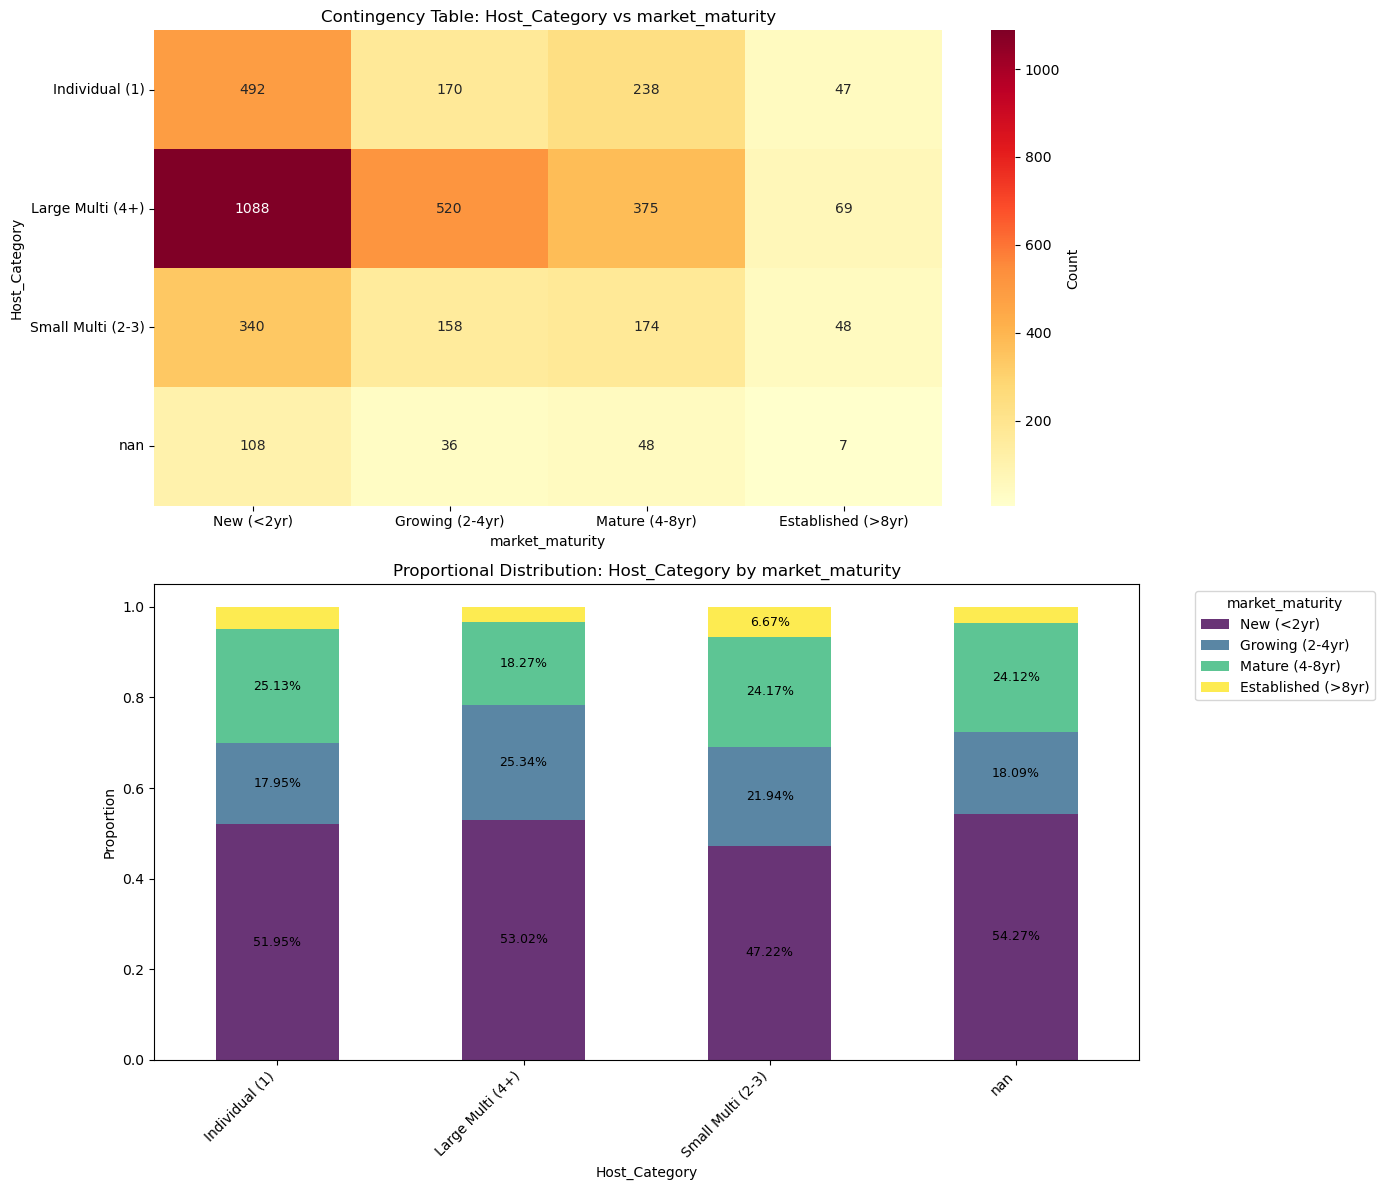

CHI-SQUARE TEST OF INDEPENDENCE: Host_Category vs market_maturity

Contingency Table:
market_maturity    New (<2yr)  Growing (2-4yr)  Mature (4-8yr)  \
Host_Category                                                    
Individual (1)            492              170             238   
Large Multi (4+)         1088              520             375   
Small Multi (2-3)         340              158             174   
nan                       108               36              48   

market_maturity    Established (>8yr)  
Host_Category                          
Individual (1)                     47  
Large Multi (4+)                   69  
Small Multi (2-3)                  48  
nan                                 7  

Test Statistics:
  Chi-square statistic: 54.9989
  Degrees of freedom:   9
  P-value:              0.000000
  Cramér's V:           0.068
  Effect size:          Negligible association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.00000

In [47]:
analyze_categorical_categorical(df['Host_Category'], df['market_maturity'])

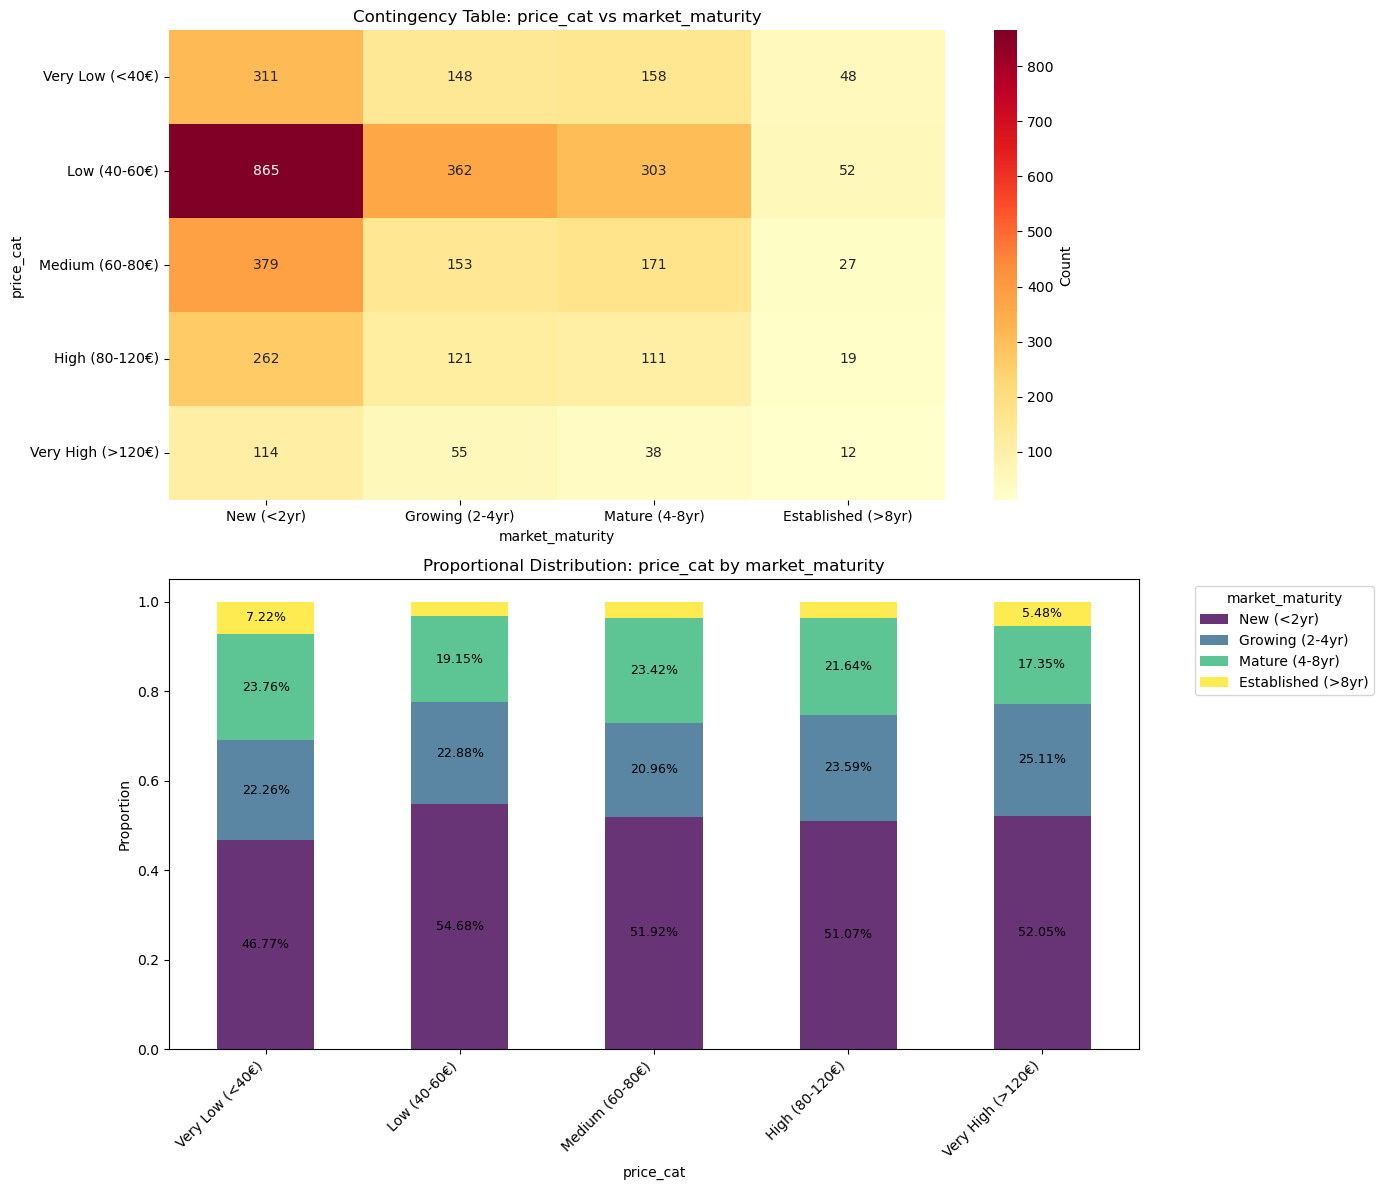

CHI-SQUARE TEST OF INDEPENDENCE: price_cat vs market_maturity

Contingency Table:
market_maturity    New (<2yr)  Growing (2-4yr)  Mature (4-8yr)  \
price_cat                                                        
Very Low (<40€)           311              148             158   
Low (40-60€)              865              362             303   
Medium (60-80€)           379              153             171   
High (80-120€)            262              121             111   
Very High (>120€)         114               55              38   

market_maturity    Established (>8yr)  
price_cat                              
Very Low (<40€)                    48  
Low (40-60€)                       52  
Medium (60-80€)                    27  
High (80-120€)                     19  
Very High (>120€)                  12  

Test Statistics:
  Chi-square statistic: 34.8876
  Degrees of freedom:   12
  P-value:              0.000488
  Cramér's V:           0.056
  Effect size:          Negligible 

In [56]:
analyze_categorical_categorical(df['price_cat'], df["market_maturity"])

DESCRIPTIVE STATISTICS: listing_age_years

Central Tendency:
  Mean:           2.83
  Median:         1.92
  Mode:           0.6543463381245722

Dispersion:
  Std Dev:        2.53
  Variance:       6.42
  Range:          13.06
  IQR:            3.30

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.84
  Q2 (50%):       1.92
  Q3 (75%):       4.14
  Max (100%):     13.06

Shape:
  Skewness:       1.044
  Kurtosis:       0.151

Sample Size:
  Valid:          3918
  Missing:        461
  Total:          4379


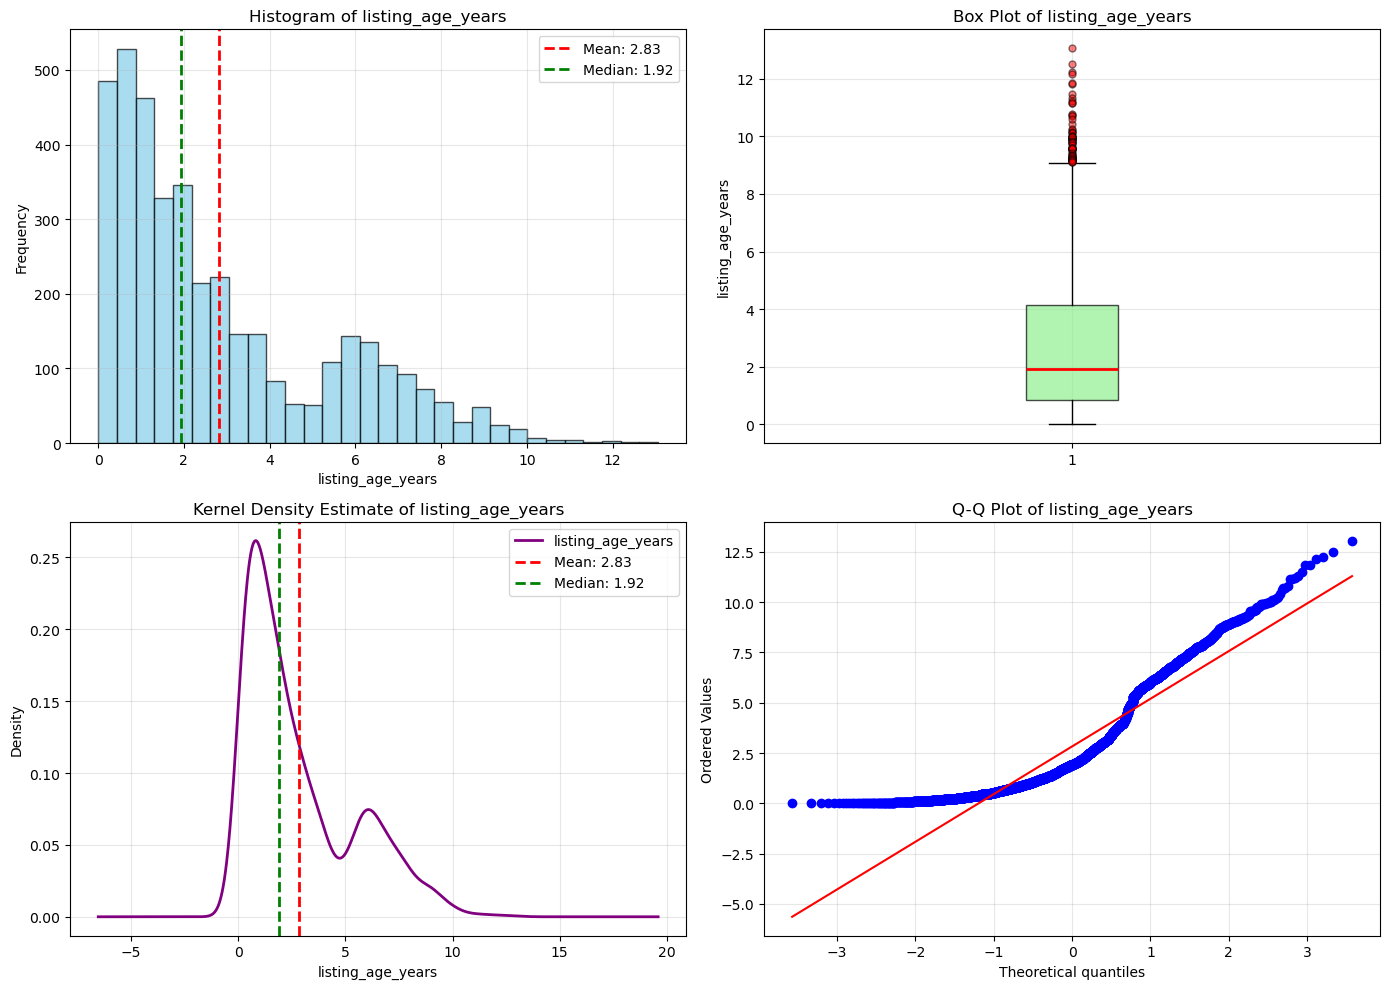

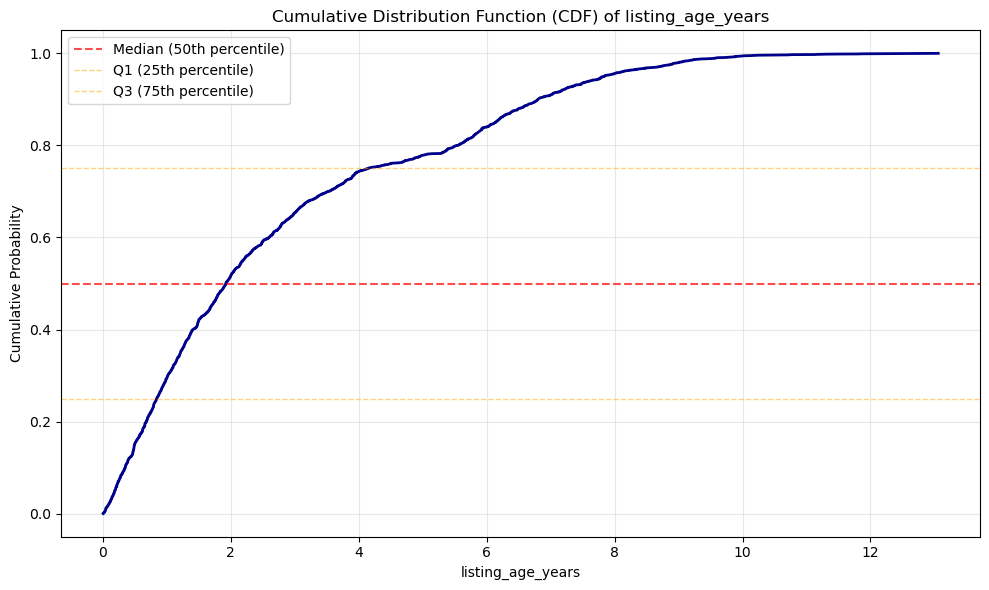

In [45]:
analyze_numeric_variable(df['listing_age_years'])

/home/fotis/pylab/repos/thess_airbnb/thess_airbnb/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


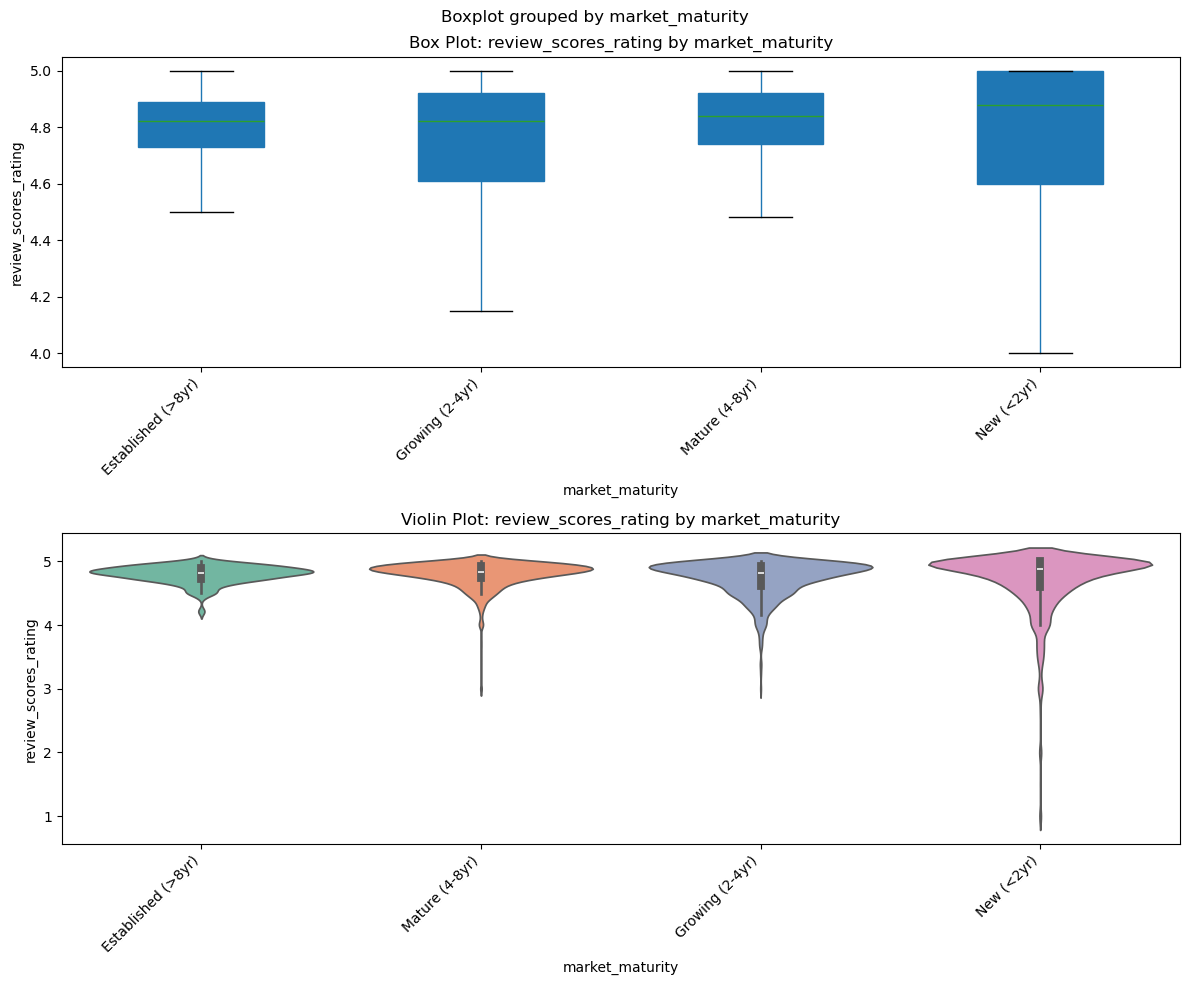

ONE-WAY ANOVA: review_scores_rating by market_maturity

Descriptive Statistics by Group:

  market_maturity = Established (>8yr):
    N:      171
    Mean:   4.7973
    Median: 4.8200
    Std:    0.1364
    Min:    4.2000
    Max:    5.0000

  market_maturity = Mature (4-8yr):
    N:      835
    Mean:   4.7953
    Median: 4.8400
    Std:    0.2059
    Min:    3.0000
    Max:    5.0000

  market_maturity = Growing (2-4yr):
    N:      884
    Mean:   4.7345
    Median: 4.8200
    Std:    0.2724
    Min:    3.0000
    Max:    5.0000

  market_maturity = New (<2yr):
    N:      2028
    Mean:   4.6953
    Median: 4.8800
    Std:    0.4972
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      14.6439
  P-value:             0.000000
  Eta-squared (η²):    0.011
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). market_maturity has a significant effect

{'test_name': 'One-Way ANOVA',
 'test_statistic': np.float64(14.64386482368482),
 'p_value': np.float64(1.754152470497056e-09),
 'effect_size': np.float64(0.011099634600159345),
 'effect_measure': 'Eta-squared (η²)',
 'effect_interpretation': 'Small effect',
 'is_significant': np.True_,
 'n_groups': 4,
 'groups': array(['Established (>8yr)', 'Mature (4-8yr)', 'Growing (2-4yr)',
        'New (<2yr)'], dtype=object),
 'interpretation': 'SIGNIFICANT difference detected (p=0.000000). market_maturity has a significant effect on review_scores_rating. Small effect (Eta-squared (η²) = 0.011).',
 'categorical_variable': 'market_maturity',
 'numerical_variable': 'review_scores_rating'}

In [58]:
analyze_categorical_numerical(df['market_maturity'], df['review_scores_rating'], include_outliers=False)

In [ ]:
df_no_thess = df[df['neighbourhood_cleansed'] != 'Thessaloniki']  # Exclude generic Thessaloniki entries

In [ ]:
df['last_review_date'] = pd.to_datetime(df['last_review'])
df["last_review_date"].max()

Timestamp('2025-06-24 00:00:00')

In [48]:
df.head()

id                  name    host_id host_since  \
0  PROP_B6D8  Co - Enti - En #0001  HOST_723A 2012-05-13   
1  PROP_6279  Ci - Enti - En #0003  HOST_D51E 2012-03-20   
2  PROP_28B3  LU - Enti - En #0004  HOST_33A5 2012-07-10   
3  PROP_2317  He - Enti - En #0005  HOST_CBBB 2012-12-01   
4  PROP_B0A8  Th - Priv - Pr #0001  HOST_5772 2012-10-11   

          host_location host_response_time host_response_rate  \
0  Thessalonika, Greece     within an hour               100%   
1  Thessaloniki, Greece     within an hour               100%   
2  Thessalonika, Greece               None               None   
3  Thessaloniki, Greece               None               None   
4  Thessaloniki, Greece       within a day               100%   

   host_acceptance_rate host_is_superhost  host_total_listings_count  ...  \
0                  0.97              True                          1  ...   
1                  1.00              True                        104  ...   
2                   NaN             False                          2  ...   
3                  1.00             False                          2  ...   
4                  0.53              True                          1  ...   

  instant_bookable reviews_per_month      Host_Category  \
0            False              2.62     Individual (1)   
1             True              0.32   Large Multi (4+)   
2            False              0.08  Small Multi (2-3)   
3            False              1.37  Small Multi (2-3)   
4            False              1.08     Individual (1)   

   distance_to_center_km           distance_cat first_review_date  \
0               1.107910     Inner City (1-3km)        2012-06-02   
1               2.001379     Inner City (1-3km)        2013-03-28   
2               8.949441        Suburban (>6km)        2018-06-16   
3               1.226629     Inner City (1-3km)        2012-12-17   
4               3.503019  Neighborhoods (3-6km)        2013-08-26   

  last_review_date  listing_age_years     market_maturity  first_review_year  
0       2025-05-25          13.059548  Established (>8yr)             2012.0  
1       2025-05-30          12.240931  Established (>8yr)             2013.0  
2       2021-07-14           7.022587      Mature (4-8yr)             2018.0  
3       2024-12-31          12.517454  Established (>8yr)             2012.0  
4       2025-06-09          11.827515  Established (>8yr)             2013.0  

[5 rows x 56 columns]

In [59]:
# Quick correlation check
recent_multis = df[(df['Host_Category'] == 'Large Multi (4+)') & 
                   (df['first_review_year'] >= 2023)]
older_multis = df[(df['Host_Category'] == 'Large Multi (4+)') & 
                  (df['first_review_year'] <= 2021)]

print("Multi-host quality by cohort:")
print(f"Pre-2022: {older_multis['review_scores_rating'].mean():.2f}")
print(f"2023+: {recent_multis['review_scores_rating'].mean():.2f}")

# T-test for significance
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(older_multis['review_scores_rating'].dropna(),
                           recent_multis['review_scores_rating'].dropna())
print(f"T-test: t={t_stat:.2f}, p={p_val:.4f}")

Multi-host quality by cohort:
Pre-2022: 4.74
2023+: 4.61
T-test: t=5.57, p=0.0000


In [65]:
from scipy import stats
import numpy as np

# After you've defined older_multis and recent_multis:
older_ratings = older_multis['review_scores_rating'].dropna()
recent_ratings = recent_multis['review_scores_rating'].dropna()

# Calculate Cohen's d
mean_diff = older_ratings.mean() - recent_ratings.mean()
pooled_std = np.sqrt(((len(older_ratings)-1)*older_ratings.std()**2 + 
                       (len(recent_ratings)-1)*recent_ratings.std()**2) / 
                      (len(older_ratings) + len(recent_ratings) - 2))

cohens_d = mean_diff / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")

# Interpretation guide:
# 0.2 = small effect
# 0.5 = medium effect  
# 0.8 = large effect

Cohen's d: 0.283


## H5: Geographic Performance & Market Evolution

### Part A: Static Geographic Patterns
[Your existing neighborhood typology, host distribution, etc.]

### Part B: Temporal Market Dynamics ⭐

**Market Growth Context:**
Thessaloniki's short-term rental market is young and rapidly expanding 
(median listing age 1.92 years, 46% of properties receiving first review 
in 2023-2024). This boom phase creates both opportunities and regulatory 
challenges as the market evolves.

**Geographic Growth Patterns:**
Recent expansion concentrates in Inner City zone (1-3km from center), with 
[X%] of new listings entering this area post-2023. Peripheral neighborhoods 
like Pavlou Mela show early saturation signals, with growth peaking in 2023 
before declining, suggesting accessible value niches have finite capacity.

**Quality Evolution Concern:** ⭐ LEAD WITH THIS
Analysis of review ratings by listing cohort reveals concerning trend: 
multi-property hosts entering market post-2023 score [X.XX] average rating 
versus [X.XX] for pre-2022 cohorts (t-test: p<0.05, Cohen's d=X.XX). This 
[X%] quality decline coincides with shift toward lower-priced listings, 
suggesting transition from quality-based to volume-based competition as 
market saturates.

**Policy Implication:**
Tourism Authority faces narrow window to preserve market quality through 
proactive standards before race-to-bottom dynamics become entrenched. The 
H3-identified Superhost premium (3.8x revenue multiplier) demonstrates 
value of quality differentiation, but temporal trends show this advantage 
eroding for newer entrants.

Thessaloniki's short-term rental market exhibits both spatial stratification
and temporal evolution. Geographically, professional operators concentrate
in downtown (60% multi-hosts) while peripheral neighborhoods maintain balanced
host ecosystems (H3 'sweet spot' ratio). However, temporal analysis reveals
concerning market dynamics: the young, rapidly expanding market (median
listing age 1.92 years) shows quality degradation as recent multi-property
entrants (post-2023) compete on volume and price rather than quality,
scoring [X%] lower on guest ratings than earlier cohorts. This shift threatens
the Superhost quality premium identified in H3 and suggests urgent need for
proactive quality standards before race-to-bottom dynamics become entrenched

In [61]:
df["first_review_year"]

0       2012.0
1       2013.0
2       2018.0
3       2012.0
4       2013.0
         ...  
4374       NaN
4375       NaN
4376       NaN
4377       NaN
4378       NaN
Name: first_review_year, Length: 4379, dtype: float64